# Telecom Churn Prediction
### Predicting High Value Prepaid Customers who will churn in the near future
#### Submitted by 
- Sameer Soin
- Ayush Mandowara

### Imports

In [1]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz
from sklearn.tree import plot_tree
import matplotlib.image as mpimg

# Model Building
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Sampling
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Imbpipeline
from imblearn.under_sampling import RandomUnderSampler

# Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn import metrics

### Utility Functions

In [239]:
# function for printing columns with their percentage missing values
def print_missing_val_percent_in_cols(df):
    for col in df.columns:
        missing_percent = df[col].isnull().sum() / df.shape[0] * 100
        print('{}: {}'.format(col, round(missing_percent, 2)))
        
# function to return the columns with missing values
def find_missing_val_cols(df):
    missing_val_cols = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            missing_val_cols.append(col)
    return missing_val_cols

# function to return columns of the dataframe containing string x
def get_cols(df, x):
    x_cols = []
    for col in df.columns:
        if x in col:
            x_cols.append(col)
    return x_cols

def get_data_missing_cols(df):
    data_missing_cols = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if 'num_of_days' not in col:
                data_missing_cols.append(col)
            print(col, round(df[col].isnull().sum() / len(df) * 100, 2))
    return data_missing_cols

def divide_columns_based_on_number_of_unique_values(df, num_unique_vals):
    col_large_unique = []
    col_small_unique = []
    for col in df:
        if len(df[col].unique()) > num_unique_vals:
            col_large_unique.append(col)
        else:
            col_small_unique.append(col)

    print(f'more than {num_unique_vals} unique values:\nlist: {col_large_unique} \ntotal columns: {len(col_large_unique)}')
    print()

    print(f'less than {num_unique_vals} unique values:\nlist: {col_small_unique} \ntotal columns: {len(col_small_unique)}')
    print()
    
    return col_large_unique, col_small_unique

def plot_small(df, column):
    '''Common plot function for columns with small number of unique values'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.countplot(x = column, data=df, ax=ax1)
    df[column].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
    plt.suptitle(f"{column} [dtype: {df[column].dtype}]")
    plt.savefig(f"{column}.png")
    plt.show()
    
    print(df[column].value_counts().to_string())

def plot_large(df, column):
    '''Common plot function for columns with large number of unique values'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
    plt.suptitle(f"{column} [dtype: {df[column].dtype}]")
    try:
        sns.histplot(df[column], bins=50, ax=ax1)
        ax1.set_xticks(ax1.get_xticklabels(), rotation=90)
    except:
        pass
    try:
        sns.kdeplot(x=column, data=df, ax=ax2)
    except:
        pass
    try:            
        sns.boxplot(x=column, data=df, ax=ax3)
    except:
        pass
    # plt.savefig(f"{column}.png")
    plt.show()
    print(df[column].describe().to_string())
    print()


# function to generate all the concerned evaluation metrics for a model
model_scores_dict = {}
def classification_metrics(y_actual, y_pred, model_name_key=None):
    
    confusion_mat = confusion_matrix(y_actual, y_pred)
    TP = confusion_mat[1,1] # true positive 
    TN = confusion_mat[0,0] # true negatives
    FP = confusion_mat[0,1] # false positives
    FN = confusion_mat[1,0] # false negatives

    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    accuracy = accuracy_score(y_actual, y_pred)
    precision = metrics.precision_score(y_actual, y_pred)
    recall = metrics.recall_score(y_actual, y_pred)
    TPR = sensitivity
    FNR = FN/(TP+FN)
    f1 = metrics.f1_score(y_actual, y_pred)
    
    clf_data = [[sensitivity, specificity, accuracy, precision, recall, TPR, FNR, f1]]
    clf_df = pd.DataFrame(clf_data, columns=['sensitivity', 'specificity', 'accuracy', 'precision', 'recall', 'TPR', 'FNR', 'F1_score'])
    clf_df = round(clf_df, 2)
    
    if model_name_key:
        model_scores_dict[model_name_key] = np.round(np.array(clf_data[0]),2)
    return clf_df

def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None


# function to genarate Churn labels from the class probability for all the given thresholds
def generate_prob_threshold_df(y_actual, y_pred_prob, thresholds):
    
    y_pred_prob = y_pred_prob[:, 1]
    # thresholds = np.round(np.arange(0, 1, 0.1), 2)
    threshold_df = pd.DataFrame(list(zip(y_actual, y_pred_prob)), columns=['Actual Churn', 'Probability'])
    
    for i in thresholds:
        churn_pred = [1 if p >= i else 0 for p in y_pred_prob]
        threshold_df[i] = churn_pred
    
    return threshold_df

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
def generate_optimal_cutoff_df(threshold_df, thresholds):
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

    for i in thresholds:
        cm1 = confusion_matrix(threshold_df['Actual Churn'], threshold_df[i])
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    return cutoff_df

# function to find optimal cut off point
def metrics_on_different_thresholds(y_actual, thresholds, threshold_df):
    '''Helper function to find optimal cut off point by try various thresholds'''
    joined_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'accuracy', 'precision', 'recall', 'TPR', 'FNR', 'F1_score'])
    for i in thresholds:
        joined_df = pd.concat([joined_df, classification_metrics(y_actual, threshold_df[i])])
    joined_df = joined_df.set_index(thresholds)
    return joined_df

---

## Data Reading and Understanding

In [3]:
#to display all columns
pd.set_option('display.max_columns', None)

In [4]:
# load the dataset
churn_df = pd.read_csv('telecom_churn_data.csv')
churn_df.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

In [5]:
churn_df.shape

(99999, 226)

In [6]:
# see basic imformation about the dataset
churn_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

In [7]:
churn_df.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.505000   
25%               0.0     93.411500     86.980500     84.126000     62.685000   
50%               0.0    197.704000    191.640000    192.080000    176.849000   
75%               0.0    371.060000    365.344500    369.370500    353.466500   
max               0.0  27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6   onnet_mou_7   onnet_mou_8   onnet_mou_9  offnet_mou_6  \
count  96062.000000  96140.000000  94621.000000  92254.000000  96062.000000   
mean     132.395875    133.670805    133.018098    130.302327    197.935577   
std      297.207406    308.794148    308.951589    308.477668    316.851613   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        7.380000      6.660000      6.460000      5.330000     34.730000   
50%       34.310000     32.330000     32.360000     29.840000     96.310000   
75%      118.740000    115.595000    115.860000    112.130000    231.860000   
max     7376.710000   8157.780000  10752.560000  10427.460000   8362.360000   

       offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
count  96140.000000  94621.000000  92254.000000   96062.000000   96140.000000   
mean     197.045133    196.574803    190.337222       9.950013       7.149898   
std      325.862803    327.170662    319.396092      72.825411      73.447948   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%       32.190000     31.630000     27.130000       0.000000       0.000000   
50%       91.735000     92.140000     87.290000       0.000000       0.000000   
75%      226.815000    228.260000    220.505000       0.000000       0.000000   
max     9667.130000  14007.340000  10310.760000   13724.380000   15371.040000   

       roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  \
count   94621.000000   92254.000000   96062.000000   96140.000000   
mean        7.292981       6.343841      13.911337       9.818732   
std        68.402466      57.137537      71.443196      58.455762   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max     13095.360000    8464.030000    3775.110000    2812.040000   

       roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   94621.000000   92254.000000      96062.000000      96140.000000   
mean        9.971890       8.555519         47.100763         46.473010   
std        64.713221      58.438186        150.856393        155.318705   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.630000   
50%         0.000000       0.000000         11.910000         11.610000   
75%         0.000000       0.000000         40.960000         39.910000   
max      

In [8]:
# checking the percentage of missing values in the data set
print_missing_val_percent_in_cols(churn_df)

mobile_number: 0.0
circle_id: 0.0
loc_og_t2o_mou: 1.02
std_og_t2o_mou: 1.02
loc_ic_t2o_mou: 1.02
last_date_of_month_6: 0.0
last_date_of_month_7: 0.6
last_date_of_month_8: 1.1
last_date_of_month_9: 1.66
arpu_6: 0.0
arpu_7: 0.0
arpu_8: 0.0
arpu_9: 0.0
onnet_mou_6: 3.94
onnet_mou_7: 3.86
onnet_mou_8: 5.38
onnet_mou_9: 7.75
offnet_mou_6: 3.94
offnet_mou_7: 3.86
offnet_mou_8: 5.38
offnet_mou_9: 7.75
roam_ic_mou_6: 3.94
roam_ic_mou_7: 3.86
roam_ic_mou_8: 5.38
roam_ic_mou_9: 7.75
roam_og_mou_6: 3.94
roam_og_mou_7: 3.86
roam_og_mou_8: 5.38
roam_og_mou_9: 7.75
loc_og_t2t_mou_6: 3.94
loc_og_t2t_mou_7: 3.86
loc_og_t2t_mou_8: 5.38
loc_og_t2t_mou_9: 7.75
loc_og_t2m_mou_6: 3.94
loc_og_t2m_mou_7: 3.86
loc_og_t2m_mou_8: 5.38
loc_og_t2m_mou_9: 7.75
loc_og_t2f_mou_6: 3.94
loc_og_t2f_mou_7: 3.86
loc_og_t2f_mou_8: 5.38
loc_og_t2f_mou_9: 7.75
loc_og_t2c_mou_6: 3.94
loc_og_t2c_mou_7: 3.86
loc_og_t2c_mou_8: 5.38
loc_og_t2c_mou_9: 7.75
loc_og_mou_6: 3.94
loc_og_mou_7: 3.86
loc_og_mou_8: 5.38
loc_og_mou_9: 7.7

In [9]:
missing_val_cols = find_missing_val_cols(churn_df)
print(missing_val_cols)

['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2m_mou_9', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t

---

## Filtering top 70th percentile

### Deriving Columns

#### **Business Decision: The missing values for data recharge amount, call recharge amount and avergae recharge amount can be imputed with 0**

In [10]:
churn_df[['total_rech_data_6', 'total_rech_data_7', 
          'total_rech_data_8', 'total_rech_data_9',
          'av_rech_amt_data_6', 'av_rech_amt_data_7',
          'av_rech_amt_data_8', 'av_rech_amt_data_9',
          'total_rech_amt_6', 'total_rech_amt_7',
          'total_rech_amt_8', 'total_rech_amt_9']] = churn_df[['total_rech_data_6', 'total_rech_data_7',
                                                               'total_rech_data_8', 'total_rech_data_9',
                                                               'av_rech_amt_data_6', 'av_rech_amt_data_7',
                                                               'av_rech_amt_data_8', 'av_rech_amt_data_9',
                                                               'total_rech_amt_6', 'total_rech_amt_7',
                                                               'total_rech_amt_8', 'total_rech_amt_9']].fillna(0)

#### Deriving the column that has total data recharge amount for every month

In [11]:
# creating total amount spend on data for each month
churn_df['total_rech_data_amt_6'] = churn_df['total_rech_data_6'] * churn_df['av_rech_amt_data_6']
churn_df['total_rech_data_amt_7'] = churn_df['total_rech_data_7'] * churn_df['av_rech_amt_data_7']
churn_df['total_rech_data_amt_8'] = churn_df['total_rech_data_8'] * churn_df['av_rech_amt_data_8']
churn_df['total_rech_data_amt_9'] = churn_df['total_rech_data_9'] * churn_df['av_rech_amt_data_9']

In [12]:
churn_df.shape

(99999, 230)

#### Deriving the columns that has the total recharge amount for calling plus data included for every month

In [13]:
# creating total amound spend every month including calls and data
churn_df['total_rech_call_plus_data_6'] = churn_df['total_rech_amt_6'] + churn_df['total_rech_data_amt_6']
churn_df['total_rech_call_plus_data_7'] = churn_df['total_rech_amt_7'] + churn_df['total_rech_data_amt_7']
churn_df['total_rech_call_plus_data_8'] = churn_df['total_rech_amt_8'] + churn_df['total_rech_data_amt_8']
churn_df['total_rech_call_plus_data_9'] = churn_df['total_rech_amt_9'] + churn_df['total_rech_data_amt_9']

#### **NOTE: We have assumed that average data usage amount also includes value based services amount**

<!-- #### Deriving the totol amount spend per month -->

#### **Business Logic: Finding the average amount of total recharge of call plus data for the good phase i.e. the months 6 and 7**

In [14]:
# creating average amount spend on call plus data in good phase
churn_df['total_rech_call_plus_data_good_phase'] = (churn_df['total_rech_call_plus_data_6'] + churn_df['total_rech_call_plus_data_7']) / 2

#### **Business Decision: Only the customers that have average recharge amount more than 70 percentile during the good phase (i.e months 6 and 7) are considered for the churn prediction as according to the businees logic these are the customers that account for 80% of the total revenue**

In [15]:
# computing the 70% quantile recharge amount
high_value_cust_rech_amt = churn_df['total_rech_call_plus_data_good_phase'].quantile(0.7)
print(high_value_cust_rech_amt)

478.0


#### Observation: The threshold recharge amount for deciding a customer as high value comes out to be Rs 478 per month during the good phase

In [16]:
# finding the high value customers
churn_df = churn_df[churn_df['total_rech_call_plus_data_good_phase'] > high_value_cust_rech_amt]
churn_df.shape

(29953, 235)

#### NOTE: The data set that contains only the high value customers has roughly 29.9k records

---

## Labelling Churn

### Calculating the Churn label for the month of September

In [17]:
# finding the usage-based churn for month 9
#finding the total call and data usage for month 9
churn_df['total_call_data_usage_9'] = churn_df['total_ic_mou_9'] + churn_df['total_og_mou_9'] + churn_df['vol_2g_mb_9'] + churn_df['vol_3g_mb_9']

# finding the Churn label on usage
churn_df['Churn'] = (churn_df['total_call_data_usage_9'] > 0).map({True: 0, False: 1})

In [18]:
churn_df.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      7000842753        109             0.0             0.0             0.0   
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
21     7002124215        109             0.0             0.0             0.0   
23     7000887461        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0             6/30/2014            7/31/2014            8/31/2014   
7             6/30/2014            7/31/2014            8/31/2014   
8             6/30/2014            7/31/2014            8/31/2014   
21            6/30/2014            7/31/2014            8/31/2014   
23            6/30/2014            7/31/2014            8/31/2014   

   last_date_of_month_9    arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  \
0             9/30/2014   197.385   214.816   213.803   21.100          NaN   
7             9/30/2014  1069.180  1349.850  3171.480  500.000        57.84   
8             9/30/2014   378.721   492.223   137.362  166.787       413.69   
21            9/30/2014   514.453   597.753   637.760  578.596       102.41   
23            9/30/2014    74.350   193.897   366.966  811.480        48.96   

    onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0           NaN         0.00          NaN           NaN           NaN   
7         54.68        52.29          NaN        453.43        567.16   
8        351.03        35.08        33.46         94.66         80.63   
21       132.11        85.14       161.63        757.93        896.68   
23        50.66        33.58        15.74         85.41         89.36   

    offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0           0.00           NaN            NaN            NaN           0.00   
7         325.91           NaN          16.23          33.49          31.64   
8         136.48        108.71           0.00           0.00           0.00   
21        983.39        869.89           0.00           0.00           0.00   
23        205.89        111.88           0.00           0.00           0.00   

    roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0             NaN            NaN            NaN           0.00            NaN   
7             NaN          23.74          12.59          38.06            NaN   
8             0.0           0.00           0.00           0.00            0.0   
21            0.0           0.00           0.00           0.00            0.0   
23            0.0           0.00           0.00           0.00            0.0   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0                NaN               NaN              0.00               NaN   
7              51.39             31.38             40.28               NaN   
8             297.13            217.59             12.49             26.13   
21              4.48              6.16             23.34             29.98   
23             48.96             50.66             33.58             15.74   

    loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0                NaN               NaN              0.00               NaN   
7             308.63            447.38            162.28               NaN   
8              80.96             70.58             50.54             34.58   
21             91.81             87.93            104.81            107.54   
23             82.94             83.01            148.56             83.73   

    loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0                NaN               NaN              0.00               NaN   
7              62.13             55.14             53.23               NaN   
8               0.00              0.00              0.00    

**Renaming the jun_vbc_3g and other columns to have month number a suffix for maintaining naming consistency**

In [19]:
# renaminga the columns to have month number as suffix
churn_df.rename(columns={'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8', 'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)

#### Dropping the columns with month 9 data as it won't  be available at the time of prediction

In [20]:
# dropping month 9 columns
churn_df.drop(get_cols(churn_df, '_9'), axis=1, inplace=True)

In [21]:
churn_df.shape

(29953, 179)

---

### Exploring the object columns

In [22]:
object_data_type_cols = churn_df.select_dtypes('object')
object_data_type_cols

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0                6/30/2014            7/31/2014            8/31/2014   
7                6/30/2014            7/31/2014            8/31/2014   
8                6/30/2014            7/31/2014            8/31/2014   
21               6/30/2014            7/31/2014            8/31/2014   
23               6/30/2014            7/31/2014            8/31/2014   
...                    ...                  ...                  ...   
99981            6/30/2014            7/31/2014            8/31/2014   
99984            6/30/2014            7/31/2014            8/31/2014   
99986            6/30/2014            7/31/2014            8/31/2014   
99988            6/30/2014            7/31/2014            8/31/2014   
99997            6/30/2014            7/31/2014            8/31/2014   

      date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
0               6/21/2014           7/16/2014            8/8/2014   
7               6/27/2014           7/25/2014           8/26/2014   
8               6/25/2014           7/31/2014           8/30/2014   
21              6/30/2014           7/31/2014           8/31/2014   
23              6/18/2014            7/7/2014           8/24/2014   
...                   ...                 ...                 ...   
99981           6/17/2014           7/25/2014           8/27/2014   
99984           6/21/2014           7/31/2014           8/27/2014   
99986           6/20/2014           7/28/2014           8/18/2014   
99988           6/30/2014           7/28/2014           8/29/2014   
99997           6/17/2014           7/19/2014           8/20/2014   

      date_of_last_rech_data_6 date_of_last_rech_data_7  \
0                    6/21/2014                7/16/2014   
7                          NaN                      NaN   
8                          NaN                7/31/2014   
21                         NaN                      NaN   
23                         NaN                 7/7/2014   
...                        ...                      ...   
99981                6/17/2014                7/14/2014   
99984                6/15/2014                7/31/2014   
99986                6/17/2014                7/18/2014   
99988                      NaN                7/26/2014   
99997                6/17/2014                7/19/2014   

      date_of_last_rech_data_8  
0                     8/8/2014  
7                          NaN  
8                    8/23/2014  
21                         NaN  
23                    8/6/2014  
...                        ...  
99981                8/23/2014  
99984                8/27/2014  
99986                8/14/2014  
99988                8/23/2014  
99997                8/20/2014  

[29953 rows x 9 columns]

**Observation: All the object data type columns are dates**

In [23]:
# converting the object type columns to datetime
for col in object_data_type_cols:
    churn_df[col] = churn_df[col].apply(pd.to_datetime)

In [24]:
churn_df

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
0         7000842753        109             0.0             0.0   
7         7000701601        109             0.0             0.0   
8         7001524846        109             0.0             0.0   
21        7002124215        109             0.0             0.0   
23        7000887461        109             0.0             0.0   
...              ...        ...             ...             ...   
99981     7000630859        109             0.0             0.0   
99984     7000661676        109             0.0             0.0   
99986     7001729035        109             0.0             0.0   
99988     7002111859        109             0.0             0.0   
99997     7000498689        109             0.0             0.0   

       loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
0                 0.0           2014-06-30           2014-07-31   
7                 0.0           2014-06-30           2014-07-31   
8                 0.0           2014-06-30           2014-07-31   
21                0.0           2014-06-30           2014-07-31   
23                0.0           2014-06-30           2014-07-31   
...               ...                  ...                  ...   
99981             0.0           2014-06-30           2014-07-31   
99984             0.0           2014-06-30           2014-07-31   
99986             0.0           2014-06-30           2014-07-31   
99988             0.0           2014-06-30           2014-07-31   
99997             0.0           2014-06-30           2014-07-31   

      last_date_of_month_8    arpu_6    arpu_7    arpu_8  onnet_mou_6  \
0               2014-08-31   197.385   214.816   213.803          NaN   
7               2014-08-31  1069.180  1349.850  3171.480        57.84   
8               2014-08-31   378.721   492.223   137.362       413.69   
21              2014-08-31   514.453   597.753   637.760       102.41   
23              2014-08-31    74.350   193.897   366.966        48.96   
...                    ...       ...       ...       ...          ...   
99981           2014-08-31   384.316   255.405   393.474        78.68   
99984           2014-08-31   328.594   202.966   118.707       423.99   
99986           2014-08-31   644.973   455.228   564.334       806.73   
99988           2014-08-31   312.558   512.932   402.080       199.89   
99997           2014-08-31   322.991   303.386   606.817         0.00   

       onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
0              NaN         0.00           NaN           NaN          0.00   
7            54.68        52.29        453.43        567.16        325.91   
8           351.03        35.08         94.66         80.63        136.48   
21          132.11        85.14        757.93        896.68        983.39   
23           50.66        33.58         85.41         89.36        205.89   
...            ...          ...           ...           ...           ...   
99981        29.04       103.24         56.13         28.09         61.44   
99984       181.83         5.71         39.51         39.81         18.26   
99986       549.36       775.41        784.76        617.13        595.44   
99988       174.46         2.46        175.88        277.01        248.33   
99997         0.00         0.00          0.00          0.00          0.00   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0                NaN            NaN           0.00            NaN   
7              16.23          33.49          31.64          23.74   
8               0.00           0.00           0.00           0.00   
21              0.00           0.00           0.00           0.00   
23              0.00           0.00           0.00           0.00   
...              ...            ...            ...            ...   
99981           0.00           0.00           0.00           0.00   
99984           0.00           0.00        

**Object data type columns are converted to datetime type**

### Deriving Columns

### Deriving the number of days since last recharge column

Imputing the missing values in last date of month before deriving new columns

In [25]:
# imputing the missing values
churn_df['last_date_of_month_7'].fillna(churn_df['last_date_of_month_7'].mode()[0], inplace=True)
churn_df['last_date_of_month_8'].fillna(churn_df['last_date_of_month_8'].mode()[0], inplace=True)

In [26]:
# finding the number of days since last call recharge for every month
churn_df['num_of_days_last_rech_6'] = (churn_df['last_date_of_month_6'] - churn_df['date_of_last_rech_6']).dt.days
churn_df['num_of_days_last_rech_7'] = (churn_df['last_date_of_month_7'] - churn_df['date_of_last_rech_7']).dt.days
churn_df['num_of_days_last_rech_8'] = (churn_df['last_date_of_month_8'] - churn_df['date_of_last_rech_8']).dt.days

# finding the number of days since last data recharge for every month
churn_df['num_of_days_last_rech_data_6'] = (churn_df['last_date_of_month_6'] - churn_df['date_of_last_rech_data_6']).dt.days
churn_df['num_of_days_last_rech_data_7'] = (churn_df['last_date_of_month_7'] - churn_df['date_of_last_rech_data_7']).dt.days
churn_df['num_of_days_last_rech_data_8'] = (churn_df['last_date_of_month_8'] - churn_df['date_of_last_rech_data_8']).dt.days

print(churn_df.shape)
churn_df.head()

(29953, 185)


mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0      7000842753        109             0.0             0.0             0.0   
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
21     7002124215        109             0.0             0.0             0.0   
23     7000887461        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8    arpu_6  \
0            2014-06-30           2014-07-31           2014-08-31   197.385   
7            2014-06-30           2014-07-31           2014-08-31  1069.180   
8            2014-06-30           2014-07-31           2014-08-31   378.721   
21           2014-06-30           2014-07-31           2014-08-31   514.453   
23           2014-06-30           2014-07-31           2014-08-31    74.350   

      arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0    214.816   213.803          NaN          NaN         0.00           NaN   
7   1349.850  3171.480        57.84        54.68        52.29        453.43   
8    492.223   137.362       413.69       351.03        35.08         94.66   
21   597.753   637.760       102.41       132.11        85.14        757.93   
23   193.897   366.966        48.96        50.66        33.58         85.41   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0            NaN          0.00            NaN            NaN           0.00   
7         567.16        325.91          16.23          33.49          31.64   
8          80.63        136.48           0.00           0.00           0.00   
21        896.68        983.39           0.00           0.00           0.00   
23         89.36        205.89           0.00           0.00           0.00   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0             NaN            NaN           0.00               NaN   
7           23.74          12.59          38.06             51.39   
8            0.00           0.00           0.00            297.13   
21           0.00           0.00           0.00              4.48   
23           0.00           0.00           0.00             48.96   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0                NaN              0.00               NaN               NaN   
7              31.38             40.28            308.63            447.38   
8             217.59             12.49             80.96             70.58   
21              6.16             23.34             91.81             87.93   
23             50.66             33.58             82.94             83.01   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0               0.00               NaN               NaN              0.00   
7             162.28             62.13             55.14             53.23   
8              50.54              0.00              0.00              0.00   
21            104.81              0.75              0.00              1.58   
23            148.56              0.00              0.00              0.00   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0                NaN               NaN              0.00           NaN   
7                0.0               0.0              0.00        422.16   
8                0.0               0.0              7.15        378.09   
21               0.0               0.0              0.00         97.04   
23               0.0               0.0             17.71        131.91   

    loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0            NaN          0.00               NaN               NaN   
7         533.91        255.79              4.30             23.29   
8         288.18         63.04            116.56            133.43   
21         94.09    

#### **Dropping the date columns as we have derived new columns using that information and it is no longer useful**

In [27]:
# dropping the last date of month and last day of recharge for call and data columns for the months
churn_df.drop(list(object_data_type_cols), axis=1, inplace=True)
churn_df.shape

(29953, 176)

---

## Data Cleaning and Preprocessing
- Null Value Imputation will be performed here
- Columns which will be filled based on business logic (i.e. some fixed value) can be filled before train test split
- Some EDA will also be performed here to understand what value fits best

#### **We need to prepare the data in a way that months 6 and 7 are combined into good phase data and month 8 as action phase. We are doing this to give the model input this way.**

In [28]:
churn_df['circle_id'].value_counts()

109    29953
Name: circle_id, dtype: int64

**We can drop circle_id as it has the same value for all columns**

In [29]:
churn_df.drop('circle_id', axis=1, inplace=True)

In [30]:
churn_df.head()

mobile_number  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou    arpu_6  \
0      7000842753             0.0             0.0             0.0   197.385   
7      7000701601             0.0             0.0             0.0  1069.180   
8      7001524846             0.0             0.0             0.0   378.721   
21     7002124215             0.0             0.0             0.0   514.453   
23     7000887461             0.0             0.0             0.0    74.350   

      arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0    214.816   213.803          NaN          NaN         0.00           NaN   
7   1349.850  3171.480        57.84        54.68        52.29        453.43   
8    492.223   137.362       413.69       351.03        35.08         94.66   
21   597.753   637.760       102.41       132.11        85.14        757.93   
23   193.897   366.966        48.96        50.66        33.58         85.41   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0            NaN          0.00            NaN            NaN           0.00   
7         567.16        325.91          16.23          33.49          31.64   
8          80.63        136.48           0.00           0.00           0.00   
21        896.68        983.39           0.00           0.00           0.00   
23         89.36        205.89           0.00           0.00           0.00   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0             NaN            NaN           0.00               NaN   
7           23.74          12.59          38.06             51.39   
8            0.00           0.00           0.00            297.13   
21           0.00           0.00           0.00              4.48   
23           0.00           0.00           0.00             48.96   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0                NaN              0.00               NaN               NaN   
7              31.38             40.28            308.63            447.38   
8             217.59             12.49             80.96             70.58   
21              6.16             23.34             91.81             87.93   
23             50.66             33.58             82.94             83.01   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0               0.00               NaN               NaN              0.00   
7             162.28             62.13             55.14             53.23   
8              50.54              0.00              0.00              0.00   
21            104.81              0.75              0.00              1.58   
23            148.56              0.00              0.00              0.00   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0                NaN               NaN              0.00           NaN   
7                0.0               0.0              0.00        422.16   
8                0.0               0.0              7.15        378.09   
21               0.0               0.0              0.00         97.04   
23               0.0               0.0             17.71        131.91   

    loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0            NaN          0.00               NaN               NaN   
7         533.91        255.79              4.30             23.29   
8         288.18         63.04            116.56            133.43   
21         94.09        129.74             97.93            125.94   
23        133.68        182.14              0.00              0.00   

    std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  \
0               0.00               NaN               NaN              0.00   
7              12.01             49.89             31.76             49.14   
8              22.58             13.69             10.04             75.69   
21             61.79            665.36          

In [31]:
churn_df['loc_og_t2o_mou'].value_counts()

0.0    29730
Name: loc_og_t2o_mou, dtype: int64

In [32]:
churn_df['std_og_t2o_mou'].value_counts()

0.0    29730
Name: std_og_t2o_mou, dtype: int64

In [33]:
churn_df['loc_ic_t2o_mou'].value_counts()

0.0    29730
Name: loc_ic_t2o_mou, dtype: int64

**Dropping the columns loc_ic_t2o_mou, std_og_t2o_mou and loc_og_t2o_mou as they have all the values as 0**

In [34]:
churn_df.drop(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou'], axis=1, inplace=True)

In [35]:
# checking again the percentage of null values in each column
print_missing_val_percent_in_cols(churn_df)

mobile_number: 0.0
arpu_6: 0.0
arpu_7: 0.0
arpu_8: 0.0
onnet_mou_6: 1.81
onnet_mou_7: 1.79
onnet_mou_8: 3.91
offnet_mou_6: 1.81
offnet_mou_7: 1.79
offnet_mou_8: 3.91
roam_ic_mou_6: 1.81
roam_ic_mou_7: 1.79
roam_ic_mou_8: 3.91
roam_og_mou_6: 1.81
roam_og_mou_7: 1.79
roam_og_mou_8: 3.91
loc_og_t2t_mou_6: 1.81
loc_og_t2t_mou_7: 1.79
loc_og_t2t_mou_8: 3.91
loc_og_t2m_mou_6: 1.81
loc_og_t2m_mou_7: 1.79
loc_og_t2m_mou_8: 3.91
loc_og_t2f_mou_6: 1.81
loc_og_t2f_mou_7: 1.79
loc_og_t2f_mou_8: 3.91
loc_og_t2c_mou_6: 1.81
loc_og_t2c_mou_7: 1.79
loc_og_t2c_mou_8: 3.91
loc_og_mou_6: 1.81
loc_og_mou_7: 1.79
loc_og_mou_8: 3.91
std_og_t2t_mou_6: 1.81
std_og_t2t_mou_7: 1.79
std_og_t2t_mou_8: 3.91
std_og_t2m_mou_6: 1.81
std_og_t2m_mou_7: 1.79
std_og_t2m_mou_8: 3.91
std_og_t2f_mou_6: 1.81
std_og_t2f_mou_7: 1.79
std_og_t2f_mou_8: 3.91
std_og_t2c_mou_6: 1.81
std_og_t2c_mou_7: 1.79
std_og_t2c_mou_8: 3.91
std_og_mou_6: 1.81
std_og_mou_7: 1.79
std_og_mou_8: 3.91
isd_og_mou_6: 1.81
isd_og_mou_7: 1.79
isd_og_mou

#### Dropping columns which have only one unique value

In [36]:
# columns which have only one value
cols_with_one_value = churn_df.columns[churn_df.nunique() <= 1].to_list()
churn_df.drop(cols_with_one_value, axis=1, inplace=True)

#### **Checking amount and number of recharge data for month 6**

In [37]:
price_cols = ['arpu_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6', 'fb_user_6', 'total_rech_data_amt_6', 'total_rech_call_plus_data_6', 'num_of_days_last_rech_6', 'num_of_days_last_rech_data_6', 'vbc_3g_6',]
churn_df[price_cols].head(10)

arpu_6  total_rech_num_6  total_rech_amt_6  max_rech_amt_6  \
0    197.385                 4               362             252   
7   1069.180                 5              1580            1580   
8    378.721                19               437              90   
21   514.453                22               600              50   
23    74.350                 3                 0               0   
33   977.020                 7              1058             252   
38   363.987                27               420              30   
41   482.832                 4               496             150   
48  1873.271                13              2317             250   
53   978.077                24              1159             120   

    last_day_rch_amt_6  total_rech_data_6  max_rech_data_6  count_rech_2g_6  \
0                  252                1.0            252.0              0.0   
7                    0                0.0              NaN              NaN   
8                   50                0.0              NaN              NaN   
21                  30                0.0              NaN              NaN   
23                   0                0.0              NaN              NaN   
33                 252                5.0            252.0              0.0   
38                  20                0.0              NaN              NaN   
41                 150                0.0              NaN              NaN   
48                 250                0.0              NaN              NaN   
53                   0                4.0             23.0              4.0   

    count_rech_3g_6  av_rech_amt_data_6  arpu_3g_6  arpu_2g_6  \
0               1.0               252.0     212.17     212.17   
7               NaN                 0.0        NaN        NaN   
8               NaN                 0.0        NaN        NaN   
21              NaN                 0.0        NaN        NaN   
23              NaN                 0.0        NaN        NaN   
33              5.0              1057.0     897.60     931.58   
38              NaN                 0.0        NaN        NaN   
41              NaN                 0.0        NaN        NaN   
48              NaN                 0.0        NaN        NaN   
53              0.0                86.0       0.00      12.00   

    night_pck_user_6  monthly_2g_6  sachet_2g_6  monthly_3g_6  sachet_3g_6  \
0                0.0             0            0             1            0   
7                NaN             0            0             0            0   
8                NaN             0            0             0            0   
21               NaN             0            0             0            0   
23               NaN             0            0             0            0   
33               1.0             0            0             4            1   
38               NaN             0            0             0            0   
41               NaN             0            0             0            0   
48               NaN             0            0             0            0   
53               0.0             0            4             0            0   

    fb_user_6  total_rech_data_amt_6  total_rech_call_plus_data_6  \
0         1.0                  252.0                        614.0   
7         NaN                    0.0                       1580.0   
8         NaN                    0.0                        437.0   
21        NaN                    0.0                        600.0   
23        NaN                    0.0                          0.0   
33        1.0                 5285.0                       6343.0   
38        NaN                    0.0                        420.0   
41        NaN                    0.0                        496.0   
48        NaN                    0.0                       2317.0   
53        1.0                  344.0                       1503.0   

    num_of_days_last_rech_6  num_of_days_last_rech_d

In [38]:
churn_df['Churn'].value_counts()

0    27520
1     2433
Name: Churn, dtype: int64

In [39]:
# dropping mobile number column as it has no significance for modelling
churn_df.drop('mobile_number', axis=1, inplace=True)

In [40]:
churn_df.shape

(29953, 165)

In [41]:
print_missing_val_percent_in_cols(churn_df)

arpu_6: 0.0
arpu_7: 0.0
arpu_8: 0.0
onnet_mou_6: 1.81
onnet_mou_7: 1.79
onnet_mou_8: 3.91
offnet_mou_6: 1.81
offnet_mou_7: 1.79
offnet_mou_8: 3.91
roam_ic_mou_6: 1.81
roam_ic_mou_7: 1.79
roam_ic_mou_8: 3.91
roam_og_mou_6: 1.81
roam_og_mou_7: 1.79
roam_og_mou_8: 3.91
loc_og_t2t_mou_6: 1.81
loc_og_t2t_mou_7: 1.79
loc_og_t2t_mou_8: 3.91
loc_og_t2m_mou_6: 1.81
loc_og_t2m_mou_7: 1.79
loc_og_t2m_mou_8: 3.91
loc_og_t2f_mou_6: 1.81
loc_og_t2f_mou_7: 1.79
loc_og_t2f_mou_8: 3.91
loc_og_t2c_mou_6: 1.81
loc_og_t2c_mou_7: 1.79
loc_og_t2c_mou_8: 3.91
loc_og_mou_6: 1.81
loc_og_mou_7: 1.79
loc_og_mou_8: 3.91
std_og_t2t_mou_6: 1.81
std_og_t2t_mou_7: 1.79
std_og_t2t_mou_8: 3.91
std_og_t2m_mou_6: 1.81
std_og_t2m_mou_7: 1.79
std_og_t2m_mou_8: 3.91
std_og_t2f_mou_6: 1.81
std_og_t2f_mou_7: 1.79
std_og_t2f_mou_8: 3.91
std_og_mou_6: 1.81
std_og_mou_7: 1.79
std_og_mou_8: 3.91
isd_og_mou_6: 1.81
isd_og_mou_7: 1.79
isd_og_mou_8: 3.91
spl_og_mou_6: 1.81
spl_og_mou_7: 1.79
spl_og_mou_8: 3.91
og_others_6: 1.81
og_o

In [42]:
churn_df[get_cols(churn_df, '_6')]

arpu_6  onnet_mou_6  offnet_mou_6  roam_ic_mou_6  roam_og_mou_6  \
0       197.385          NaN           NaN            NaN            NaN   
7      1069.180        57.84        453.43          16.23          23.74   
8       378.721       413.69         94.66           0.00           0.00   
21      514.453       102.41        757.93           0.00           0.00   
23       74.350        48.96         85.41           0.00           0.00   
...         ...          ...           ...            ...            ...   
99981   384.316        78.68         56.13           0.00           0.00   
99984   328.594       423.99         39.51           0.00           0.00   
99986   644.973       806.73        784.76           0.00           0.00   
99988   312.558       199.89        175.88           0.00           0.00   
99997   322.991         0.00          0.00           0.00           0.00   

       loc_og_t2t_mou_6  loc_og_t2m_mou_6  loc_og_t2f_mou_6  loc_og_t2c_mou_6  \
0                   NaN               NaN               NaN               NaN   
7                 51.39            308.63             62.13              0.00   
8                297.13             80.96              0.00              0.00   
21                 4.48             91.81              0.75              0.00   
23                48.96             82.94              0.00              0.00   
...                 ...               ...               ...               ...   
99981             72.53             52.21              0.00              3.91   
99984            423.99             17.96              0.00             17.04   
99986            709.21            574.93             16.28             15.96   
99988            170.28            137.83              0.00              0.00   
99997              0.00              0.00              0.00              0.00   

       loc_og_mou_6  std_og_t2t_mou_6  std_og_t2m_mou_6  std_og_t2f_mou_6  \
0               NaN               NaN               NaN               NaN   
7            422.16              4.30             49.89              6.66   
8            378.09            116.56             13.69              0.00   
21            97.04             97.93            665.36              0.00   
23           131.91              0.00              2.36              0.00   
...             ...               ...               ...               ...   
99981        124.74              6.15              0.00              0.00   
99984        441.96              0.00              0.03              0.00   
99986       1300.43             97.51            186.88              0.00   
99988        308.11             29.61             38.04              0.00   
99997          0.00              0.00              0.00              0.00   

       std_og_mou_6  isd_og_mou_6  spl_og_mou_6  og_others_6  total_og_mou_6  \
0               NaN           NaN           NaN          NaN            0.00   
7             60.86           0.0          4.50         0.00          487.53   
8            130.26           0.0          0.00         0.00          508.36   
21           763.29           0.0          0.00         0.00          860.34   
23             2.36           0.0          0.10         0.00          134.38   
...             ...           ...           ...          ...             ...   
99981          6.15           0.0          3.91         0.00          134.81   
99984          0.03           0.0         21.51         1.06          464.58   
99986        284.39           0.0         15.96         0.00         1600.79   
99988         67.66           0.0          0.00         0.00          375.78   
99997          0.00           0.0          0.00         0.00            0.00   

       loc_ic_t2t_mou_6  loc_ic_t2m_mou_6  loc_ic_t2f_mou_6  loc_ic_mou_6  \
0                   NaN               NaN               NaN           NaN   
7                 58.14            217.56            152.16        427.88   
8     

In [43]:
og_cols_6 = get_cols(churn_df[get_cols(churn_df, '_6')], 'og')
og_cols_6

['roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'og_others_6',
 'total_og_mou_6']

In [44]:
churn_df[churn_df['total_og_mou_6'] == 0][og_cols_6].fillna(0).isnull().sum()

roam_og_mou_6       0
loc_og_t2t_mou_6    0
loc_og_t2m_mou_6    0
loc_og_t2f_mou_6    0
loc_og_t2c_mou_6    0
loc_og_mou_6        0
std_og_t2t_mou_6    0
std_og_t2m_mou_6    0
std_og_t2f_mou_6    0
std_og_mou_6        0
isd_og_mou_6        0
spl_og_mou_6        0
og_others_6         0
total_og_mou_6      0
dtype: int64

In [45]:
og_cols_7 = get_cols(churn_df[get_cols(churn_df, '_7')], 'og')
print(og_cols_7)
churn_df[churn_df['total_og_mou_7'] == 0][og_cols_7].fillna(0).isnull().sum()

['roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_og_mou_7', 'og_others_7', 'total_og_mou_7']


roam_og_mou_7       0
loc_og_t2t_mou_7    0
loc_og_t2m_mou_7    0
loc_og_t2f_mou_7    0
loc_og_t2c_mou_7    0
loc_og_mou_7        0
std_og_t2t_mou_7    0
std_og_t2m_mou_7    0
std_og_t2f_mou_7    0
std_og_mou_7        0
isd_og_mou_7        0
spl_og_mou_7        0
og_others_7         0
total_og_mou_7      0
dtype: int64

In [46]:
og_cols_8 = get_cols(churn_df[get_cols(churn_df, '_8')], 'og')
print(og_cols_8)
churn_df[churn_df['total_og_mou_8'] == 0][og_cols_8].fillna(0).isnull().sum()

['roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8']


roam_og_mou_8       0
loc_og_t2t_mou_8    0
loc_og_t2m_mou_8    0
loc_og_t2f_mou_8    0
loc_og_t2c_mou_8    0
loc_og_mou_8        0
std_og_t2t_mou_8    0
std_og_t2m_mou_8    0
std_og_t2f_mou_8    0
std_og_mou_8        0
isd_og_mou_8        0
spl_og_mou_8        0
og_others_8         0
total_og_mou_8      0
dtype: int64

**Observation: The above observation proves that whichever records have total outgoing mous as 0 are the only ones that have NaN in their og mou columns**

#### **Therefore, imputing all the NaN og mou columns with 0**

In [47]:
# imputing the missing values
churn_df.loc[churn_df['total_og_mou_6'] == 0, og_cols_6] = churn_df[churn_df['total_og_mou_6'] == 0][og_cols_6].fillna(0)
churn_df.loc[churn_df['total_og_mou_7'] == 0, og_cols_7] = churn_df[churn_df['total_og_mou_7'] == 0][og_cols_7].fillna(0)
churn_df.loc[churn_df['total_og_mou_8'] == 0, og_cols_8] = churn_df[churn_df['total_og_mou_8'] == 0][og_cols_8].fillna(0)

In [48]:
churn_df.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0    197.385   214.816   213.803          NaN          NaN         0.00   
7   1069.180  1349.850  3171.480        57.84        54.68        52.29   
8    378.721   492.223   137.362       413.69       351.03        35.08   
21   514.453   597.753   637.760       102.41       132.11        85.14   
23    74.350   193.897   366.966        48.96        50.66        33.58   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0            NaN           NaN          0.00            NaN            NaN   
7         453.43        567.16        325.91          16.23          33.49   
8          94.66         80.63        136.48           0.00           0.00   
21        757.93        896.68        983.39           0.00           0.00   
23         85.41         89.36        205.89           0.00           0.00   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.00           0.00           0.00           0.00   
7           31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00   
21           0.00           0.00           0.00           0.00   
23           0.00           0.00           0.00           0.00   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0               0.00              0.00              0.00              0.00   
7              51.39             31.38             40.28            308.63   
8             297.13            217.59             12.49             80.96   
21              4.48              6.16             23.34             91.81   
23             48.96             50.66             33.58             82.94   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0               0.00              0.00              0.00              0.00   
7             447.38            162.28             62.13             55.14   
8              70.58             50.54              0.00              0.00   
21             87.93            104.81              0.75              0.00   
23             83.01            148.56              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0               0.00               0.0               0.0              0.00   
7              53.23               0.0               0.0              0.00   
8               0.00               0.0               0.0              7.15   
21              1.58               0.0               0.0              0.00   
23              0.00               0.0               0.0             17.71   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0           0.00          0.00          0.00              0.00   
7         422.16        533.91        255.79              4.30   
8         378.09        288.18         63.04            116.56   
21         97.04         94.09        129.74             97.93   
23        131.91        133.68        182.14              0.00   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0               0.00              0.00              0.00              0.00   
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
21            125.94             61.79            665.36            808.74   
23              0.00              0.00              2.36              6.35   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.00              0.00              0.00              0.00   
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
21            876.99              0.00              0.00              0.00   
23             39.61      

In [49]:
ic_cols_6 = get_cols(churn_df[get_cols(churn_df, '_6')], 'ic')
print(ic_cols_6)
churn_df[churn_df['total_ic_mou_6'] == 0][ic_cols_6].fillna(0).isnull().sum()

['roam_ic_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6']


roam_ic_mou_6       0
loc_ic_t2t_mou_6    0
loc_ic_t2m_mou_6    0
loc_ic_t2f_mou_6    0
loc_ic_mou_6        0
std_ic_t2t_mou_6    0
std_ic_t2m_mou_6    0
std_ic_t2f_mou_6    0
std_ic_mou_6        0
total_ic_mou_6      0
spl_ic_mou_6        0
isd_ic_mou_6        0
ic_others_6         0
dtype: int64

In [50]:
ic_cols_7 = get_cols(churn_df[get_cols(churn_df, '_7')], 'ic')
print(ic_cols_7)
churn_df[churn_df['total_ic_mou_7'] == 0][ic_cols_7].fillna(0).isnull().sum()

['roam_ic_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_7', 'isd_ic_mou_7', 'ic_others_7']


roam_ic_mou_7       0
loc_ic_t2t_mou_7    0
loc_ic_t2m_mou_7    0
loc_ic_t2f_mou_7    0
loc_ic_mou_7        0
std_ic_t2t_mou_7    0
std_ic_t2m_mou_7    0
std_ic_t2f_mou_7    0
std_ic_mou_7        0
total_ic_mou_7      0
spl_ic_mou_7        0
isd_ic_mou_7        0
ic_others_7         0
dtype: int64

In [51]:
ic_cols_8 = get_cols(churn_df[get_cols(churn_df, '_8')], 'ic')
print(ic_cols_8)
churn_df[churn_df['total_ic_mou_8'] == 0][ic_cols_8].fillna(0).isnull().sum()

['roam_ic_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8']


roam_ic_mou_8       0
loc_ic_t2t_mou_8    0
loc_ic_t2m_mou_8    0
loc_ic_t2f_mou_8    0
loc_ic_mou_8        0
std_ic_t2t_mou_8    0
std_ic_t2m_mou_8    0
std_ic_t2f_mou_8    0
std_ic_mou_8        0
total_ic_mou_8      0
spl_ic_mou_8        0
isd_ic_mou_8        0
ic_others_8         0
dtype: int64

**Observation: The above observation proves that records whichever records have total incoming mous as 0 are the only ones that have NaN in their ic mou columns**

#### **Therefore, imputing all the NaN ic mou columns with 0**

In [52]:
# imputing the missing values
churn_df.loc[churn_df['total_ic_mou_6'] == 0, ic_cols_6] = churn_df[churn_df['total_ic_mou_6'] == 0][ic_cols_6].fillna(0)
churn_df.loc[churn_df['total_ic_mou_7'] == 0, ic_cols_7] = churn_df[churn_df['total_ic_mou_7'] == 0][ic_cols_7].fillna(0)
churn_df.loc[churn_df['total_ic_mou_8'] == 0, ic_cols_8] = churn_df[churn_df['total_ic_mou_8'] == 0][ic_cols_8].fillna(0)

In [53]:
churn_df.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0    197.385   214.816   213.803          NaN          NaN         0.00   
7   1069.180  1349.850  3171.480        57.84        54.68        52.29   
8    378.721   492.223   137.362       413.69       351.03        35.08   
21   514.453   597.753   637.760       102.41       132.11        85.14   
23    74.350   193.897   366.966        48.96        50.66        33.58   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0            NaN           NaN          0.00           0.00           0.00   
7         453.43        567.16        325.91          16.23          33.49   
8          94.66         80.63        136.48           0.00           0.00   
21        757.93        896.68        983.39           0.00           0.00   
23         85.41         89.36        205.89           0.00           0.00   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.00           0.00           0.00           0.00   
7           31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00   
21           0.00           0.00           0.00           0.00   
23           0.00           0.00           0.00           0.00   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0               0.00              0.00              0.00              0.00   
7              51.39             31.38             40.28            308.63   
8             297.13            217.59             12.49             80.96   
21              4.48              6.16             23.34             91.81   
23             48.96             50.66             33.58             82.94   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0               0.00              0.00              0.00              0.00   
7             447.38            162.28             62.13             55.14   
8              70.58             50.54              0.00              0.00   
21             87.93            104.81              0.75              0.00   
23             83.01            148.56              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0               0.00               0.0               0.0              0.00   
7              53.23               0.0               0.0              0.00   
8               0.00               0.0               0.0              7.15   
21              1.58               0.0               0.0              0.00   
23              0.00               0.0               0.0             17.71   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0           0.00          0.00          0.00              0.00   
7         422.16        533.91        255.79              4.30   
8         378.09        288.18         63.04            116.56   
21         97.04         94.09        129.74             97.93   
23        131.91        133.68        182.14              0.00   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0               0.00              0.00              0.00              0.00   
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
21            125.94             61.79            665.36            808.74   
23              0.00              0.00              2.36              6.35   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.00              0.00              0.00              0.00   
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
21            876.99              0.00              0.00              0.00   
23             39.61      

In [54]:
onnet_offnet_cols_6 = get_cols(churn_df[get_cols(churn_df, '_6')], 'net')
print(onnet_offnet_cols_6)
churn_df[(churn_df['total_og_mou_6'] == 0) & (churn_df['total_ic_mou_6'] == 0)][onnet_offnet_cols_6].fillna(0).isnull().sum()

['onnet_mou_6', 'offnet_mou_6']


onnet_mou_6     0
offnet_mou_6    0
dtype: int64

In [55]:
onnet_offnet_cols_7 = get_cols(churn_df[get_cols(churn_df, '_7')], 'net')
print(onnet_offnet_cols_7)
churn_df[(churn_df['total_og_mou_7'] == 0) & (churn_df['total_ic_mou_7'] == 0)][onnet_offnet_cols_7].fillna(0).isnull().sum()

['onnet_mou_7', 'offnet_mou_7']


onnet_mou_7     0
offnet_mou_7    0
dtype: int64

In [56]:
onnet_offnet_cols_8 = get_cols(churn_df[get_cols(churn_df, '_8')], 'net')
print(onnet_offnet_cols_8)
churn_df[(churn_df['total_og_mou_8'] == 0) & (churn_df['total_ic_mou_8'] == 0)][onnet_offnet_cols_8].fillna(0).isnull().sum()

['onnet_mou_8', 'offnet_mou_8']


onnet_mou_8     0
offnet_mou_8    0
dtype: int64

**Observation: The above observation proves that whichever records have total incoming mous and total outgoing mous as 0 are the only ones that have NaN in their onnet and offnet mou columns**

#### **Therefore, imputing all the NaN onnnet and offnet columns with 0**

In [57]:
# imputing the missing values
churn_df.loc[(churn_df['total_og_mou_6'] == 0) & (churn_df['total_ic_mou_6'] == 0), onnet_offnet_cols_6] = churn_df[(churn_df['total_og_mou_6'] == 0) & (churn_df['total_ic_mou_6'] == 0)][onnet_offnet_cols_6].fillna(0)
churn_df.loc[(churn_df['total_og_mou_7'] == 0) & (churn_df['total_ic_mou_7'] == 0), onnet_offnet_cols_7] = churn_df[(churn_df['total_og_mou_7'] == 0) & (churn_df['total_ic_mou_7'] == 0)][onnet_offnet_cols_7].fillna(0)
churn_df.loc[(churn_df['total_og_mou_8'] == 0) & (churn_df['total_ic_mou_8'] == 0), onnet_offnet_cols_8] = churn_df[(churn_df['total_og_mou_8'] == 0) & (churn_df['total_ic_mou_8'] == 0)][onnet_offnet_cols_8].fillna(0)

In [58]:
churn_df.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0    197.385   214.816   213.803         0.00         0.00         0.00   
7   1069.180  1349.850  3171.480        57.84        54.68        52.29   
8    378.721   492.223   137.362       413.69       351.03        35.08   
21   514.453   597.753   637.760       102.41       132.11        85.14   
23    74.350   193.897   366.966        48.96        50.66        33.58   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0           0.00          0.00          0.00           0.00           0.00   
7         453.43        567.16        325.91          16.23          33.49   
8          94.66         80.63        136.48           0.00           0.00   
21        757.93        896.68        983.39           0.00           0.00   
23         85.41         89.36        205.89           0.00           0.00   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.00           0.00           0.00           0.00   
7           31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00   
21           0.00           0.00           0.00           0.00   
23           0.00           0.00           0.00           0.00   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0               0.00              0.00              0.00              0.00   
7              51.39             31.38             40.28            308.63   
8             297.13            217.59             12.49             80.96   
21              4.48              6.16             23.34             91.81   
23             48.96             50.66             33.58             82.94   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0               0.00              0.00              0.00              0.00   
7             447.38            162.28             62.13             55.14   
8              70.58             50.54              0.00              0.00   
21             87.93            104.81              0.75              0.00   
23             83.01            148.56              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0               0.00               0.0               0.0              0.00   
7              53.23               0.0               0.0              0.00   
8               0.00               0.0               0.0              7.15   
21              1.58               0.0               0.0              0.00   
23              0.00               0.0               0.0             17.71   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0           0.00          0.00          0.00              0.00   
7         422.16        533.91        255.79              4.30   
8         378.09        288.18         63.04            116.56   
21         97.04         94.09        129.74             97.93   
23        131.91        133.68        182.14              0.00   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0               0.00              0.00              0.00              0.00   
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
21            125.94             61.79            665.36            808.74   
23              0.00              0.00              2.36              6.35   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.00              0.00              0.00              0.00   
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
21            876.99              0.00              0.00              0.00   
23             39.61      

In [59]:
print_missing_val_percent_in_cols(churn_df)

arpu_6: 0.0
arpu_7: 0.0
arpu_8: 0.0
onnet_mou_6: 0.0
onnet_mou_7: 0.0
onnet_mou_8: 0.0
offnet_mou_6: 0.0
offnet_mou_7: 0.0
offnet_mou_8: 0.0
roam_ic_mou_6: 0.0
roam_ic_mou_7: 0.0
roam_ic_mou_8: 0.0
roam_og_mou_6: 0.0
roam_og_mou_7: 0.0
roam_og_mou_8: 0.0
loc_og_t2t_mou_6: 0.0
loc_og_t2t_mou_7: 0.0
loc_og_t2t_mou_8: 0.0
loc_og_t2m_mou_6: 0.0
loc_og_t2m_mou_7: 0.0
loc_og_t2m_mou_8: 0.0
loc_og_t2f_mou_6: 0.0
loc_og_t2f_mou_7: 0.0
loc_og_t2f_mou_8: 0.0
loc_og_t2c_mou_6: 0.0
loc_og_t2c_mou_7: 0.0
loc_og_t2c_mou_8: 0.0
loc_og_mou_6: 0.0
loc_og_mou_7: 0.0
loc_og_mou_8: 0.0
std_og_t2t_mou_6: 0.0
std_og_t2t_mou_7: 0.0
std_og_t2t_mou_8: 0.0
std_og_t2m_mou_6: 0.0
std_og_t2m_mou_7: 0.0
std_og_t2m_mou_8: 0.0
std_og_t2f_mou_6: 0.0
std_og_t2f_mou_7: 0.0
std_og_t2f_mou_8: 0.0
std_og_mou_6: 0.0
std_og_mou_7: 0.0
std_og_mou_8: 0.0
isd_og_mou_6: 0.0
isd_og_mou_7: 0.0
isd_og_mou_8: 0.0
spl_og_mou_6: 0.0
spl_og_mou_7: 0.0
spl_og_mou_8: 0.0
og_others_6: 0.0
og_others_7: 0.0
og_others_8: 0.0
total_og_mou_6: 

In [60]:
data_missing_cols = get_data_missing_cols(churn_df)

max_rech_data_6 44.11
max_rech_data_7 43.12
max_rech_data_8 46.8
count_rech_2g_6 44.11
count_rech_2g_7 43.12
count_rech_2g_8 46.8
count_rech_3g_6 44.11
count_rech_3g_7 43.12
count_rech_3g_8 46.8
arpu_3g_6 44.11
arpu_3g_7 43.12
arpu_3g_8 46.8
arpu_2g_6 44.11
arpu_2g_7 43.12
arpu_2g_8 46.8
night_pck_user_6 44.11
night_pck_user_7 43.12
night_pck_user_8 46.8
fb_user_6 44.11
fb_user_7 43.12
fb_user_8 46.8
num_of_days_last_rech_6 0.24
num_of_days_last_rech_7 0.33
num_of_days_last_rech_8 1.94
num_of_days_last_rech_data_6 44.11
num_of_days_last_rech_data_7 43.12
num_of_days_last_rech_data_8 46.8


In [61]:
churn_df[get_cols(churn_df[find_missing_val_cols], '_6')]

max_rech_data_6  count_rech_2g_6  count_rech_3g_6  arpu_3g_6  \
0                252.0              0.0              1.0     212.17   
7                  NaN              NaN              NaN        NaN   
8                  NaN              NaN              NaN        NaN   
21                 NaN              NaN              NaN        NaN   
23                 NaN              NaN              NaN        NaN   
...                ...              ...              ...        ...   
99981            252.0              0.0              1.0     212.18   
99984            154.0              1.0              0.0       0.00   
99986             17.0              1.0              0.0       0.88   
99988              NaN              NaN              NaN        NaN   
99997            202.0              1.0              2.0     235.68   

       arpu_2g_6  night_pck_user_6  fb_user_6  num_of_days_last_rech_6  \
0         212.17               0.0        1.0                      9.0   
7            NaN               NaN        NaN                      3.0   
8            NaN               NaN        NaN                      5.0   
21           NaN               NaN        NaN                      0.0   
23           NaN               NaN        NaN                     12.0   
...          ...               ...        ...                      ...   
99981     212.17               0.0        1.0                     13.0   
99984       0.02               0.0        1.0                      9.0   
99986       0.00               0.0        1.0                     10.0   
99988        NaN               NaN        NaN                      0.0   
99997     235.68               0.0        1.0                     13.0   

       num_of_days_last_rech_data_6  
0                               9.0  
7                               NaN  
8                               NaN  
21                              NaN  
23                              NaN  
...                             ...  
99981                          13.0  
99984                          15.0  
99986                          13.0  
99988                           NaN  
99997                          13.0  

[29953 rows x 9 columns]

<AxesSubplot:xlabel='num_of_days_last_rech_data_6'>

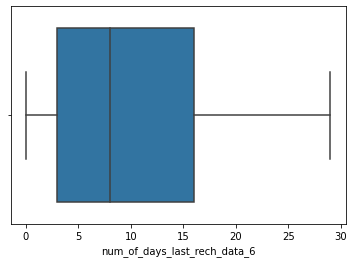

In [62]:
sns.boxplot(x='num_of_days_last_rech_data_6', data=churn_df)

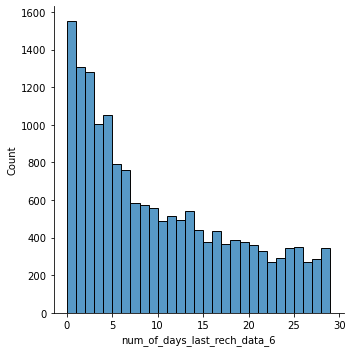

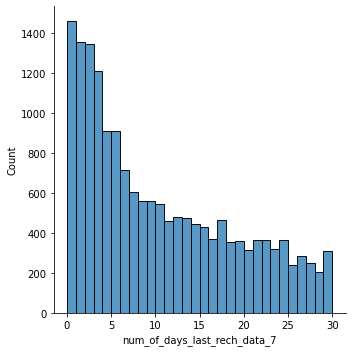

In [63]:
sns.displot(data=churn_df, x='num_of_days_last_rech_data_6', kind='hist')
sns.displot(data=churn_df, x='num_of_days_last_rech_data_7', kind='hist')

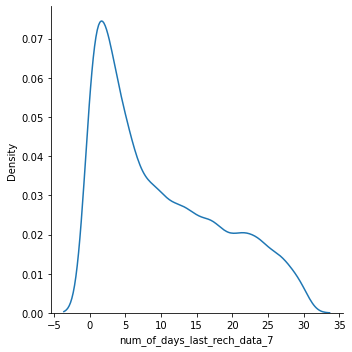

In [64]:
sns.displot(data=churn_df, x='num_of_days_last_rech_data_7', kind='kde')

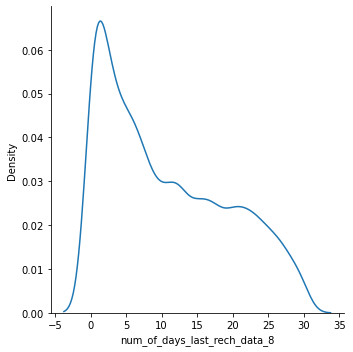

In [65]:
sns.displot(data=churn_df, x='num_of_days_last_rech_data_8', kind='kde')

In [66]:
churn_df[churn_df['num_of_days_last_rech_data_6'].isnull() & churn_df['num_of_days_last_rech_data_7'].isnull()]

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
7      1069.180  1349.850  3171.480        57.84        54.68        52.29   
21      514.453   597.753   637.760       102.41       132.11        85.14   
38      363.987   486.558   393.909       248.99       619.96       666.38   
41      482.832   425.764   229.769        86.39       118.88        80.44   
48     1873.271   575.927   179.218      2061.69       881.43       156.91   
...         ...       ...       ...          ...          ...          ...   
99924   457.827   416.103   389.400       105.11       103.01        95.66   
99937   351.397   429.744   312.262       530.53       696.33       512.99   
99939   398.308   834.643   203.506       553.84      1293.43       301.58   
99941   565.598   588.814   702.341       326.08       335.38       411.39   
99965   292.930   641.110   303.172        18.43        99.61         4.96   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
7            453.43        567.16        325.91          16.23          33.49   
21           757.93        896.68        983.39           0.00           0.00   
38            88.86         50.58         97.81           0.00           0.00   
41           232.36        280.78        136.69           0.00           0.00   
48          1087.76        258.29         68.18           0.00           0.00   
...             ...           ...           ...            ...            ...   
99924        346.76        291.23        262.41           0.00           0.00   
99937        305.69        456.34        337.16           0.00           0.00   
99939         29.14        102.33         19.69           0.00           0.00   
99941        929.68       1119.91        928.31           0.00           0.00   
99965        510.24       1123.56        462.19           0.00           0.00   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
7              31.64          23.74          12.59          38.06   
21              0.00           0.00           0.00           0.00   
38              0.00           0.00           0.00           0.00   
41              0.00           0.00           0.00           0.00   
48              0.00           0.00           0.00           0.00   
...              ...            ...            ...            ...   
99924           0.00           0.00           0.00           0.00   
99937           0.00           0.00           0.00           0.00   
99939           5.56           0.00           0.00          12.78   
99941           0.00           0.00           0.00           0.00   
99965           0.00           0.06           0.00           0.00   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
7                 51.39             31.38             40.28            308.63   
21                 4.48              6.16             23.34             91.81   
38                29.88             17.33              9.48             33.76   
41                86.39            118.88             80.44            142.69   
48               611.18            154.56             29.31           1012.04   
...                 ...               ...               ...               ...   
99924             66.21             76.76             94.19            318.59   
99937              1.93              0.40              3.79             22.43   
99939             13.44             32.74              2.59              7.76   
99941            326.08            335.38            406.34            910.24   
99965              0.00              0.00              0.00              7.49   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
7                447.38            162.28             62.13             55.14   
21                87.93            104.81              0.75              0.00   
38                16.19             18.96             

In [67]:
churn_df['night_pck_user_6'].value_counts(normalize=True)*100

0.0    97.568698
1.0     2.431302
Name: night_pck_user_6, dtype: float64

In [68]:
churn_df['night_pck_user_6'].fillna(0).value_counts(normalize=True)*100

0.0    98.641205
1.0     1.358795
Name: night_pck_user_6, dtype: float64

In [69]:
churn_df['night_pck_user_7'].value_counts(normalize=True)*100

0.0    97.799037
1.0     2.200963
Name: night_pck_user_7, dtype: float64

In [70]:
churn_df['night_pck_user_7'].fillna(0).value_counts(normalize=True)*100

0.0    98.748039
1.0     1.251961
Name: night_pck_user_7, dtype: float64

In [71]:
churn_df['night_pck_user_8'].value_counts(normalize=True)*100

0.0    97.860056
1.0     2.139944
Name: night_pck_user_8, dtype: float64

In [72]:
churn_df['night_pck_user_8'].fillna(0).value_counts(normalize=True)*100

0.0    98.86155
1.0     1.13845
Name: night_pck_user_8, dtype: float64

#### **Since almost 97.5% users do not avail night scheme and imputing the missing values with 0 makes only a difference of 1% in the distribution of the column, so we impute it with 0**

In [73]:
# imputing missing values with 0
churn_df['night_pck_user_6'].fillna(0, inplace=True)
churn_df['night_pck_user_7'].fillna(0, inplace=True)
churn_df['night_pck_user_8'].fillna(0, inplace=True)

**Exploring fb_user column**

In [74]:
churn_df['fb_user_6'].value_counts(normalize=True)*100

1.0    92.658303
0.0     7.341697
Name: fb_user_6, dtype: float64

In [75]:
churn_df['fb_user_6'].fillna(1).value_counts(normalize=True)*100

1.0    95.896905
0.0     4.103095
Name: fb_user_6, dtype: float64

In [76]:
churn_df['fb_user_7'].value_counts(normalize=True)*100

1.0    92.176312
0.0     7.823688
Name: fb_user_7, dtype: float64

In [77]:
churn_df['fb_user_7'].fillna(1).value_counts(normalize=True)*100

1.0    95.549695
0.0     4.450305
Name: fb_user_7, dtype: float64

In [78]:
churn_df['fb_user_8'].value_counts(normalize=True)*100

1.0    89.720741
0.0    10.279259
Name: fb_user_8, dtype: float64

In [79]:
churn_df['fb_user_8'].fillna(1).value_counts(normalize=True)*100

1.0    94.531433
0.0     5.468567
Name: fb_user_8, dtype: float64

#### **Since almost 90% users do avail fb services scheme and imputing the missing values with 1 makes only a difference of 3% in the distribution of the column, so we impute it with 1**

In [80]:
# imputing missing values with 1
churn_df['fb_user_6'].fillna(1, inplace=True)
churn_df['fb_user_7'].fillna(1, inplace=True)
churn_df['fb_user_8'].fillna(1, inplace=True)

In [81]:
data_missing_cols = get_data_missing_cols(churn_df)

max_rech_data_6 44.11
max_rech_data_7 43.12
max_rech_data_8 46.8
count_rech_2g_6 44.11
count_rech_2g_7 43.12
count_rech_2g_8 46.8
count_rech_3g_6 44.11
count_rech_3g_7 43.12
count_rech_3g_8 46.8
arpu_3g_6 44.11
arpu_3g_7 43.12
arpu_3g_8 46.8
arpu_2g_6 44.11
arpu_2g_7 43.12
arpu_2g_8 46.8
num_of_days_last_rech_6 0.24
num_of_days_last_rech_7 0.33
num_of_days_last_rech_8 1.94
num_of_days_last_rech_data_6 44.11
num_of_days_last_rech_data_7 43.12
num_of_days_last_rech_data_8 46.8


In [82]:
churn_df[churn_df['total_rech_data_6'] == 0][data_missing_cols]

max_rech_data_6  max_rech_data_7  max_rech_data_8  count_rech_2g_6  \
7                  NaN              NaN              NaN              NaN   
8                  NaN            154.0             23.0              NaN   
21                 NaN              NaN              NaN              NaN   
23                 NaN            179.0            179.0              NaN   
38                 NaN              NaN              NaN              NaN   
...                ...              ...              ...              ...   
99939              NaN              NaN              NaN              NaN   
99941              NaN              NaN              NaN              NaN   
99963              NaN             17.0              NaN              NaN   
99965              NaN              NaN              NaN              NaN   
99988              NaN            154.0            154.0              NaN   

       count_rech_2g_7  count_rech_2g_8  count_rech_3g_6  count_rech_3g_7  \
7                  NaN              NaN              NaN              NaN   
8                  2.0              3.0              NaN              0.0   
21                 NaN              NaN              NaN              NaN   
23                 0.0              0.0              NaN              2.0   
38                 NaN              NaN              NaN              NaN   
...                ...              ...              ...              ...   
99939              NaN              NaN              NaN              NaN   
99941              NaN              NaN              NaN              NaN   
99963              1.0              NaN              NaN              0.0   
99965              NaN              NaN              NaN              NaN   
99988              1.0              1.0              NaN              0.0   

       count_rech_3g_8  arpu_3g_6  arpu_3g_7  arpu_3g_8  arpu_2g_6  arpu_2g_7  \
7                  NaN        NaN        NaN        NaN        NaN        NaN   
8                  0.0        NaN       0.00      19.83        NaN       0.00   
21                 NaN        NaN        NaN        NaN        NaN        NaN   
23                 2.0        NaN     306.57     197.27        NaN     301.78   
38                 NaN        NaN        NaN        NaN        NaN        NaN   
...                ...        ...        ...        ...        ...        ...   
99939              NaN        NaN        NaN        NaN        NaN        NaN   
99941              NaN        NaN        NaN        NaN        NaN        NaN   
99963              NaN        NaN       0.00        NaN        NaN      27.70   
99965              NaN        NaN        NaN        NaN        NaN        NaN   
99988              0.0        NaN       0.00       5.44        NaN       0.00   

       arpu_2g_8  
7            NaN  
8           0.00  
21           NaN  
23        150.67  
38           NaN  
...          ...  
99939        NaN  
99941        NaN  
99963        NaN  
99965        NaN  
99988       0.00  

[13213 rows x 15 columns]

#### **Observation: On exploring all the data related columns, we have found that columns that have their their total_rech_data_amt as 0 have all their other data related columns value as NaN, so we will impute these with 0 as it makes sense that customers who have not recharged data will have other data usage columns as 0**

In [83]:
data_missing_cols_6 = get_cols(churn_df[data_missing_cols], '_6')
print(data_missing_cols_6)
churn_df.loc[churn_df['total_rech_data_amt_6'] == 0, data_missing_cols_6] = churn_df[churn_df['total_rech_data_amt_6'] == 0][data_missing_cols_6].fillna(0)

['max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'arpu_3g_6', 'arpu_2g_6']


In [84]:
data_missing_cols_7 = get_cols(churn_df[data_missing_cols], '_7')
print(data_missing_cols_7)
churn_df.loc[churn_df['total_rech_data_amt_7'] == 0, data_missing_cols_7] = churn_df[churn_df['total_rech_data_amt_7'] == 0][data_missing_cols_7].fillna(0)

['max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'arpu_3g_7', 'arpu_2g_7']


In [85]:
data_missing_cols_8 = get_cols(churn_df[data_missing_cols], '_8')
print(data_missing_cols_8)
churn_df.loc[churn_df['total_rech_data_amt_8'] == 0, data_missing_cols_8] = churn_df[churn_df['total_rech_data_amt_8'] == 0][data_missing_cols_8].fillna(0)

['max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'arpu_3g_8', 'arpu_2g_8']


In [86]:
print_missing_val_percent_in_cols(churn_df[find_missing_val_cols(churn_df)])

num_of_days_last_rech_6: 0.24
num_of_days_last_rech_7: 0.33
num_of_days_last_rech_8: 1.94
num_of_days_last_rech_data_6: 44.11
num_of_days_last_rech_data_7: 43.12
num_of_days_last_rech_data_8: 46.8


In [87]:
churn_df[churn_df['total_rech_data_amt_6'] == 0]['total_rech_data_amt_6'].count() / len(churn_df)

0.4411244282709578

In [88]:
churn_df[churn_df['total_rech_data_amt_7'] == 0]['total_rech_data_amt_7'].count() / len(churn_df)

0.43117550829633094

In [89]:
churn_df[churn_df['total_rech_data_amt_8'] == 0]['total_rech_data_amt_8'].count() / len(churn_df)

0.46799986645745

<AxesSubplot:xlabel='num_of_days_last_rech_data_6'>

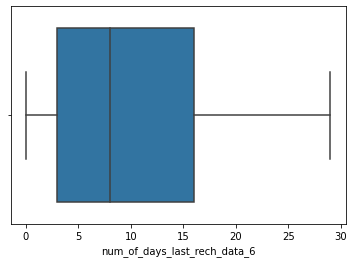

In [90]:
sns.boxplot(data=churn_df, x='num_of_days_last_rech_data_6')

<AxesSubplot:>

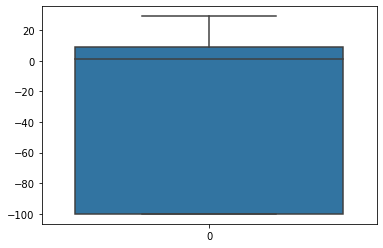

In [91]:
sns.boxplot(data=churn_df['num_of_days_last_rech_data_6'].fillna(-100))

<AxesSubplot:>

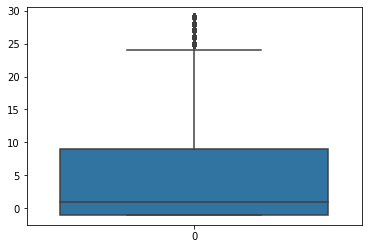

In [92]:
sns.boxplot(data=churn_df['num_of_days_last_rech_data_6'].fillna(-1))

**Observation: number of days since last data recharge columns have around 45% missing values and imputing them with either median/mode goes against the business logic as those customers have never recharged data and imputing with some representationa value like negative numbers highly skews the data as evident above, so we decide to drop this column**

In [93]:
# dropping the number of days since last data recharge columns
churn_df.drop(['num_of_days_last_rech_data_6', 'num_of_days_last_rech_data_7', 'num_of_days_last_rech_data_8'], axis=1, inplace=True)
churn_df.shape

(29953, 162)

In [94]:
churn_df[churn_df['total_rech_amt_6'] == 0]['total_rech_amt_6'].count() / len(churn_df) *100

1.8128401161820185

In [95]:
churn_df[churn_df['total_rech_amt_6'] == 0 & ~(churn_df['num_of_days_last_rech_6'].isnull())][get_cols(churn_df, '_6')]

arpu_6  onnet_mou_6  offnet_mou_6  roam_ic_mou_6  roam_og_mou_6  \
23      74.35        48.96         85.41           0.00            0.0   
77      30.00         0.00          0.00           0.00            0.0   
91       4.00         0.00          0.00           0.00            0.0   
242     44.56        20.11         16.23           0.00            0.0   
364      0.00         0.00          0.00           0.00            0.0   
...       ...          ...           ...            ...            ...   
99398   10.50         0.00          6.60           0.00            0.0   
99567   63.37         3.58         27.49          76.96            2.6   
99611    0.00         0.00          0.00           0.00            0.0   
99724    0.11         0.00         10.53           0.00            0.0   
99858   12.00         2.20          6.23           0.00            0.0   

       loc_og_t2t_mou_6  loc_og_t2m_mou_6  loc_og_t2f_mou_6  loc_og_t2c_mou_6  \
23                48.96             82.94               0.0              0.00   
77                 0.00              0.00               0.0              0.00   
91                 0.00              0.00               0.0              0.00   
242                3.33             15.03               0.0              0.46   
364                0.00              0.00               0.0              0.00   
...                 ...               ...               ...               ...   
99398              0.00              6.60               0.0              0.00   
99567              3.58             18.18               0.0              0.00   
99611              0.00              0.00               0.0              0.00   
99724              0.00             10.53               0.0              0.00   
99858              2.20              4.43               0.0              0.00   

       loc_og_mou_6  std_og_t2t_mou_6  std_og_t2m_mou_6  std_og_t2f_mou_6  \
23           131.91              0.00              2.36              0.00   
77             0.00              0.00              0.00              0.00   
91             0.00              0.00              0.00              0.00   
242           18.36             16.78              0.73              0.00   
364            0.00              0.00              0.00              0.00   
...             ...               ...               ...               ...   
99398          6.60              0.00              0.00              0.00   
99567         21.76              0.00              1.26              5.45   
99611          0.00              0.00              0.00              0.00   
99724         10.53              0.00              0.00              0.00   
99858          6.63              0.00              1.80              0.00   

       std_og_mou_6  isd_og_mou_6  spl_og_mou_6  og_others_6  total_og_mou_6  \
23             2.36           0.0          0.10         0.00          134.38   
77             0.00           0.0          0.00         0.00            0.00   
91             0.00           0.0          0.00         0.00            0.00   
242           17.51           0.0          0.46         0.00           36.34   
364            0.00           0.0          0.00         0.00            0.00   
...             ...           ...           ...          ...             ...   
99398          0.00           0.0          0.00         0.00            6.60   
99567          6.71           0.0          0.00         0.00           28.48   
99611          0.00           0.0          0.00         0.00            0.00   
99724          0.00           0.0          0.64         0.76           11.94   
99858          1.80           0.0          0.00         0.00            8.43   

       loc_ic_t2t_mou_6  loc_ic_t2m_mou_6  loc_ic_t2f_mou_6  loc_ic_mou_6  \
23                20.71             95.91              0.00        116.63   
77                 0.00              0.00              0.00          0.00   
91                11.24     

In [96]:
churn_df[churn_df['num_of_days_last_rech_6'].isnull()][get_cols(churn_df, '_6')]

arpu_6  onnet_mou_6  offnet_mou_6  roam_ic_mou_6  roam_og_mou_6  \
91        4.00         0.00          0.00            0.0            0.0   
414      20.00         0.00          0.00            0.0            0.0   
6319      0.00         0.00          0.00            0.0            0.0   
8125      0.00         0.00          0.00            0.0            0.0   
8975      0.00         0.00          0.00            0.0            0.0   
...        ...          ...           ...            ...            ...   
97379    20.00         0.00          0.00            0.0            0.0   
98121     0.00         0.00          0.00            0.0            0.0   
98823     0.00         0.00          0.00            0.0            0.0   
99224  1187.48       584.14       1368.78            0.0            0.0   
99398    10.50         0.00          6.60            0.0            0.0   

       loc_og_t2t_mou_6  loc_og_t2m_mou_6  loc_og_t2f_mou_6  loc_og_t2c_mou_6  \
91                 0.00              0.00              0.00               0.0   
414                0.00              0.00              0.00               0.0   
6319               0.00              0.00              0.00               0.0   
8125               0.00              0.00              0.00               0.0   
8975               0.00              0.00              0.00               0.0   
...                 ...               ...               ...               ...   
97379              0.00              0.00              0.00               0.0   
98121              0.00              0.00              0.00               0.0   
98823              0.00              0.00              0.00               0.0   
99224            270.64            913.59             16.43               0.0   
99398              0.00              6.60              0.00               0.0   

       loc_og_mou_6  std_og_t2t_mou_6  std_og_t2m_mou_6  std_og_t2f_mou_6  \
91             0.00              0.00              0.00               0.0   
414            0.00              0.00              0.00               0.0   
6319           0.00              0.00              0.00               0.0   
8125           0.00              0.00              0.00               0.0   
8975           0.00              0.00              0.00               0.0   
...             ...               ...               ...               ...   
97379          0.00              0.00              0.00               0.0   
98121          0.00              0.00              0.00               0.0   
98823          0.00              0.00              0.00               0.0   
99224       1200.68            313.49            438.48               0.0   
99398          6.60              0.00              0.00               0.0   

       std_og_mou_6  isd_og_mou_6  spl_og_mou_6  og_others_6  total_og_mou_6  \
91             0.00           0.0          0.00          0.0            0.00   
414            0.00           0.0          0.00          0.0            0.00   
6319           0.00           0.0          0.00          0.0            0.00   
8125           0.00           0.0          0.00          0.0            0.00   
8975           0.00           0.0          0.00          0.0            0.00   
...             ...           ...           ...          ...             ...   
97379          0.00           0.0          0.00          0.0            0.00   
98121          0.00           0.0          0.00          0.0            0.00   
98823          0.00           0.0          0.00          0.0            0.00   
99224        751.98           0.0          0.26          0.0         1952.93   
99398          0.00           0.0          0.00          0.0            6.60   

       loc_ic_t2t_mou_6  loc_ic_t2m_mou_6  loc_ic_t2f_mou_6  loc_ic_mou_6  \
91                11.24            145.13              1.26        157.64   
414                0.00              0.00              0.00          0.00   
6319             

<AxesSubplot:xlabel='num_of_days_last_rech_6'>

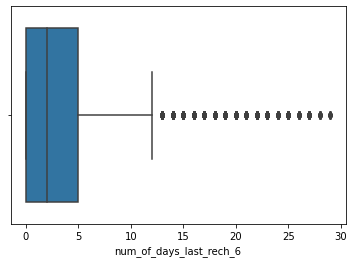

In [97]:
sns.boxplot(data=churn_df, x='num_of_days_last_rech_6')

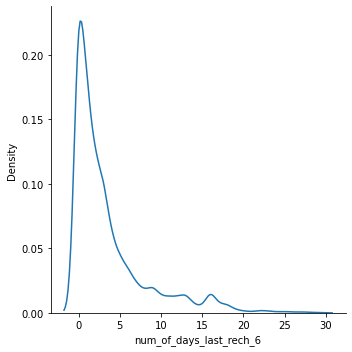

In [98]:
sns.displot(data=churn_df, x='num_of_days_last_rech_6', kind='kde')

In [99]:
churn_df['num_of_days_last_rech_6'].value_counts()

0.0     8365
1.0     5327
2.0     3661
3.0     3155
4.0     1823
5.0     1323
6.0     1041
7.0      697
9.0      638
16.0     549
8.0      525
13.0     454
10.0     397
12.0     387
11.0     387
18.0     211
17.0     210
14.0     203
15.0     141
19.0      81
22.0      60
23.0      47
20.0      47
25.0      33
21.0      27
27.0      25
24.0      24
26.0      19
28.0      13
29.0      10
Name: num_of_days_last_rech_6, dtype: int64

<AxesSubplot:xlabel='num_of_days_last_rech_7'>

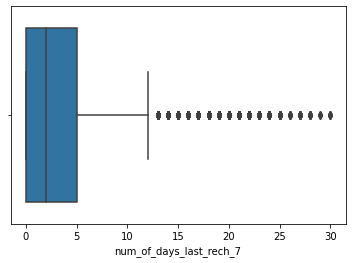

In [100]:
sns.boxplot(data=churn_df, x='num_of_days_last_rech_7')

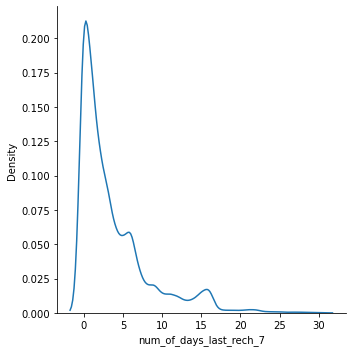

In [101]:
sns.displot(data=churn_df, x='num_of_days_last_rech_7', kind='kde')

In [102]:
churn_df['num_of_days_last_rech_7'].value_counts()

0.0     7605
1.0     5276
2.0     3472
3.0     2784
6.0     1922
4.0     1786
5.0     1600
7.0      926
9.0      650
16.0     587
8.0      563
15.0     457
11.0     421
10.0     390
12.0     365
14.0     291
13.0     251
21.0      72
22.0      71
17.0      71
19.0      59
18.0      55
20.0      51
23.0      25
24.0      25
25.0      23
27.0      17
28.0      14
26.0      12
30.0       9
29.0       5
Name: num_of_days_last_rech_7, dtype: int64

<AxesSubplot:xlabel='num_of_days_last_rech_8'>

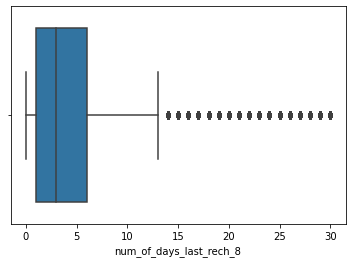

In [103]:
sns.boxplot(data=churn_df, x='num_of_days_last_rech_8')

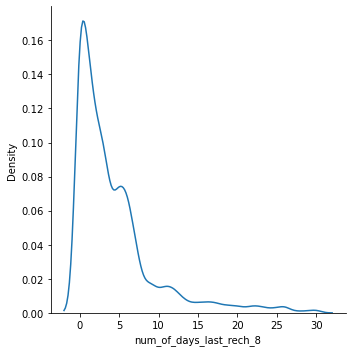

In [104]:
sns.displot(data=churn_df, x='num_of_days_last_rech_8', kind='kde')

In [105]:
churn_df['num_of_days_last_rech_8'].value_counts()

0.0     6191
1.0     4626
2.0     3357
3.0     3050
5.0     2284
6.0     2164
4.0     1851
7.0     1308
9.0      535
8.0      506
11.0     491
12.0     428
10.0     393
13.0     262
16.0     193
17.0     191
15.0     181
14.0     172
18.0     141
22.0     133
19.0     131
26.0     130
20.0     123
23.0     113
25.0      92
21.0      89
24.0      76
30.0      60
29.0      37
27.0      33
28.0      30
Name: num_of_days_last_rech_8, dtype: int64

#### Observation: On exploring the data we can say that number of days are missing for those where the total recharge is 0. In other words, since no recharge was done in that month, hence the value is set to NaN.

##### To fill the missing values for month 7 and month 8, we can find if the last recharge information from previous months and do necessary computation
- num days since last recharge of previous month + number of days of current month

In [106]:
churn_df[churn_df['num_of_days_last_rech_7'].isna() & churn_df['num_of_days_last_rech_6'].isna()]

Empty DataFrame
Columns: [arpu_6, arpu_7, arpu_8, onnet_mou_6, onnet_mou_7, onnet_mou_8, offnet_mou_6, offnet_mou_7, offnet_mou_8, roam_ic_mou_6, roam_ic_mou_7, roam_ic_mou_8, roam_og_mou_6, roam_og_mou_7, roam_og_mou_8, loc_og_t2t_mou_6, loc_og_t2t_mou_7, loc_og_t2t_mou_8, loc_og_t2m_mou_6, loc_og_t2m_mou_7, loc_og_t2m_mou_8, loc_og_t2f_mou_6, loc_og_t2f_mou_7, loc_og_t2f_mou_8, loc_og_t2c_mou_6, loc_og_t2c_mou_7, loc_og_t2c_mou_8, loc_og_mou_6, loc_og_mou_7, loc_og_mou_8, std_og_t2t_mou_6, std_og_t2t_mou_7, std_og_t2t_mou_8, std_og_t2m_mou_6, std_og_t2m_mou_7, std_og_t2m_mou_8, std_og_t2f_mou_6, std_og_t2f_mou_7, std_og_t2f_mou_8, std_og_mou_6, std_og_mou_7, std_og_mou_8, isd_og_mou_6, isd_og_mou_7, isd_og_mou_8, spl_og_mou_6, spl_og_mou_7, spl_og_mou_8, og_others_6, og_others_7, og_others_8, total_og_mou_6, total_og_mou_7, total_og_mou_8, loc_ic_t2t_mou_6, loc_ic_t2t_mou_7, loc_ic_t2t_mou_8, loc_ic_t2m_mou_6, loc_ic_t2m_mou_7, loc_ic_t2m_mou_8, loc_ic_t2f_mou_6, loc_ic_t2f_mou_7, loc_ic_t2f_mou_8, loc_ic_mou_6, loc_ic_mou_7, loc_ic_mou_8, std_ic_t2t_mou_6, std_ic_t2t_mou_7, std_ic_t2t_mou_8, std_ic_t2m_mou_6, std_ic_t2m_mou_7, std_ic_t2m_mou_8, std_ic_t2f_mou_6, std_ic_t2f_mou_7, std_ic_t2f_mou_8, std_ic_mou_6, std_ic_mou_7, std_ic_mou_8, total_ic_mou_6, total_ic_mou_7, total_ic_mou_8, spl_ic_mou_6, spl_ic_mou_7, spl_ic_mou_8, isd_ic_mou_6, isd_ic_mou_7, isd_ic_mou_8, ic_others_6, ic_others_7, ic_others_8, total_rech_num_6, total_rech_num_7, total_rech_num_8, total_rech_amt_6, total_rech_amt_7, total_rech_amt_8, max_rech_amt_6, max_rech_amt_7, max_rech_amt_8, last_day_rch_amt_6, ...]
Index: []

We observe that there are no rows where both last_rech_7 and last_rech_6 are missing

In [107]:
churn_df.loc[churn_df['num_of_days_last_rech_7'].isna(), 'num_of_days_last_rech_7']

603     NaN
679     NaN
1374    NaN
1555    NaN
2777    NaN
         ..
93483   NaN
96387   NaN
96715   NaN
96975   NaN
99851   NaN
Name: num_of_days_last_rech_7, Length: 98, dtype: float64

In [108]:
churn_df.loc[churn_df['num_of_days_last_rech_7'].isna(), 'num_of_days_last_rech_7'] = churn_df.loc[churn_df['num_of_days_last_rech_7'].isna(), 'num_of_days_last_rech_6']+31 

In [109]:
churn_df[churn_df['num_of_days_last_rech_7'].isna()]['num_of_days_last_rech_7'] 

Series([], Name: num_of_days_last_rech_7, dtype: float64)

In [110]:
churn_df.loc[churn_df['num_of_days_last_rech_8'].isna(), 'num_of_days_last_rech_8'] = churn_df.loc[churn_df['num_of_days_last_rech_8'].isna(), 'num_of_days_last_rech_7']+31 

In [111]:
churn_df[churn_df['num_of_days_last_rech_8'].isna()]['num_of_days_last_rech_8'] 

Series([], Name: num_of_days_last_rech_8, dtype: float64)

#### For month 6, 
###### Approach 1
we are assuming that there was some recharge done last month, but no recharge this month, so we take the median for 6th month and add 30 (number of days in month 6) to it to get a close approximation.
- Since median is a statistical imputation, we will need do this imputation after train test split
- This may not be accurate since ideally we should be getting month 5 data

###### Approach 2
dropping the rows which have this information missing.
- there are 0.24% missing values or about 72 such rows, hence dropping these rows won't make much of a difference

##### For now, we will use Approach 2

In [112]:
churn_df.shape

(29953, 162)

In [113]:
churn_df = churn_df[churn_df['num_of_days_last_rech_6'].notna()]

In [114]:
churn_df.shape

(29880, 162)

In [115]:
# printing the percentage of missing values in the data
print_missing_val_percent_in_cols(churn_df)

arpu_6: 0.0
arpu_7: 0.0
arpu_8: 0.0
onnet_mou_6: 0.0
onnet_mou_7: 0.0
onnet_mou_8: 0.0
offnet_mou_6: 0.0
offnet_mou_7: 0.0
offnet_mou_8: 0.0
roam_ic_mou_6: 0.0
roam_ic_mou_7: 0.0
roam_ic_mou_8: 0.0
roam_og_mou_6: 0.0
roam_og_mou_7: 0.0
roam_og_mou_8: 0.0
loc_og_t2t_mou_6: 0.0
loc_og_t2t_mou_7: 0.0
loc_og_t2t_mou_8: 0.0
loc_og_t2m_mou_6: 0.0
loc_og_t2m_mou_7: 0.0
loc_og_t2m_mou_8: 0.0
loc_og_t2f_mou_6: 0.0
loc_og_t2f_mou_7: 0.0
loc_og_t2f_mou_8: 0.0
loc_og_t2c_mou_6: 0.0
loc_og_t2c_mou_7: 0.0
loc_og_t2c_mou_8: 0.0
loc_og_mou_6: 0.0
loc_og_mou_7: 0.0
loc_og_mou_8: 0.0
std_og_t2t_mou_6: 0.0
std_og_t2t_mou_7: 0.0
std_og_t2t_mou_8: 0.0
std_og_t2m_mou_6: 0.0
std_og_t2m_mou_7: 0.0
std_og_t2m_mou_8: 0.0
std_og_t2f_mou_6: 0.0
std_og_t2f_mou_7: 0.0
std_og_t2f_mou_8: 0.0
std_og_mou_6: 0.0
std_og_mou_7: 0.0
std_og_mou_8: 0.0
isd_og_mou_6: 0.0
isd_og_mou_7: 0.0
isd_og_mou_8: 0.0
spl_og_mou_6: 0.0
spl_og_mou_7: 0.0
spl_og_mou_8: 0.0
og_others_6: 0.0
og_others_7: 0.0
og_others_8: 0.0
total_og_mou_6: 

##### All missing values have been dealt with

---

## Data Visualization and EDA

In [116]:
col_large_unique, col_small_unique = divide_columns_based_on_number_of_unique_values(churn_df, 20)

more than 20 unique values:
list: ['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t

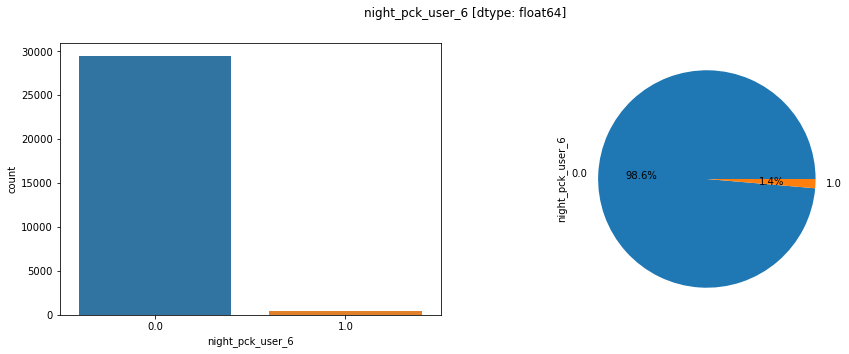

0.0    29473
1.0      407




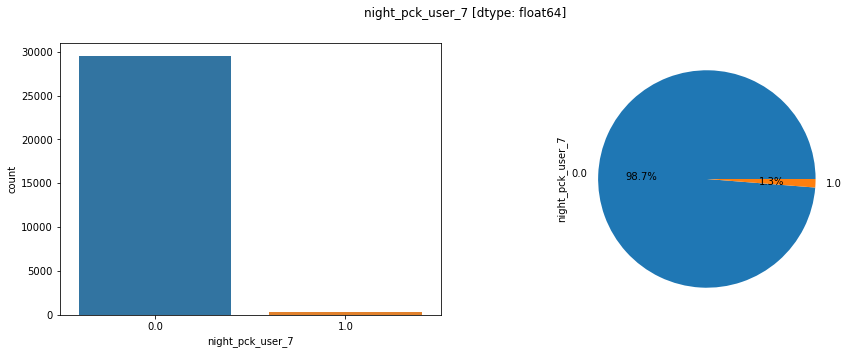

0.0    29505
1.0      375




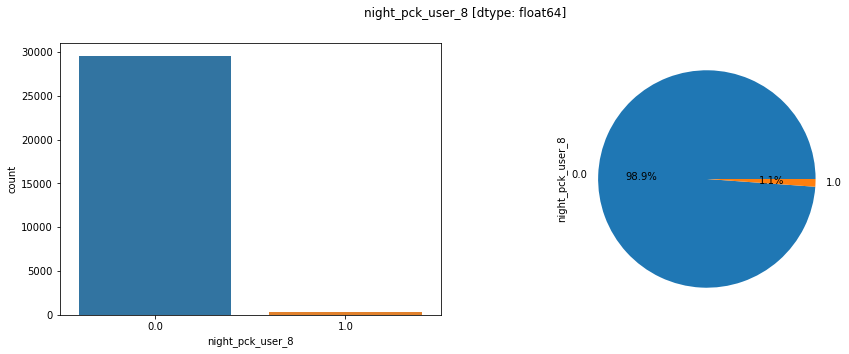

0.0    29539
1.0      341




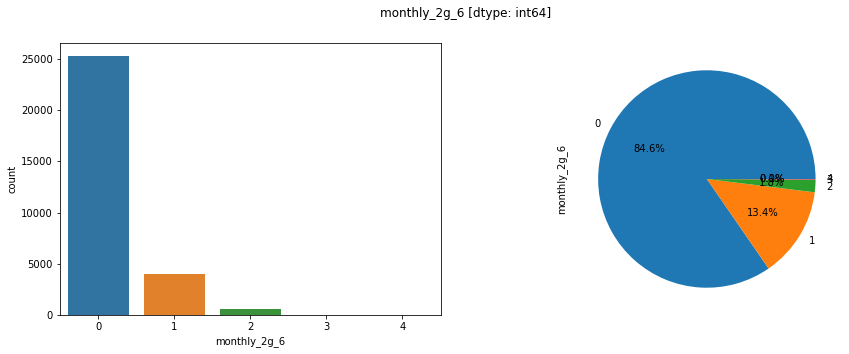

0    25282
1     4012
2      551
3       28
4        7




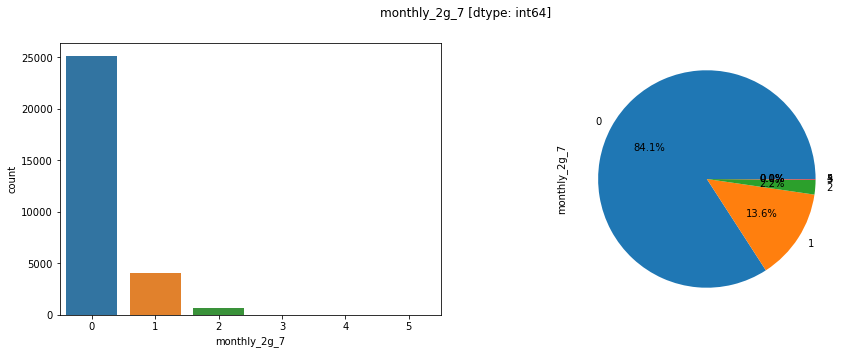

0    25138
1     4056
2      646
3       33
4        5
5        2




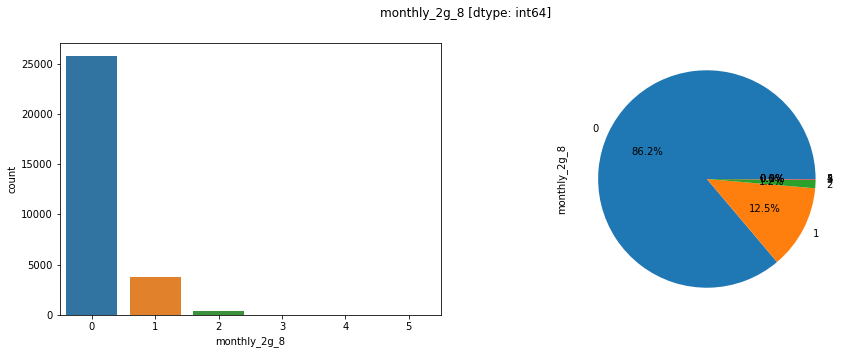

0    25748
1     3724
2      369
3       30
4        7
5        2




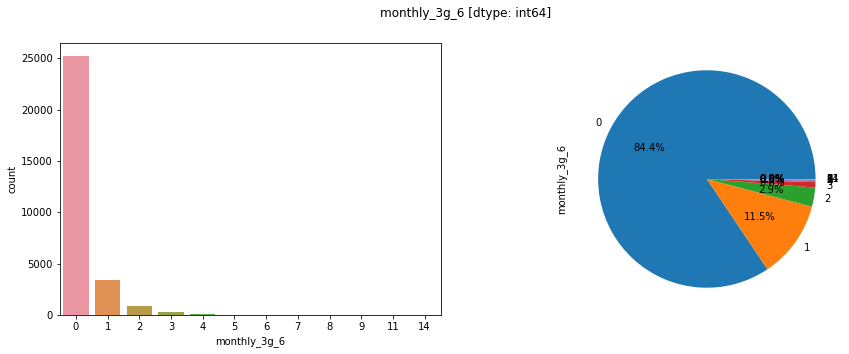

0     25222
1      3430
2       852
3       237
4        76
5        34
6        12
7         9
8         3
9         2
11        2
14        1




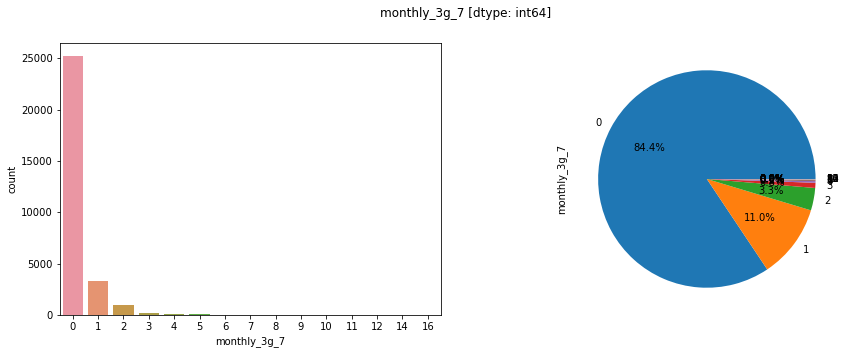

0     25210
1      3279
2       997
3       227
4        74
5        42
6        26
7        10
8         5
9         4
11        2
16        1
10        1
12        1
14        1




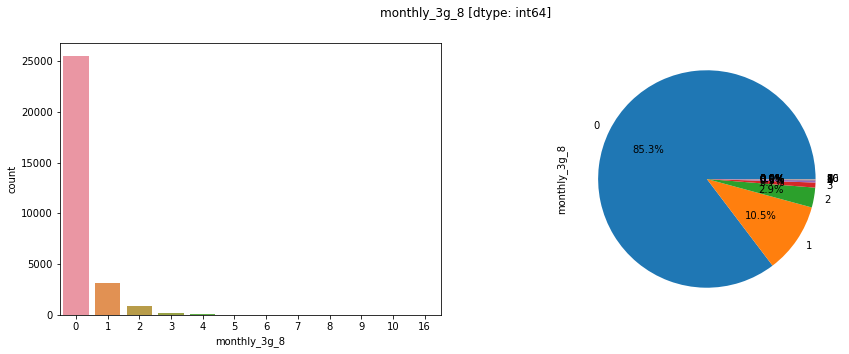

0     25496
1      3124
2       881
3       224
4        91
5        32
6        14
7         9
8         3
9         3
10        2
16        1




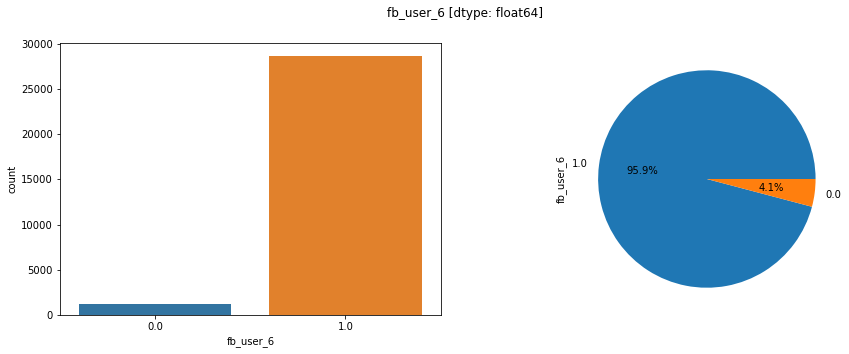

1.0    28651
0.0     1229




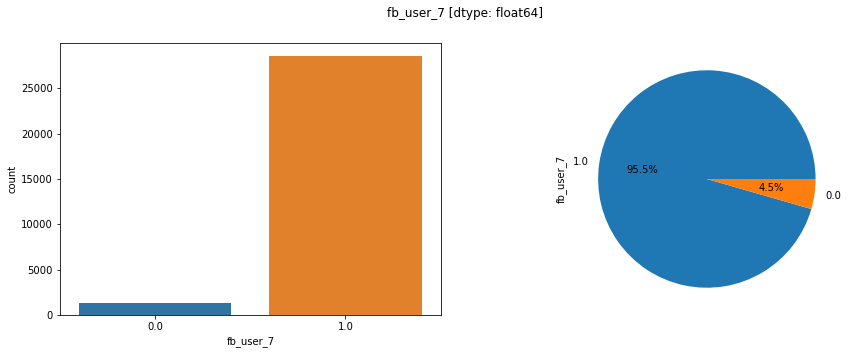

1.0    28549
0.0     1331




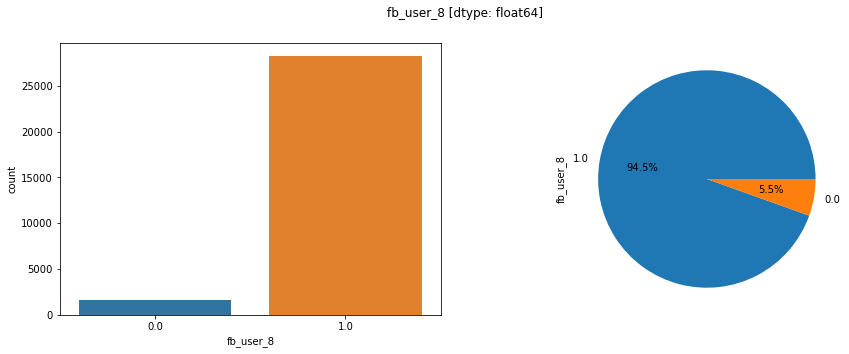

1.0    28244
0.0     1636




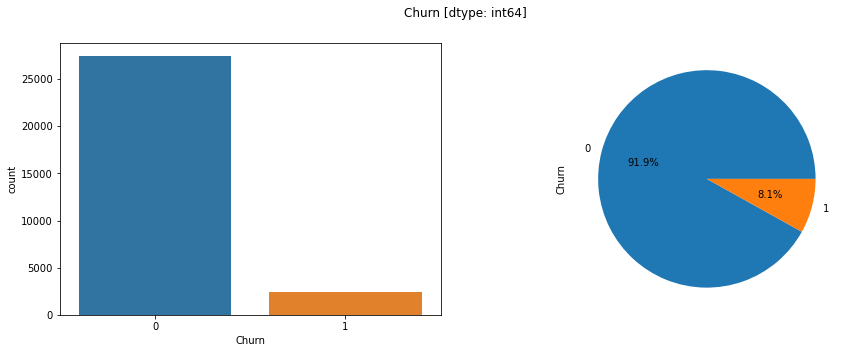

0    27464
1     2416




In [117]:
for col in col_small_unique:
    plot_small(churn_df, col)
    print('\n')

#### Observation
- Most users don't use night packs
- Most users use FB & related services
- About 12% users purchase 2g and 3g data pack once
- About 2% users purchase 2g pack 2 times
- About 3% users puchase 3g pack 2 times
- There is high class imbalance in the Churn column

In [118]:
month_six_cols = get_cols(churn_df, '_6')

In [119]:
more_unique_cols_6, less_unique_cols_6 = divide_columns_based_on_number_of_unique_values(churn_df[month_six_cols], 20)

more than 20 unique values:
list: ['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'arpu_3g_6', 'arpu_2g_6', 'sachet_2g_6', 'sachet_3g_6', 'vbc_3g_6', 'total_rech_data_amt_6', 'total_rech_call_plus_data_6', 'num_of_days_last_rech_6'] 
total columns: 49

less than 20 unique values:
list: ['night_pck_user_6', 

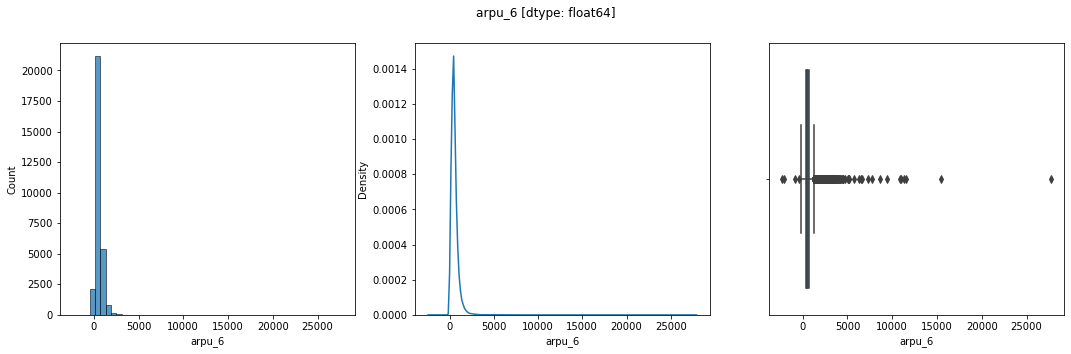

count    29880.000000
mean       559.798016
std        460.581727
min      -2258.709000
25%        311.311750
50%        482.909000
75%        700.725250
max      27731.088000





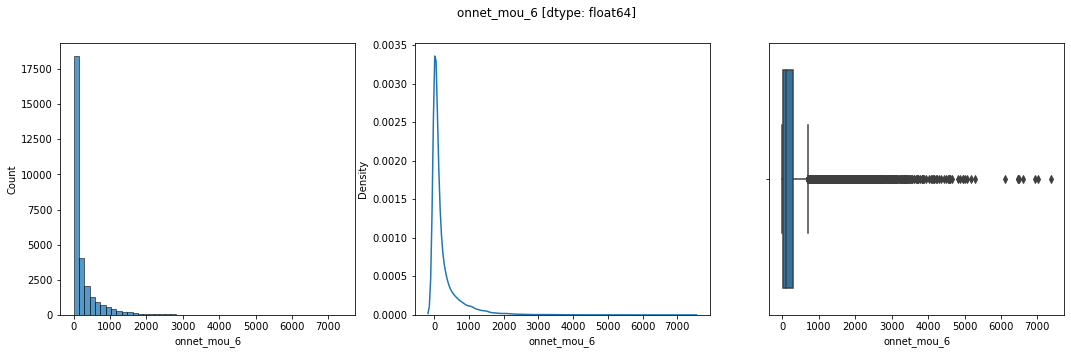

count    29880.000000
mean       261.377105
std        460.179726
min          0.000000
25%         17.360000
50%         85.000000
75%        291.012500
max       7376.710000





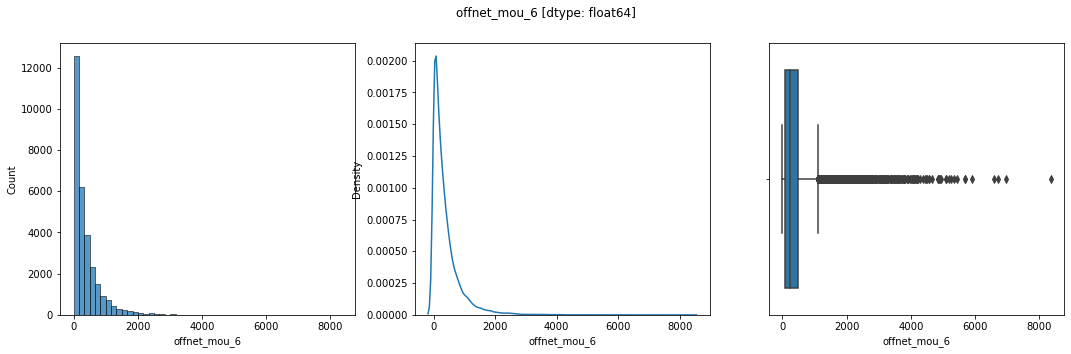

count    29880.000000
mean       374.399754
std        482.758185
min          0.000000
25%         72.390000
50%        223.300000
75%        488.332500
max       8362.360000





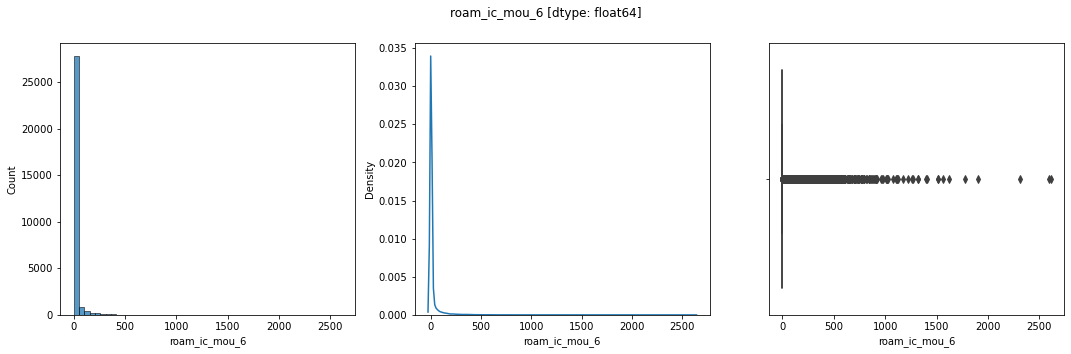

count    29880.000000
mean        16.162397
std         76.433430
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2613.310000





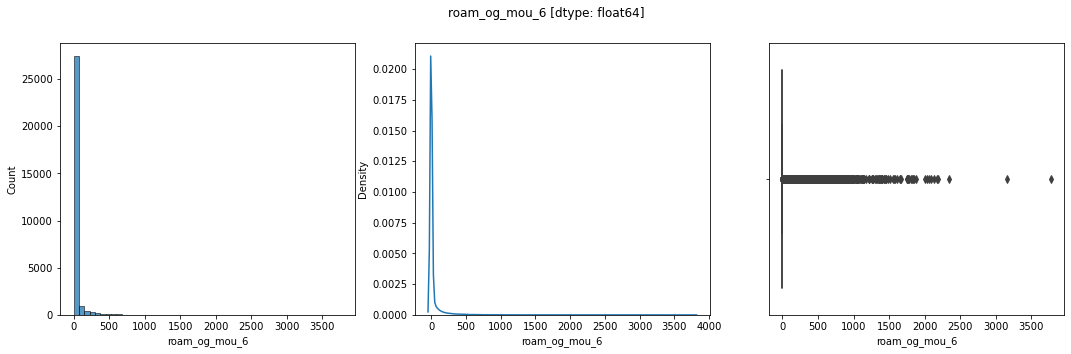

count    29880.000000
mean        26.655949
std        116.408708
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3775.110000





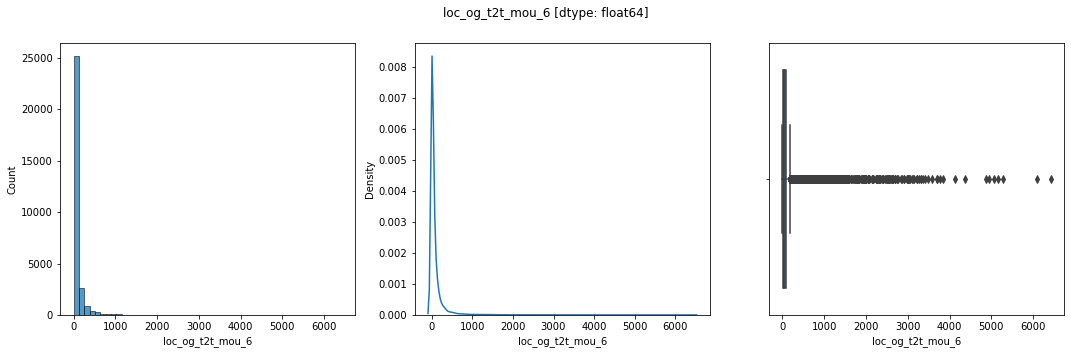

count    29880.000000
mean        84.724156
std        229.189461
min          0.000000
25%          4.430000
50%         24.480000
75%         78.330000
max       6431.330000





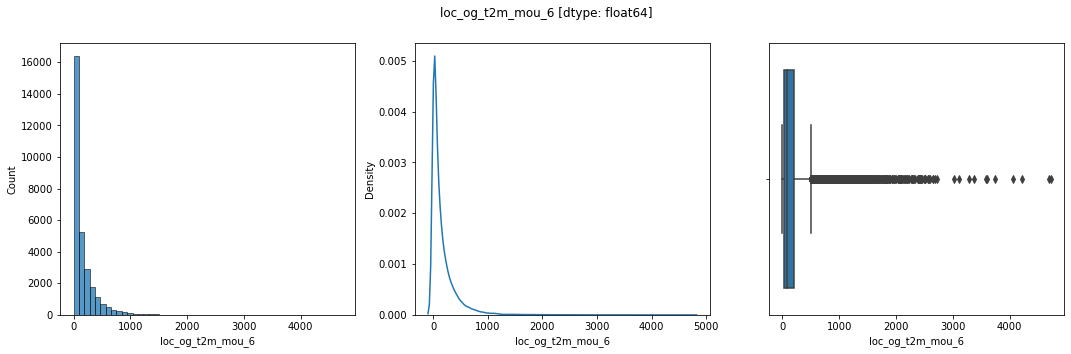

count    29880.000000
mean       163.534006
std        250.201026
min          0.000000
25%         19.360000
50%         77.540000
75%        209.210000
max       4729.740000





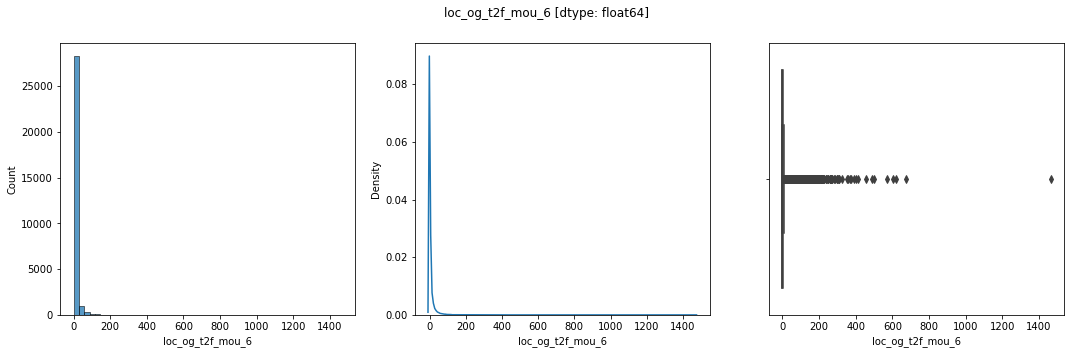

count    29880.000000
mean         6.361467
std         22.164269
min          0.000000
25%          0.000000
50%          0.000000
75%          4.230000
max       1466.030000





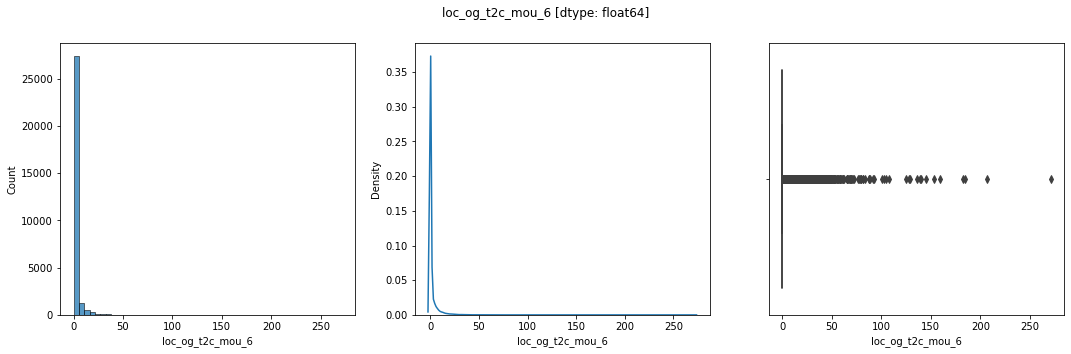

count    29880.000000
mean         1.579377
std          6.312634
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        271.440000





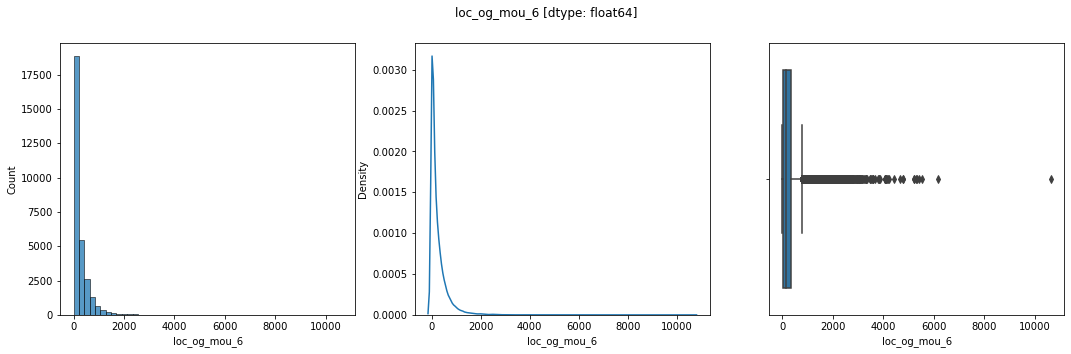

count    29880.000000
mean       254.627869
std        378.599296
min          0.000000
25%         32.580000
50%        125.110000
75%        332.787500
max      10643.380000





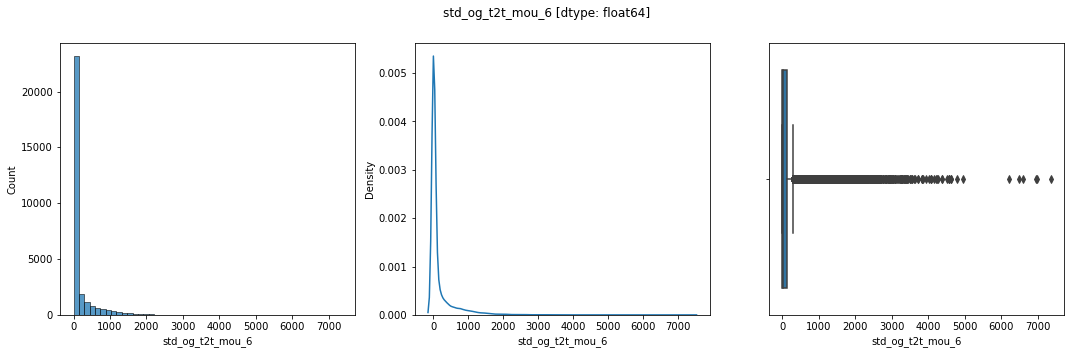

count    29880.000000
mean       166.199751
std        404.355113
min          0.000000
25%          0.000000
50%          2.780000
75%        110.182500
max       7366.580000





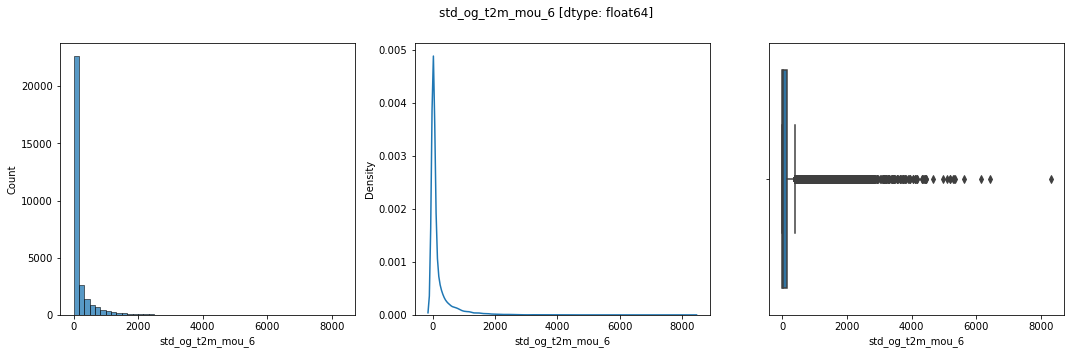

count    29880.000000
mean       179.748798
std        409.471385
min          0.000000
25%          0.000000
50%         16.510000
75%        154.767500
max       8314.760000





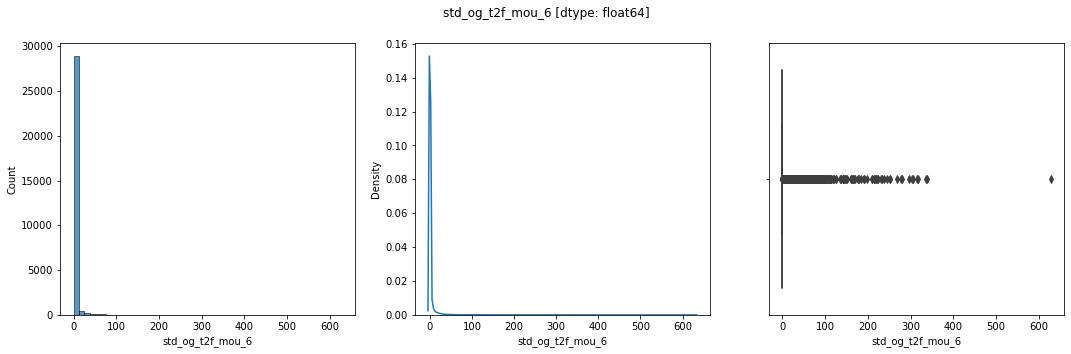

count    29880.000000
mean         1.809756
std         12.002856
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        628.560000





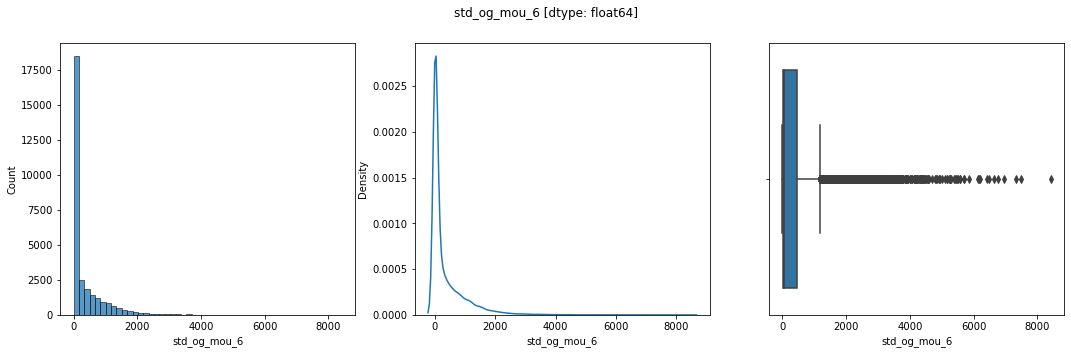

count    29880.000000
mean       347.762034
std        609.199686
min          0.000000
25%          0.410000
50%         45.730000
75%        466.395000
max       8432.990000





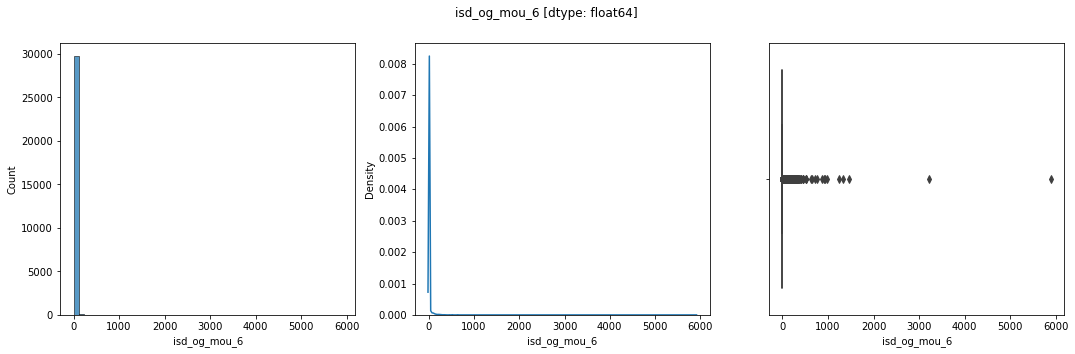

count    29880.000000
mean         2.179048
std         45.944310
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       5900.660000





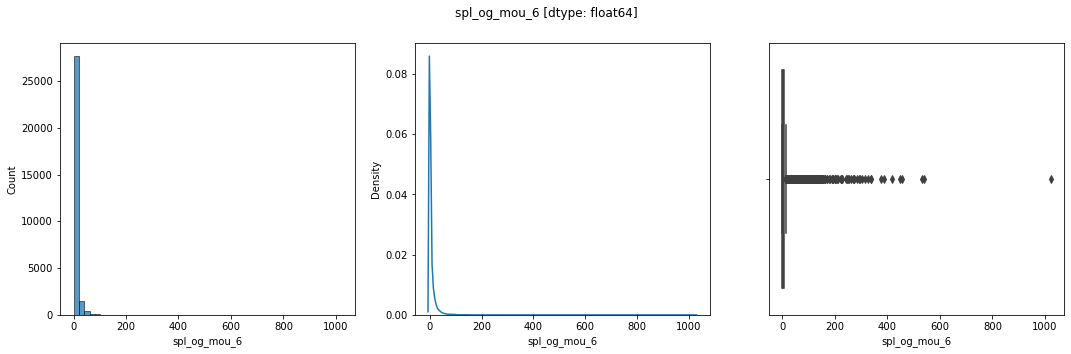

count    29880.000000
mean         5.836189
std         17.597618
min          0.000000
25%          0.000000
50%          0.230000
75%          5.230000
max       1023.210000





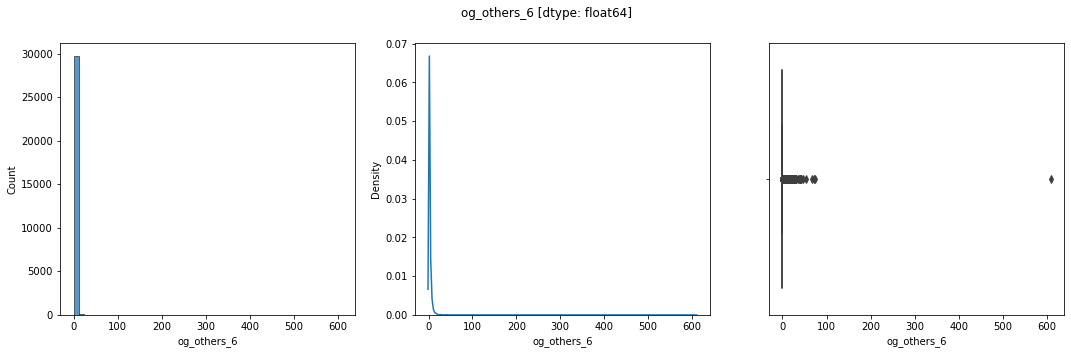

count    29880.000000
mean         0.663149
std          4.115803
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        609.810000





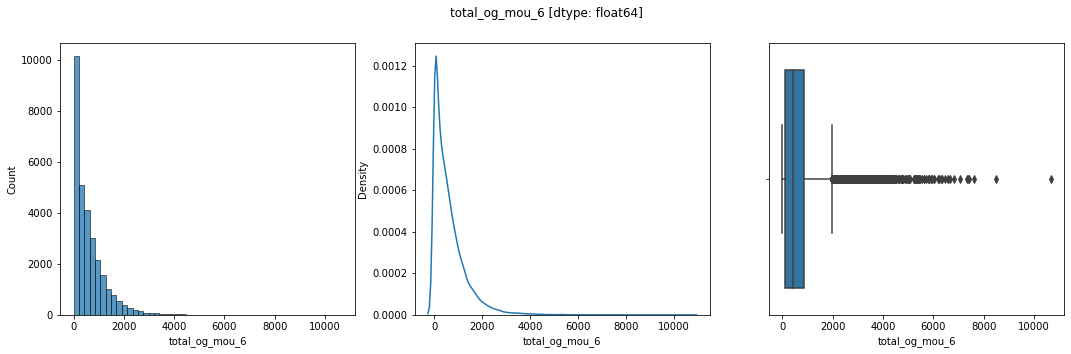

count    29880.000000
mean       611.077332
std        691.064405
min          0.000000
25%        118.205000
50%        412.015000
75%        860.037500
max      10674.030000





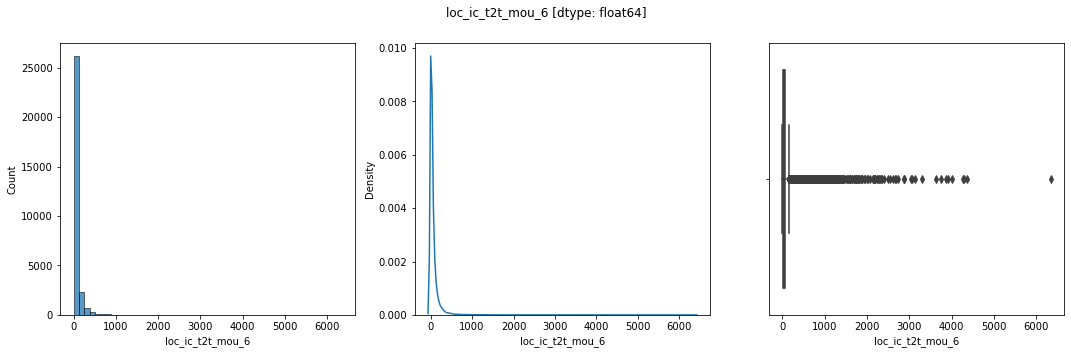

count    29880.000000
mean        65.659679
std        164.025296
min          0.000000
25%          6.180000
50%         25.180000
75%         67.687500
max       6351.440000





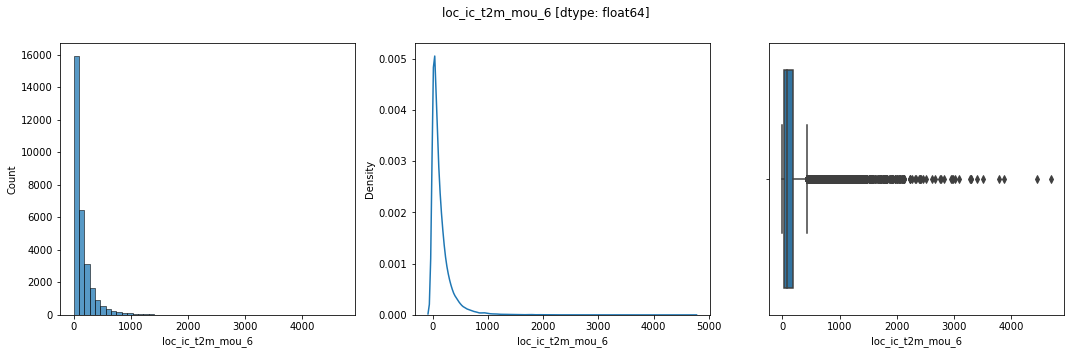

count    29880.000000
mean       150.813181
std        219.470073
min          0.000000
25%         28.390000
50%         84.310000
75%        189.180000
max       4693.860000





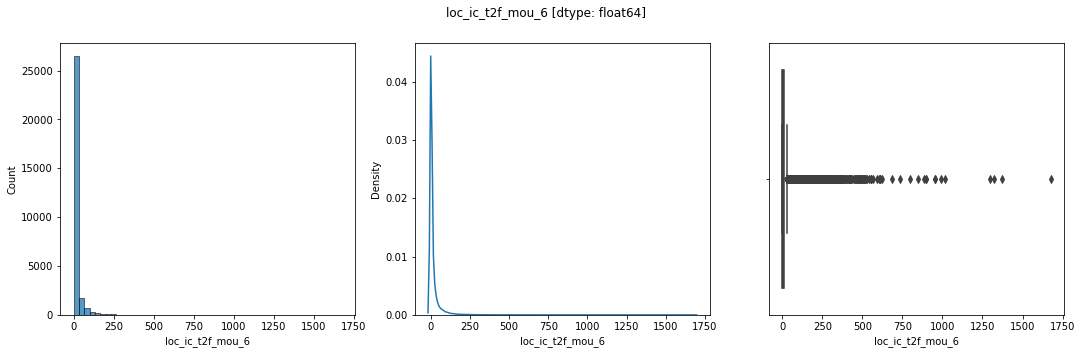

count    29880.000000
mean        15.326211
std         45.834028
min          0.000000
25%          0.000000
50%          1.860000
75%         12.030000
max       1678.410000





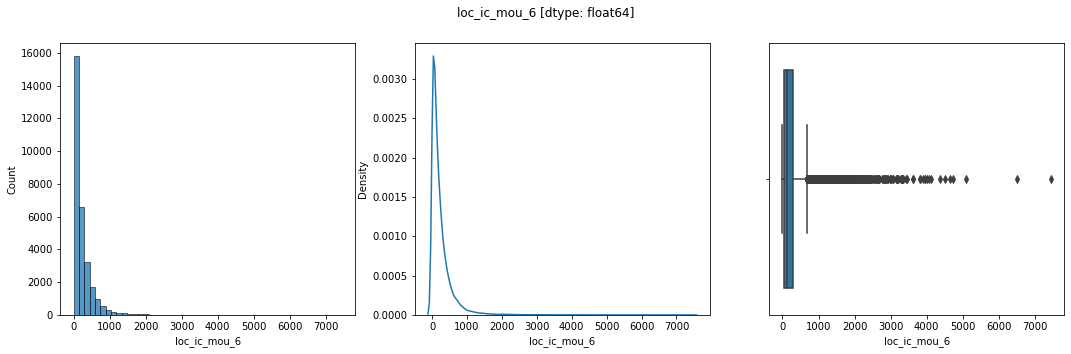

count    29880.000000
mean       231.808723
std        315.196433
min          0.000000
25%         48.360000
50%        135.050000
75%        298.115000
max       7454.630000





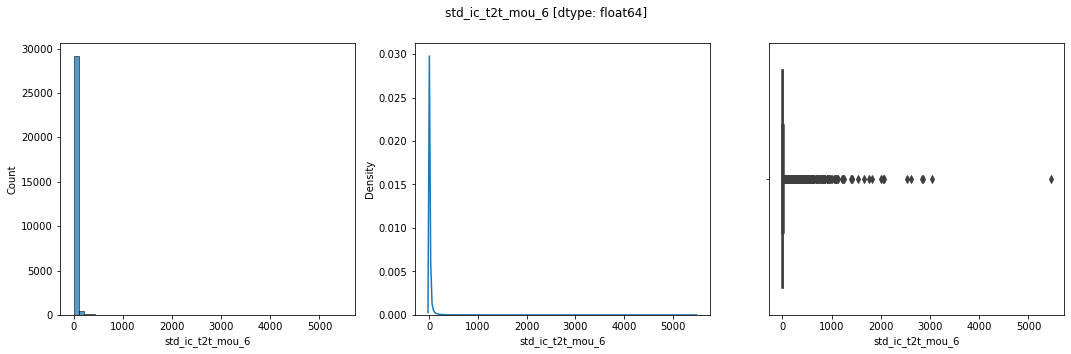

count    29880.000000
mean        14.931225
std         77.841447
min          0.000000
25%          0.000000
50%          0.400000
75%          8.240000
max       5459.560000





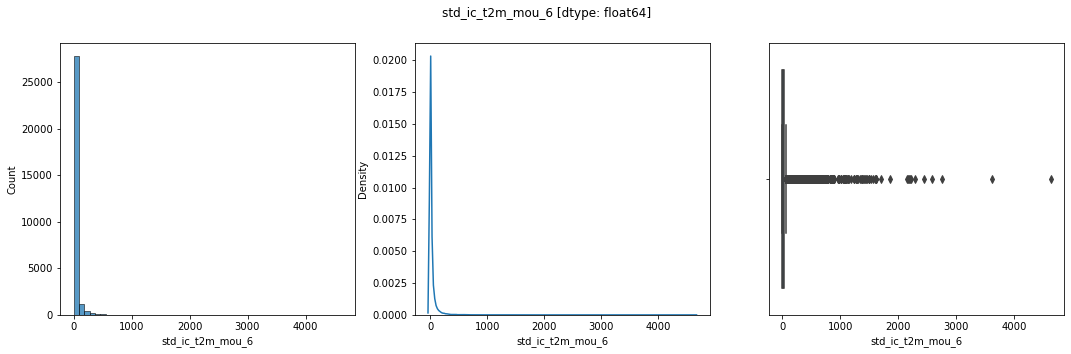

count    29880.000000
mean        29.279457
std         98.389121
min          0.000000
25%          0.000000
50%          5.040000
75%         23.690000
max       4630.230000





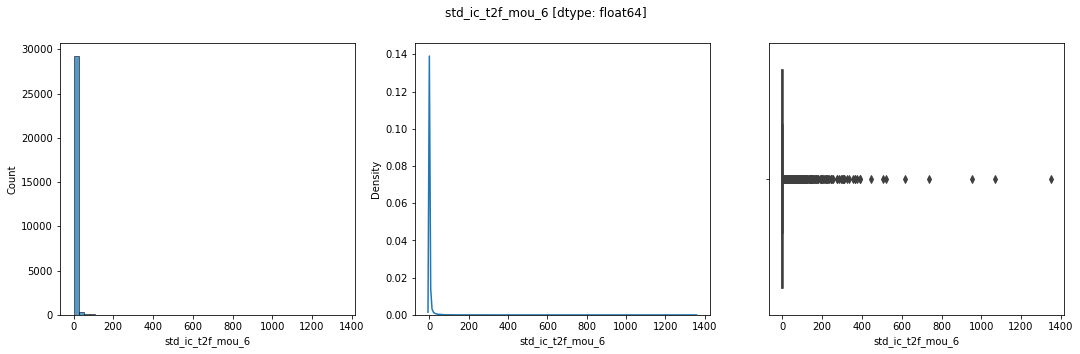

count    29880.000000
mean         2.705423
std         19.137636
min          0.000000
25%          0.000000
50%          0.000000
75%          0.130000
max       1351.110000





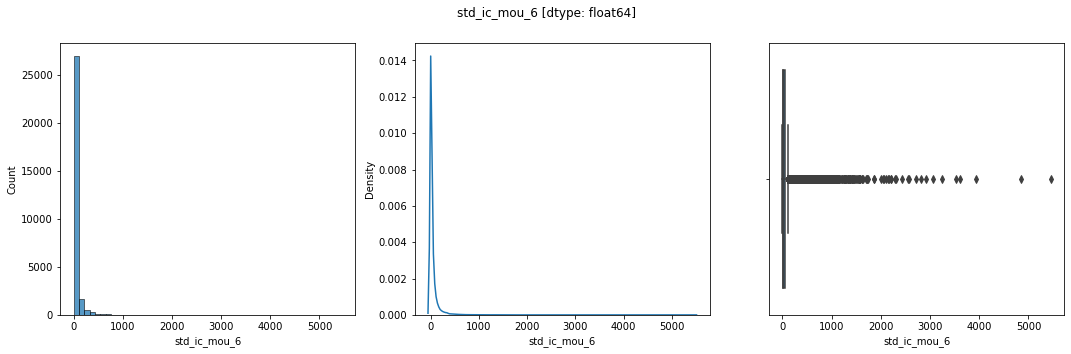

count    29880.000000
mean        46.919698
std        137.747404
min          0.000000
25%          1.060000
50%         11.460000
75%         41.595000
max       5459.630000





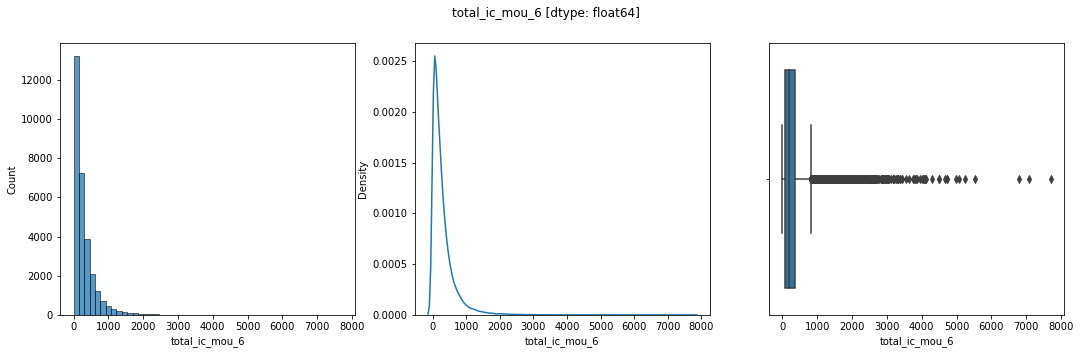

count    29880.000000
mean       290.781373
std        365.928710
min          0.000000
25%         73.360000
50%        184.410000
75%        373.142500
max       7716.140000





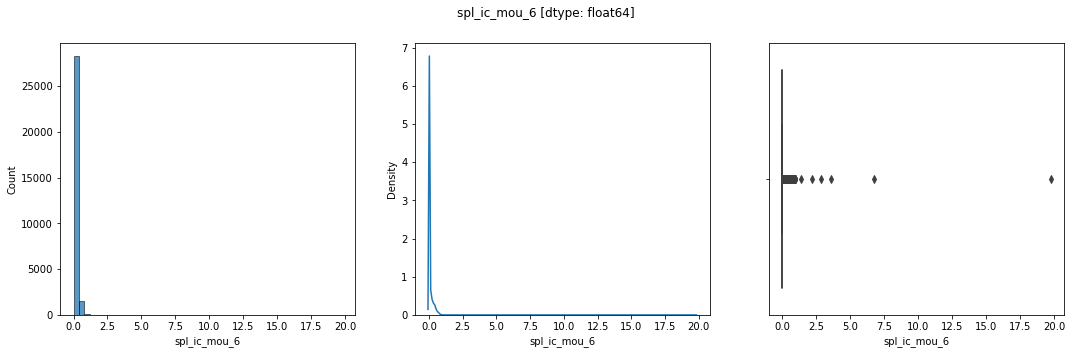

count    29880.000000
mean         0.061124
std          0.188284
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         19.760000





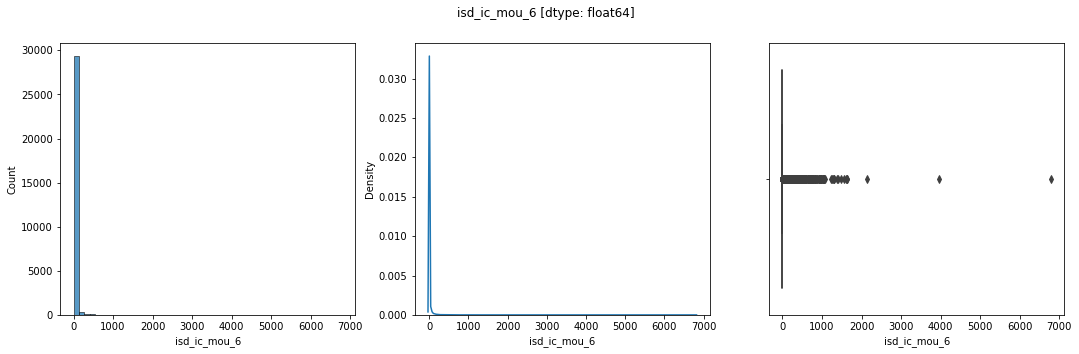

count    29880.000000
mean        10.825786
std         76.881342
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6789.410000





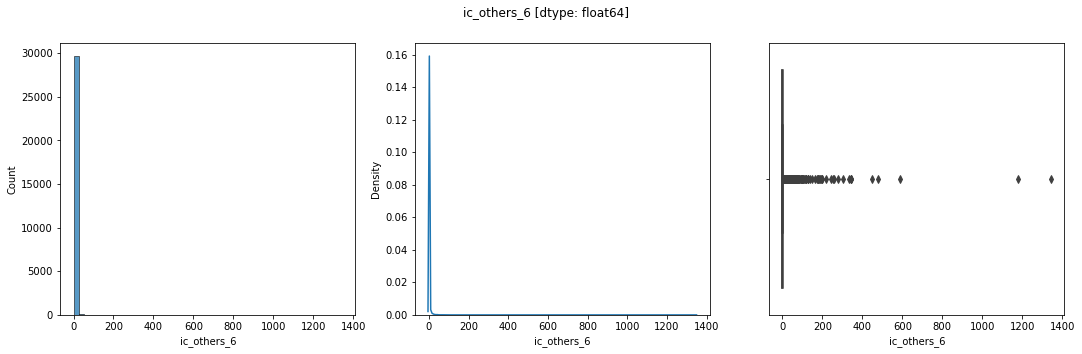

count    29880.000000
mean         1.157911
std         14.014044
min          0.000000
25%          0.000000
50%          0.000000
75%          0.050000
max       1344.140000





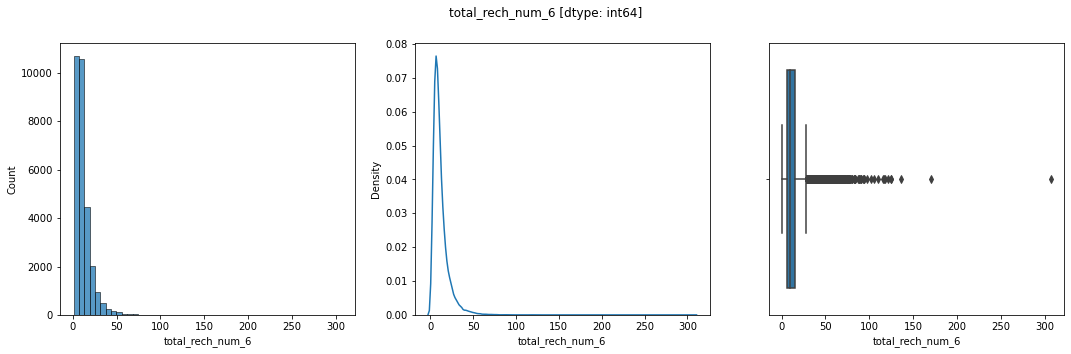

count    29880.000000
mean        11.882764
std          9.422045
min          1.000000
25%          6.000000
50%          9.000000
75%         15.000000
max        307.000000





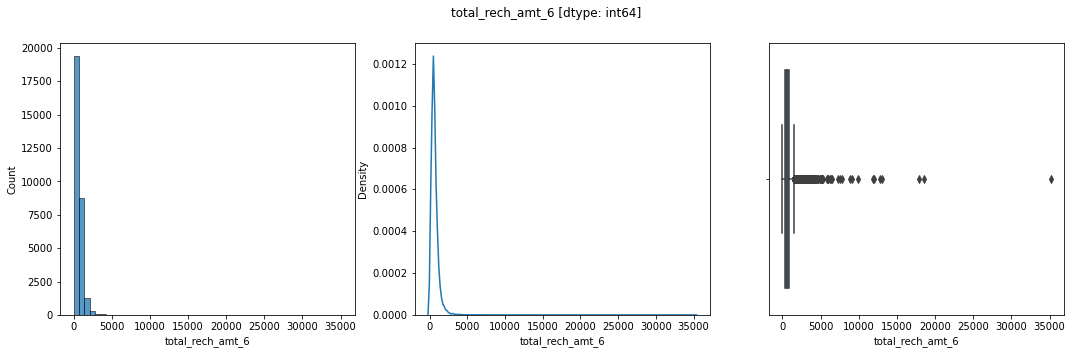

count    29880.000000
mean       662.741934
std        561.058118
min          0.000000
25%        362.000000
50%        567.000000
75%        835.000000
max      35190.000000





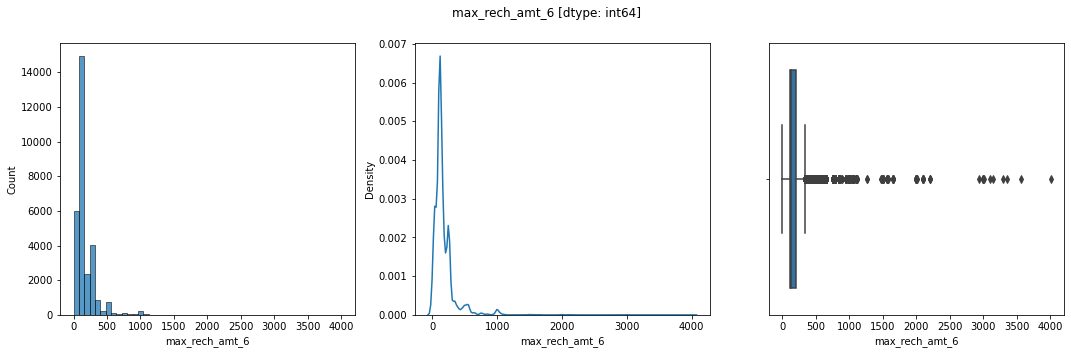

count    29880.000000
mean       169.761881
std        175.435888
min          0.000000
25%        110.000000
50%        120.000000
75%        200.000000
max       4010.000000





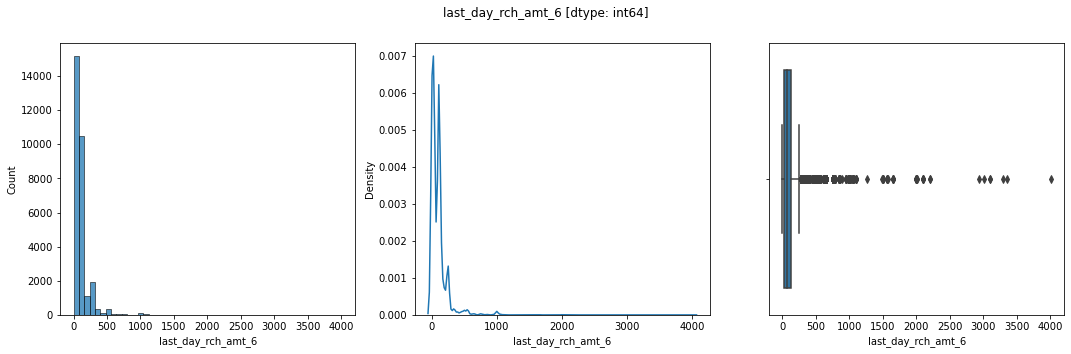

count    29880.000000
mean       101.180991
std        143.907160
min          0.000000
25%         25.000000
50%         67.000000
75%        120.000000
max       4010.000000





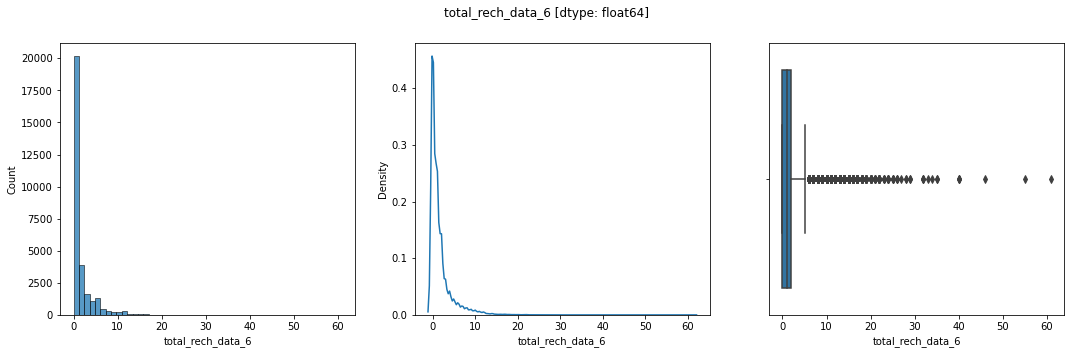

count    29880.000000
mean         1.673728
std          2.835188
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         61.000000





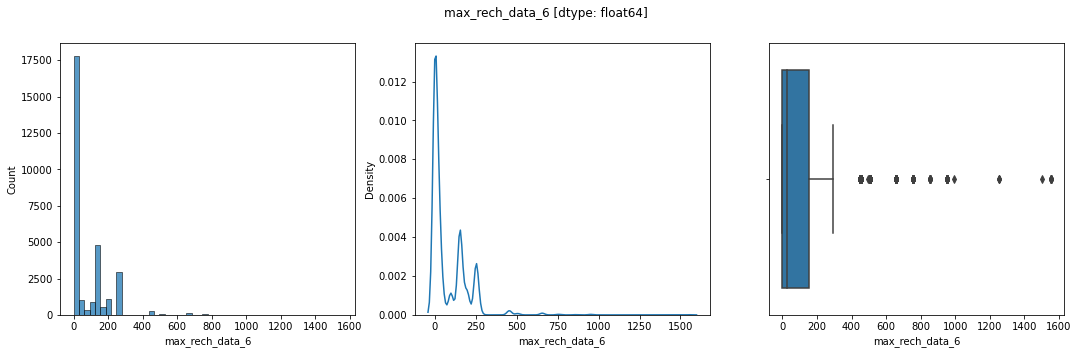

count    29880.000000
mean        78.323929
std        112.847755
min          0.000000
25%          0.000000
50%         25.000000
75%        154.000000
max       1555.000000





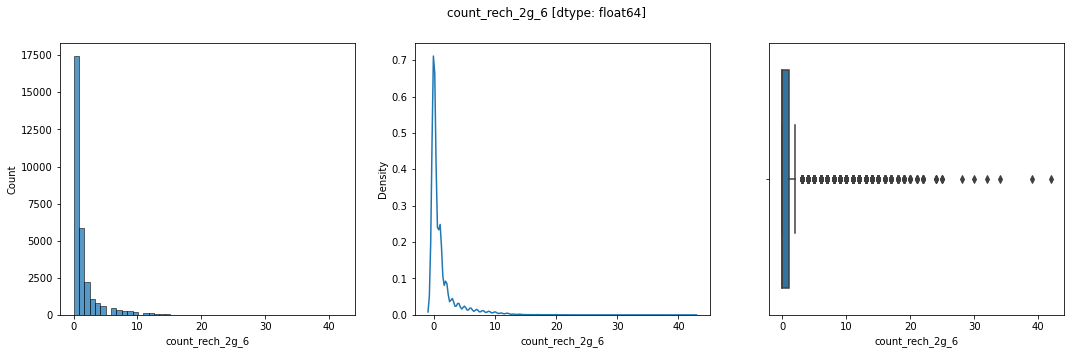

count    29880.000000
mean         1.244946
std          2.506100
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         42.000000





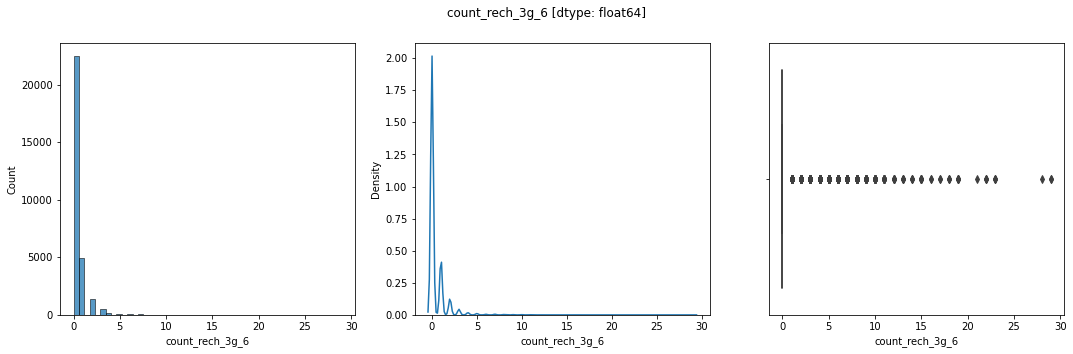

count    29880.000000
mean         0.428782
std          1.169872
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         29.000000





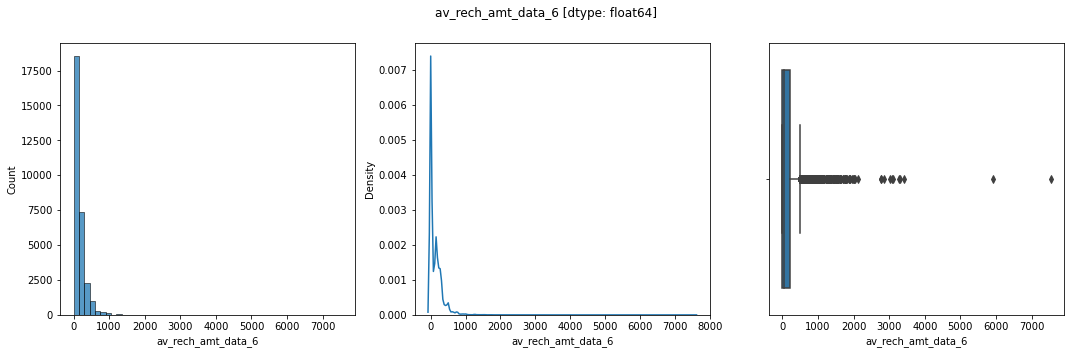

count    29880.000000
mean       131.098211
std        200.573779
min          0.000000
25%          0.000000
50%         50.000000
75%        198.000000
max       7546.000000





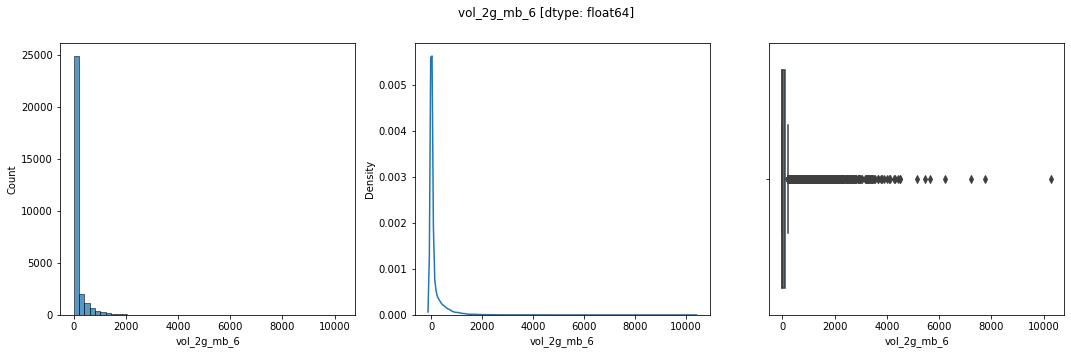

count    29880.000000
mean       126.832107
std        330.676128
min          0.000000
25%          0.000000
50%          0.010000
75%         84.445000
max      10285.900000





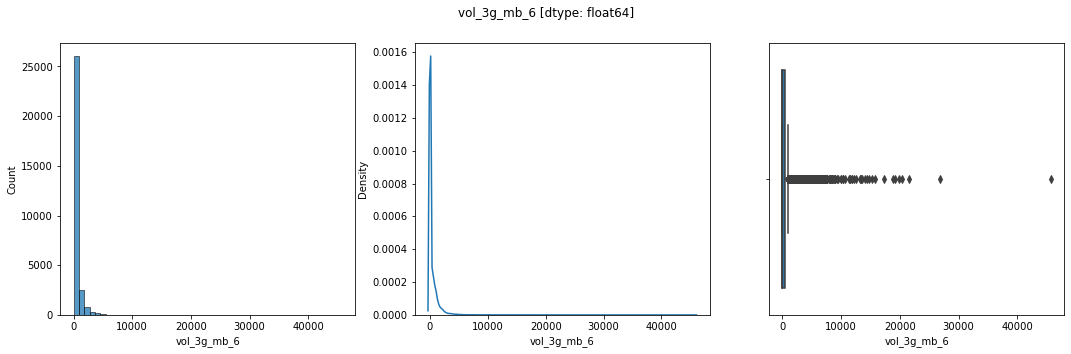

count    29880.000000
mean       345.505835
std        915.312529
min          0.000000
25%          0.000000
50%          0.000000
75%        361.645000
max      45735.400000





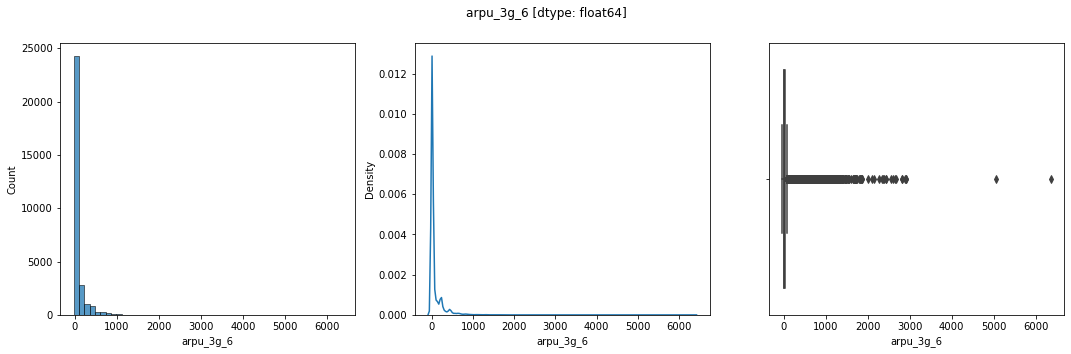

count    29880.000000
mean        67.260075
std        179.462644
min        -30.280000
25%          0.000000
50%          0.000000
75%         35.015000
max       6362.280000





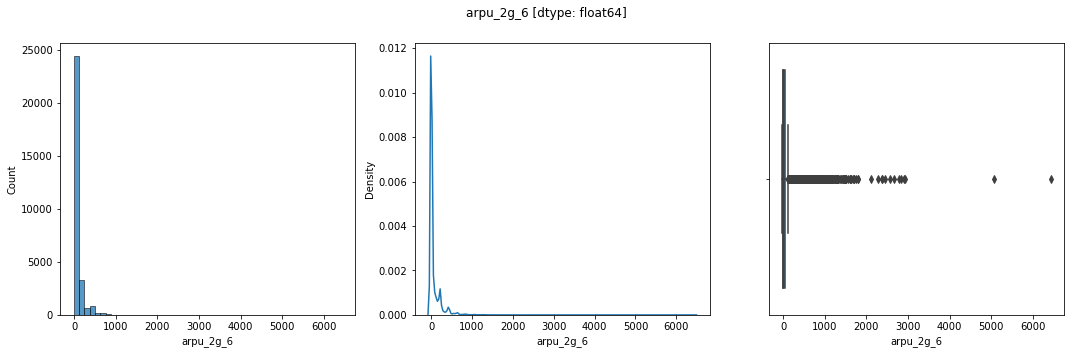

count    29880.000000
mean        63.683885
std        161.282534
min        -15.320000
25%          0.000000
50%          0.000000
75%         51.525000
max       6433.760000





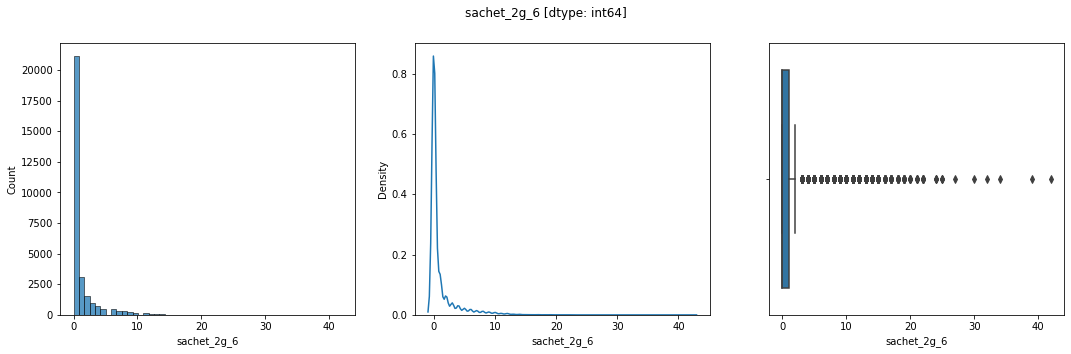

count    29880.000000
mean         1.070047
std          2.511371
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         42.000000





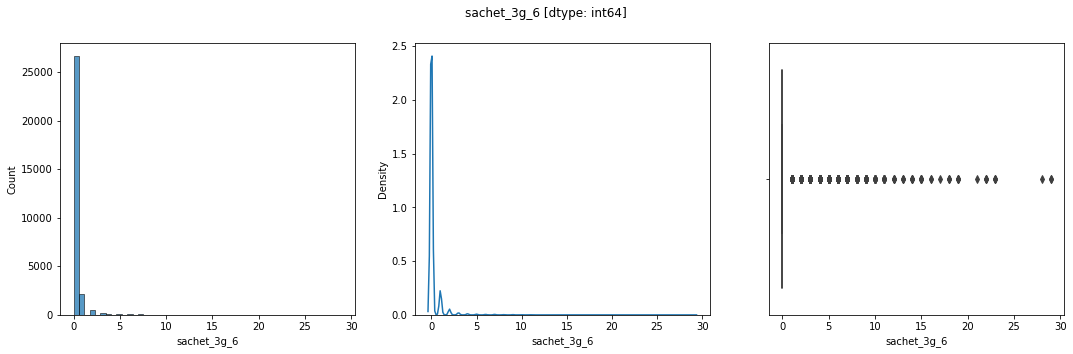

count    29880.000000
mean         0.210174
std          0.987558
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         29.000000





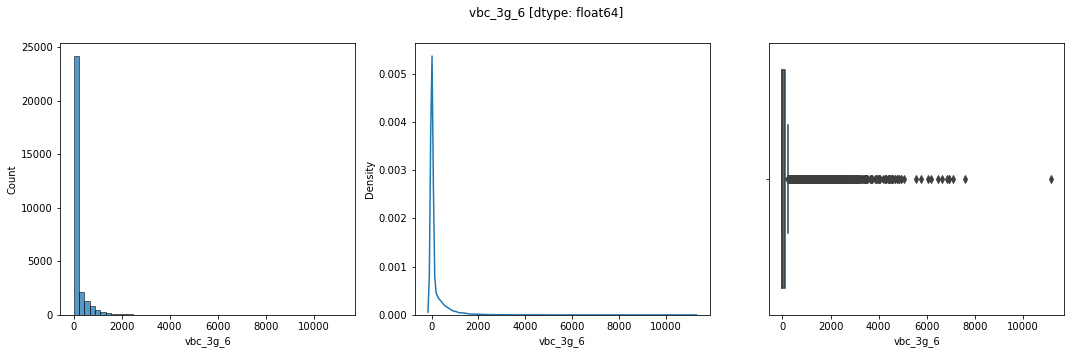

count    29880.000000
mean       159.037876
std        417.405739
min          0.000000
25%          0.000000
50%          0.000000
75%         99.500000
max      11166.210000





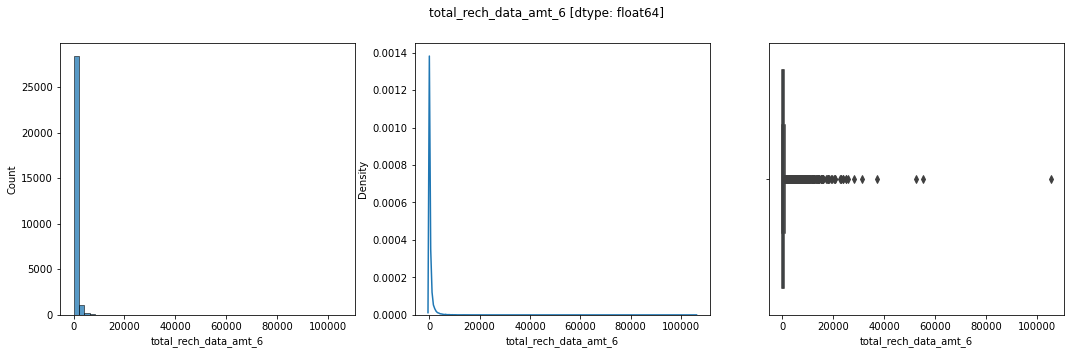

count     29880.000000
mean        457.502569
std        1421.267742
min           0.000000
25%           0.000000
50%          98.000000
75%         400.000000
max      105644.000000





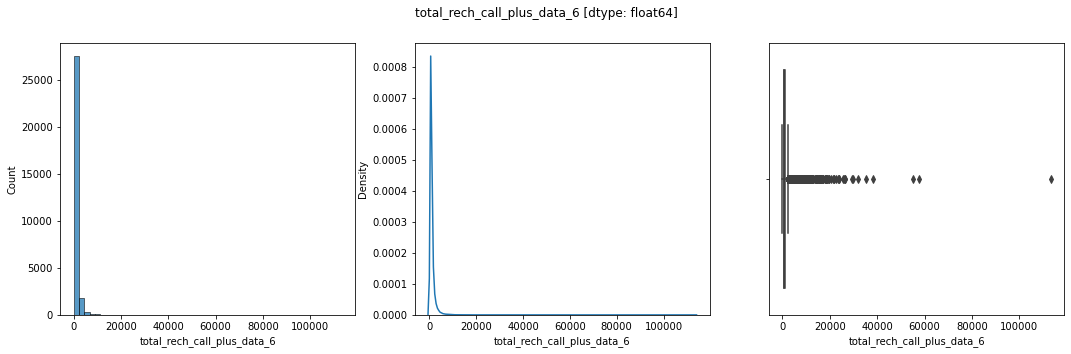

count     29880.000000
mean       1120.244504
std        1568.082447
min           0.000000
25%         548.000000
50%         790.000000
75%        1211.000000
max      113458.000000





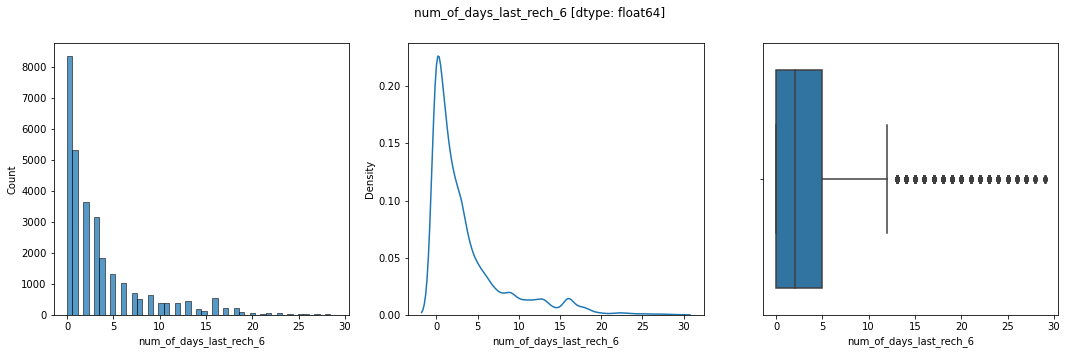

count    29880.000000
mean         3.535509
std          4.671634
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max         29.000000





In [120]:
for col in more_unique_cols_6:
    plot_large(churn_df, col)
    print('\n')

#### Observation
- The data seems heavily right-skewed

#### Checking if the extreme values are valid or not

In [121]:
churn_df[churn_df['vol_3g_mb_6'] == churn_df['vol_3g_mb_6'].max()]

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
27531  5034.04  3711.661  3459.269          0.0          0.0          0.0   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
27531          1.73           0.0         10.19            0.0            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
27531            0.0            0.0            0.0            0.0   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
27531               0.0               0.0               0.0               0.0   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
27531               0.0              0.53               0.0               0.0   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
27531               0.0              1.73               0.0              8.51   

       loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
27531           0.0           0.0          0.53               0.0   

       std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
27531               0.0               0.0               0.0               0.0   

       std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
27531               0.0               0.0               0.0               0.0   

       std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
27531           0.0           0.0           0.0           0.0           0.0   

       isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  og_others_6  \
27531           0.0          1.73           0.0          9.66          0.0   

       og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  \
27531          0.0          0.0            1.73             0.0   

       total_og_mou_8  loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
27531           10.19               0.0               0.0               0.0   

       loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  \
27531               0.0               0.0               0.0               0.0   

       loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  loc_ic_mou_6  loc_ic_mou_7  \
27531               0.0               0.0           0.0           0.0   

       loc_ic_mou_8  std_ic_t2t_mou_6  std_ic_t2t_mou_7  std_ic_t2t_mou_8  \
27531           0.0               0.0               0.0               0.0   

       std_ic_t2m_mou_6  std_ic_t2m_mou_7  std_ic_t2m_mou_8  std_ic_t2f_mou_6  \
27531               0.0               0.0               0.0               0.0   

       std_ic_t2f_mou_7  std_ic_t2f_mou_8  std_ic_mou_6  std_ic_mou_7  \
27531               0.0               0.0           0.0           0.0   

       std_ic_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
27531           0.0            0.03             0.0             0.0   

       spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  isd_ic_mou_7  \
27531          0.03           0.0           0.0           0.0           0.0   

       isd_ic_mou_8  ic_others_6  ic_others_7  ic_others_8  total_rech_num_6  \
27531           0.0          0.0          0.0          0.0                 5   

       total_rech_num_7  total_rech_num_8  total_rech_amt_6  total_rech_amt_7  \
27531                 5                 5              5920              4365   

       total_rech_amt_8  max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  \
27531              4091            1555            1555            1555   

       last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  \
27531                1555                1555                1555   

       total_rech_data_6  total_rech_data_7  total_rech_data_8  \
27531                4.0                3.0                3.0   

       max_rech_data_6  max_rech_data_7  max_rech_data_8  count_rech_2g_6  \
27531           1555.0           1555.0           1555.0              0.0   

       c

In [122]:
churn_df[churn_df['total_rech_amt_6'] == churn_df['total_rech_amt_6'].max()]

arpu_6     arpu_7     arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
38610  27731.088  35145.834  33543.624         5.69         5.14         7.01   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
38610       3231.81       3868.59       3625.43            0.0            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
38610            0.0            0.0            0.0            0.0   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
38610              5.69              5.14              7.01              2.51   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
38610               0.4              8.29               0.0               0.0   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
38610               0.0               0.0               0.0               0.0   

       loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
38610          8.21          5.54         15.31               0.0   

       std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
38610               0.0               0.0               0.0              0.18   

       std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
38610               0.0               0.0               0.0               0.0   

       std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
38610           0.0          0.18           0.0       3229.29       3868.01   

       isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  og_others_6  \
38610       3629.91           0.0           0.0           0.0          0.0   

       og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  \
38610          0.0          0.0         3237.51         3873.74   

       total_og_mou_8  loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
38610         3645.23              6.93             13.73             14.76   

       loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  \
38610              4.56              2.78             10.81               0.0   

       loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  loc_ic_mou_6  loc_ic_mou_7  \
38610               0.0              1.43         11.49         16.51   

       loc_ic_mou_8  std_ic_t2t_mou_6  std_ic_t2t_mou_7  std_ic_t2t_mou_8  \
38610         27.01              2.28               0.0               0.0   

       std_ic_t2m_mou_6  std_ic_t2m_mou_7  std_ic_t2m_mou_8  std_ic_t2f_mou_6  \
38610               0.0               0.0              5.06               0.0   

       std_ic_t2f_mou_7  std_ic_t2f_mou_8  std_ic_mou_6  std_ic_mou_7  \
38610               0.0               0.0          2.28           0.0   

       std_ic_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
38610          5.06          551.04          525.71          596.03   

       spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  isd_ic_mou_7  \
38610          0.13          0.06           0.0        536.99        504.01   

       isd_ic_mou_8  ic_others_6  ic_others_7  ic_others_8  total_rech_num_6  \
38610        556.74         0.13         5.11         7.19                29   

       total_rech_num_7  total_rech_num_8  total_rech_amt_6  total_rech_amt_7  \
38610                17                19             35190             40335   

       total_rech_amt_8  max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  \
38610             45320            3100            3100            3100   

       last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  \
38610                3100                3100                  35   

       total_rech_data_6  total_rech_data_7  total_rech_data_8  \
38610                0.0                0.0                0.0   

       max_rech_data_6  max_rech_data_7  max_rech_data_8  count_rech_2g_6  \
38610              0.0              0.0              0.0              0.0   

  

In [123]:
churn_df[churn_df['total_rech_call_plus_data_6'] == churn_df['total_rech_call_plus_data_6'].max()]

arpu_6    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
49093  6636.431  1451.063  879.312        15.76        41.29         1.06   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
49093        381.28        284.99         20.78            0.0            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
49093            0.0            0.0            0.0            0.0   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
49093             15.76             38.73              1.06            368.88   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
49093            250.81             20.78               0.0               0.0   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
49093               0.0              3.95             72.48               0.0   

       loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
49093        384.64        289.54         21.84               0.0   

       std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
49093              2.56               0.0               1.7             34.06   

       std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
49093               0.0               0.0               0.0               0.0   

       std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
49093           1.7         36.63           0.0           0.0           0.0   

       isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  og_others_6  \
49093           0.0         14.33         73.81          4.23         2.71   

       og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  \
49093          0.0          0.0          403.39          399.99   

       total_og_mou_8  loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
49093           26.08              2.59             34.23               0.0   

       loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  \
49093             36.99             73.31              6.68              0.73   

       loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  loc_ic_mou_6  loc_ic_mou_7  \
49093              2.51               0.0         40.33        110.06   

       loc_ic_mou_8  std_ic_t2t_mou_6  std_ic_t2t_mou_7  std_ic_t2t_mou_8  \
49093          6.68              1.18              3.19               0.0   

       std_ic_t2m_mou_6  std_ic_t2m_mou_7  std_ic_t2m_mou_8  std_ic_t2f_mou_6  \
49093              2.94              1.56               0.0              5.38   

       std_ic_t2f_mou_7  std_ic_t2f_mou_8  std_ic_mou_6  std_ic_mou_7  \
49093              8.09               0.0          9.51         12.86   

       std_ic_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
49093           0.0           49.84          122.93            6.68   

       spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  isd_ic_mou_7  \
49093           0.0           0.0           0.0           0.0           0.0   

       isd_ic_mou_8  ic_others_6  ic_others_7  ic_others_8  total_rech_num_6  \
49093           0.0          0.0          0.0          0.0                35   

       total_rech_num_7  total_rech_num_8  total_rech_amt_6  total_rech_amt_7  \
49093                25                 7              7814              1699   

       total_rech_amt_8  max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  \
49093               937             951             455             455   

       last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  \
49093                 951                  10                  17   

       total_rech_data_6  total_rech_data_7  total_rech_data_8  \
49093               14.0                5.0                4.0   

       max_rech_data_6  max_rech_data_7  max_rech_data_8  count_rech_2g_6  \
49093            951.0            455.0            455.0              1.0   

       co

In [124]:
churn_df[churn_df['total_rech_call_plus_data_7'] == churn_df['total_rech_call_plus_data_7'].max()]

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
97825  239.138  860.385  676.406         3.68          0.0          0.0   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
97825          0.93           0.0           0.0           1.41            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
97825            0.0            0.0            0.0            0.0   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
97825               0.0               0.0               0.0              0.93   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
97825               0.0               0.0               0.0               0.0   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
97825               0.0               0.0               0.0               0.0   

       loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
97825          0.93           0.0           0.0              3.68   

       std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
97825               0.0               0.0               0.0               0.0   

       std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
97825               0.0               0.0               0.0               0.0   

       std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
97825          3.68           0.0           0.0           0.0           0.0   

       isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  og_others_6  \
97825           0.0           0.0          2.99          0.38         0.21   

       og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  \
97825          0.0          0.0            4.83            2.99   

       total_og_mou_8  loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
97825            0.38             34.19            103.53             20.41   

       loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  \
97825            183.63            138.98             88.39              2.79   

       loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  loc_ic_mou_6  loc_ic_mou_7  \
97825             14.01             22.76        220.63        256.53   

       loc_ic_mou_8  std_ic_t2t_mou_6  std_ic_t2t_mou_7  std_ic_t2t_mou_8  \
97825        131.58              2.35             24.09             15.56   

       std_ic_t2m_mou_6  std_ic_t2m_mou_7  std_ic_t2m_mou_8  std_ic_t2f_mou_6  \
97825              4.14              5.88               1.4               0.0   

       std_ic_t2f_mou_7  std_ic_t2f_mou_8  std_ic_mou_6  std_ic_mou_7  \
97825               0.0               0.0          6.49         29.98   

       std_ic_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
97825         16.96          227.13          286.51          148.54   

       spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  isd_ic_mou_7  \
97825           0.0           0.0           0.0           0.0           0.0   

       isd_ic_mou_8  ic_others_6  ic_others_7  ic_others_8  total_rech_num_6  \
97825           0.0          0.0          0.0          0.0                 9   

       total_rech_num_7  total_rech_num_8  total_rech_amt_6  total_rech_amt_7  \
97825                43                31               287               995   

       total_rech_amt_8  max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  \
97825               787              41              46              46   

       last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  \
97825                   0                  25                  41   

       total_rech_data_6  total_rech_data_7  total_rech_data_8  \
97825                7.0               54.0               40.0   

       max_rech_data_6  max_rech_data_7  max_rech_data_8  count_rech_2g_6  \
97825             41.0             48.0             48.0              0.0   

       count

### Decision: After looking at a couple of data points, it seems that the extreme values are genuine. For now, we will not do any outlier treatment. Another reason for not performing outlier treatment is that the business requirement emphasizes on high value customers churn.

In [125]:
### checking data for people who churned
churn_df[churn_df['Churn'] == 1].head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0     197.385   214.816   213.803         0.00         0.00         0.00   
7    1069.180  1349.850  3171.480        57.84        54.68        52.29   
67    218.818   386.515   386.502         0.00         0.00         0.00   
86    319.700    56.080     1.030       141.76        11.23         0.00   
111   596.301   146.073     0.000        55.19         3.26         0.00   

     offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0            0.00          0.00          0.00           0.00           0.00   
7          453.43        567.16        325.91          16.23          33.49   
67           0.00          0.00          0.00           0.00           0.00   
86         182.76         32.79          1.71           0.00          14.56   
111         45.51         12.34          0.00           0.00           0.00   

     roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0             0.00           0.00           0.00           0.00   
7            31.64          23.74          12.59          38.06   
67            0.00           0.00           0.00           0.00   
86            0.00           0.00           2.26           1.71   
111           0.00           0.00           0.00           0.00   

     loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0                0.00              0.00              0.00              0.00   
7               51.39             31.38             40.28            308.63   
67               0.00              0.00              0.00              0.00   
86              52.54             10.63              0.00              7.54   
111             55.19              3.26              0.00             43.83   

     loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0                0.00              0.00              0.00              0.00   
7              447.38            162.28             62.13             55.14   
67               0.00              0.00              0.00              0.00   
86              14.70              0.00              2.13              3.33   
111             12.34              0.00              0.00              0.00   

     loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0                0.00               0.0               0.0               0.0   
7               53.23               0.0               0.0               0.0   
67               0.00               0.0               0.0               0.0   
86               0.00               0.0               0.0               0.0   
111              0.00               0.0               0.0               0.0   

     loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0            0.00          0.00          0.00              0.00   
7          422.16        533.91        255.79              4.30   
67           0.00          0.00          0.00              0.00   
86          62.23         28.66          0.00             89.21   
111         99.03         15.61          0.00              0.00   

     std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0                0.00              0.00              0.00              0.00   
7               23.29             12.01             49.89             31.76   
67               0.00              0.00              0.00              0.00   
86               0.00              0.00            173.08             13.10   
111              0.00              0.00              0.00              0.00   

     std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0                0.00              0.00              0.00              0.00   
7               49.14              6.66             20.08             16.68   
67               0.00              0.00              0.00              0.00   
86               0.00              0.00              

### Bivariate Analysis

#### Heatmap for Month 6

In [126]:
month_six_cols.append('Churn')

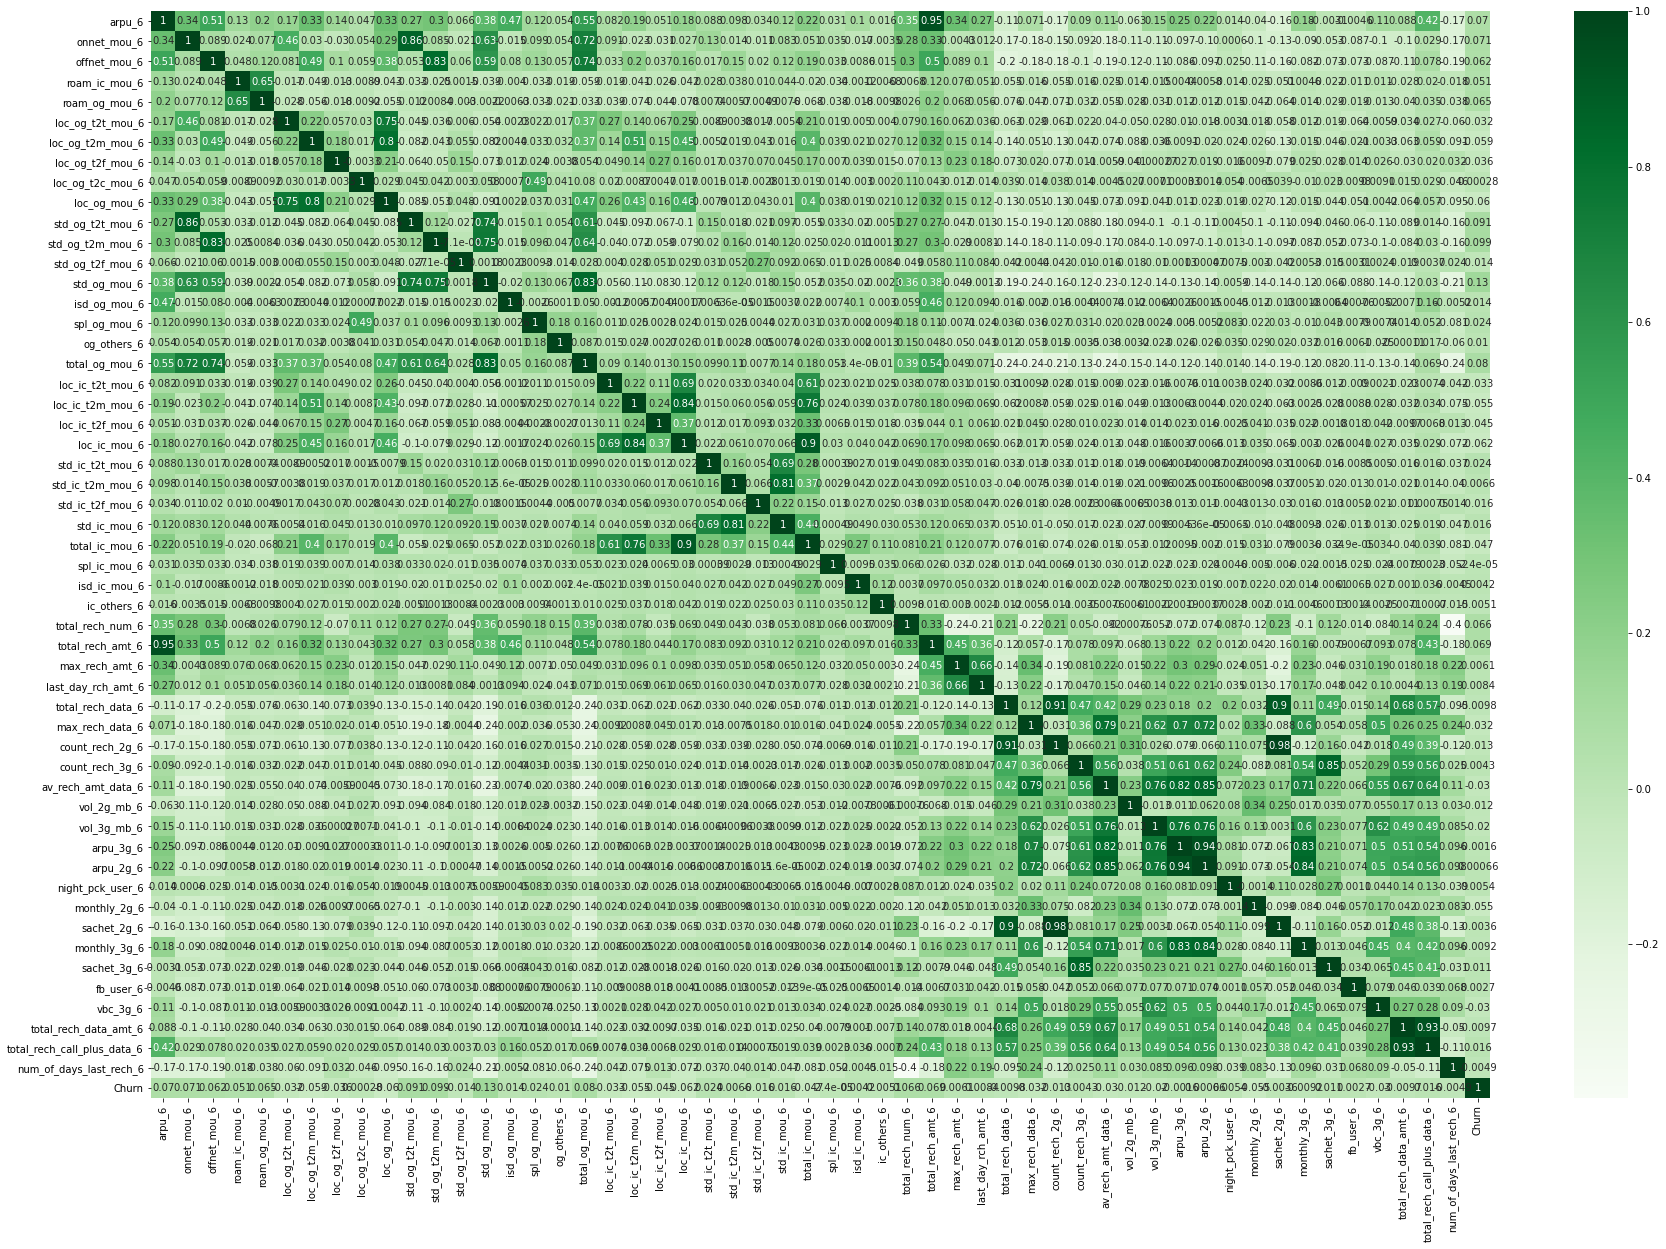

In [127]:
plt.figure(figsize=(30,20))
sns.heatmap(churn_df[month_six_cols].corr(), cmap='Greens', annot=True)
plt.savefig('heatmap.png')
plt.show()

#### Observations
- arpu 2g and arpu 3g are highly correlated
- total recharge data amt and total recharge call + data is highly correlated (this is expected, since it is derived column)
- arpu 3g and monthly 3g are highly correlated
- arpu and total recharge amount are highly correlated
- sachet_2g is highly correlated with total recharge data and count recharge 2g

In [128]:
data_cols = get_cols(churn_df, 'data')

In [129]:
data_cols

['total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_data_amt_6',
 'total_rech_data_amt_7',
 'total_rech_data_amt_8',
 'total_rech_call_plus_data_6',
 'total_rech_call_plus_data_7',
 'total_rech_call_plus_data_8',
 'total_rech_call_plus_data_good_phase']

In [130]:
derived_cols = ['total_rech_data_amt_6',
 'total_rech_data_amt_7',
 'total_rech_data_amt_8',
 'total_rech_call_plus_data_6',
 'total_rech_call_plus_data_7',
 'total_rech_call_plus_data_8',
 'total_rech_call_plus_data_good_phase']

In [131]:
data_cols_orig = [col for col in data_cols if col not in derived_cols]

In [132]:
g3_cols = get_cols(churn_df, '3g')
g2_cols = get_cols(churn_df, '2g')

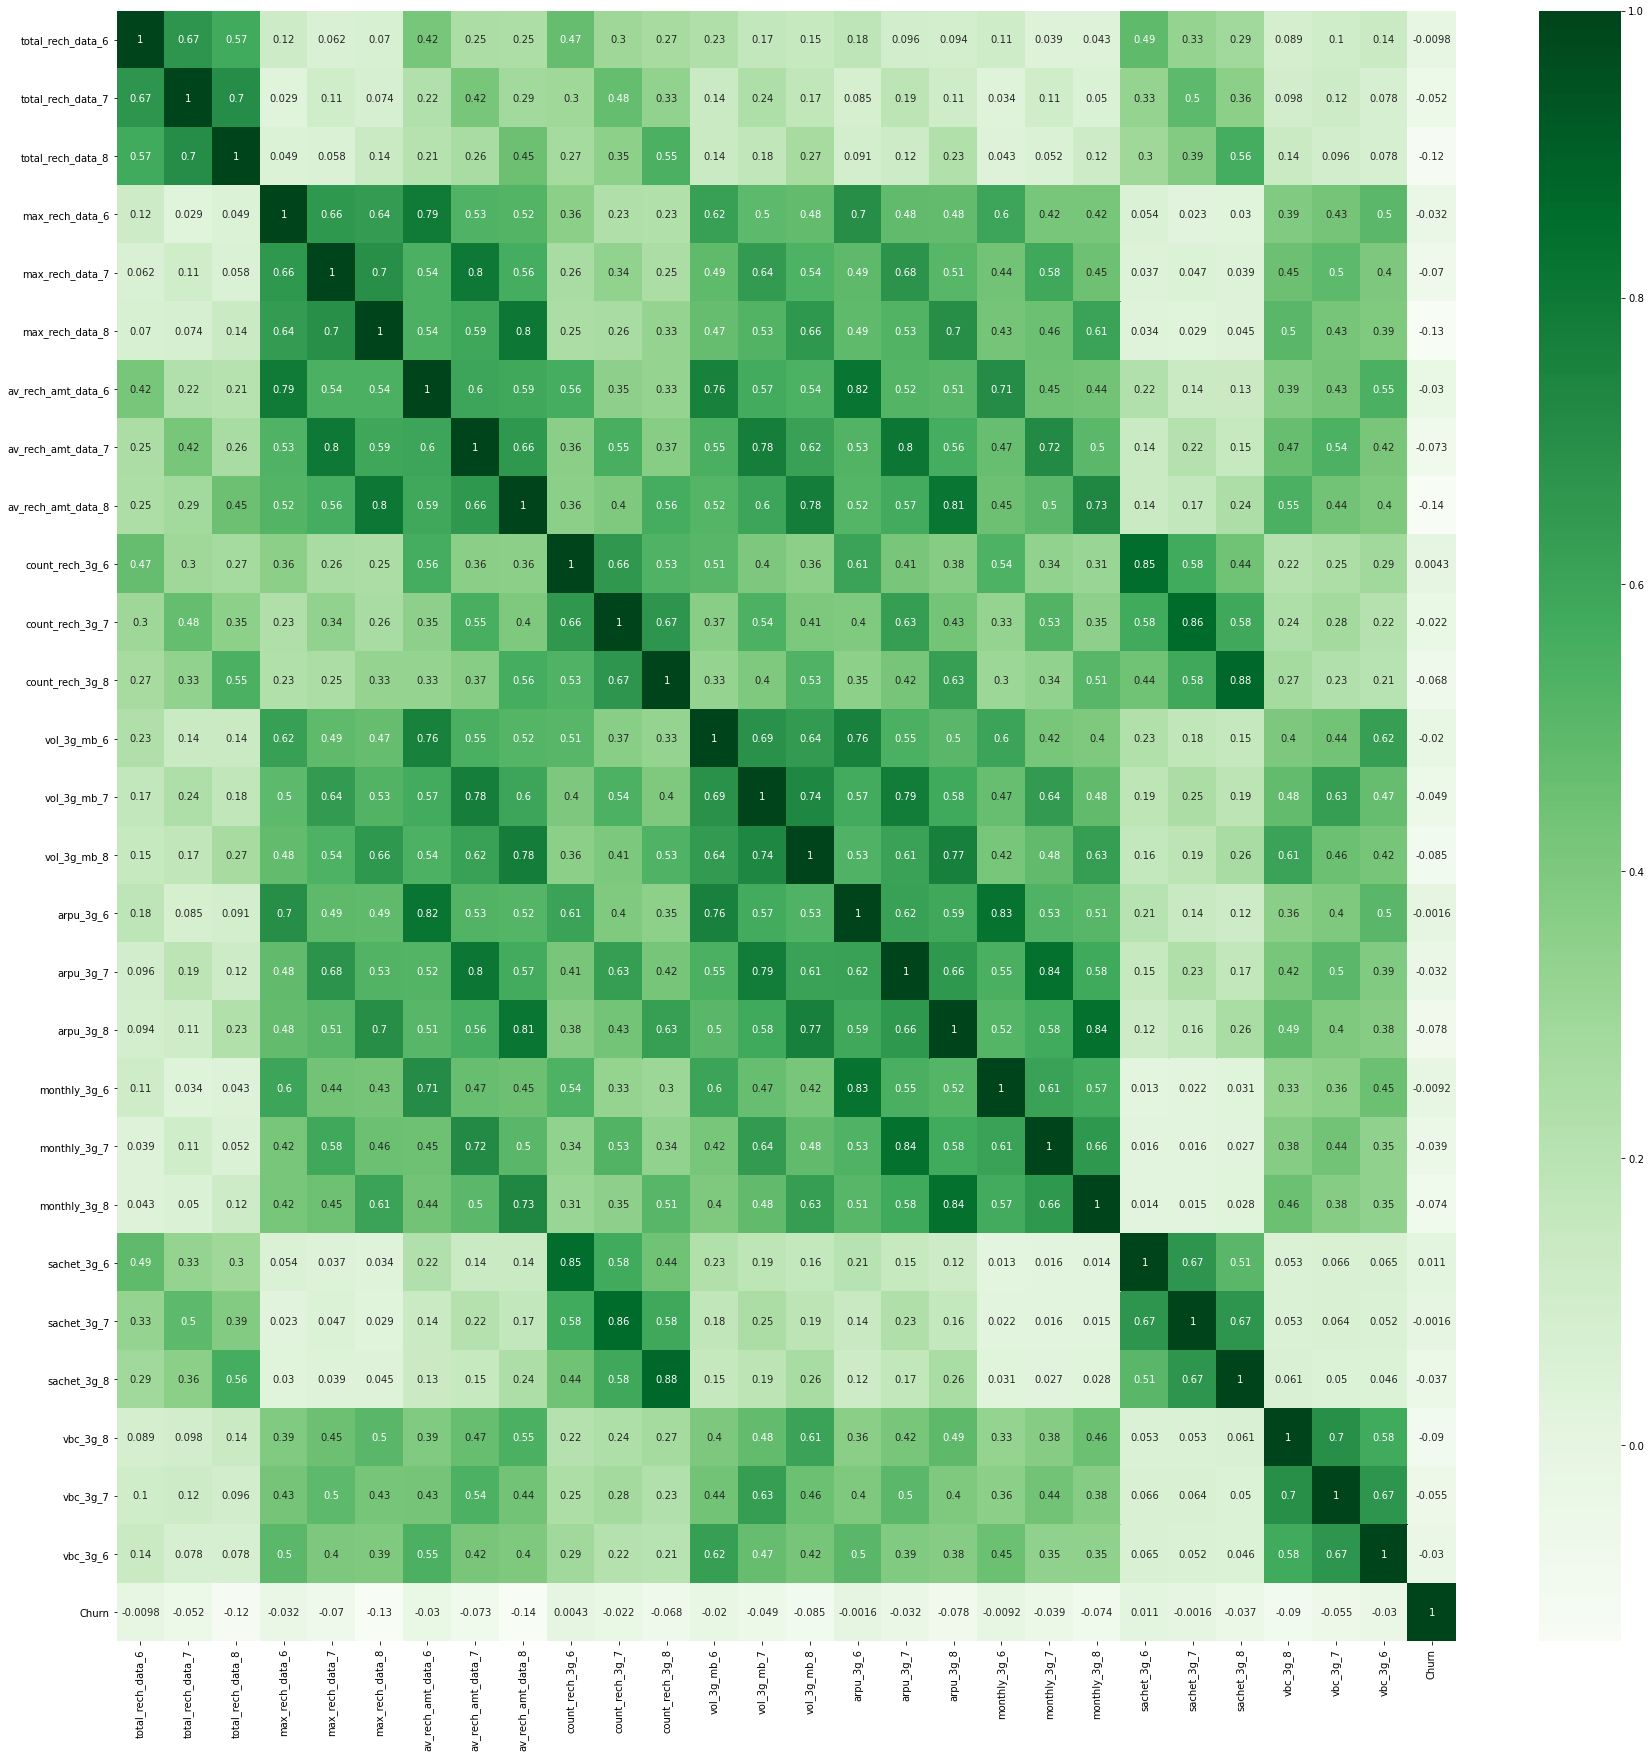

In [133]:
data_heatmap_cols = data_cols_orig + g3_cols

data_heatmap_cols.append('Churn')
plt.figure(figsize=(30, 30))
sns.heatmap(churn_df[data_heatmap_cols].corr(), cmap='Greens', annot=True)
plt.savefig('data_heatmap_3g.png')
plt.show()

#### Observations
- Count 3g and sachet 3g are highly correlated for all months
- vbc 3g for month 7 and 8 are positively correlated (~70%)
- averge recharge data amount and arpu have a good correlation
- averge recharge data amount and arpu 3g have high correlation
- volume of current month is correlated with last month volume
- average data recharge and max data recharge are strongly correlated

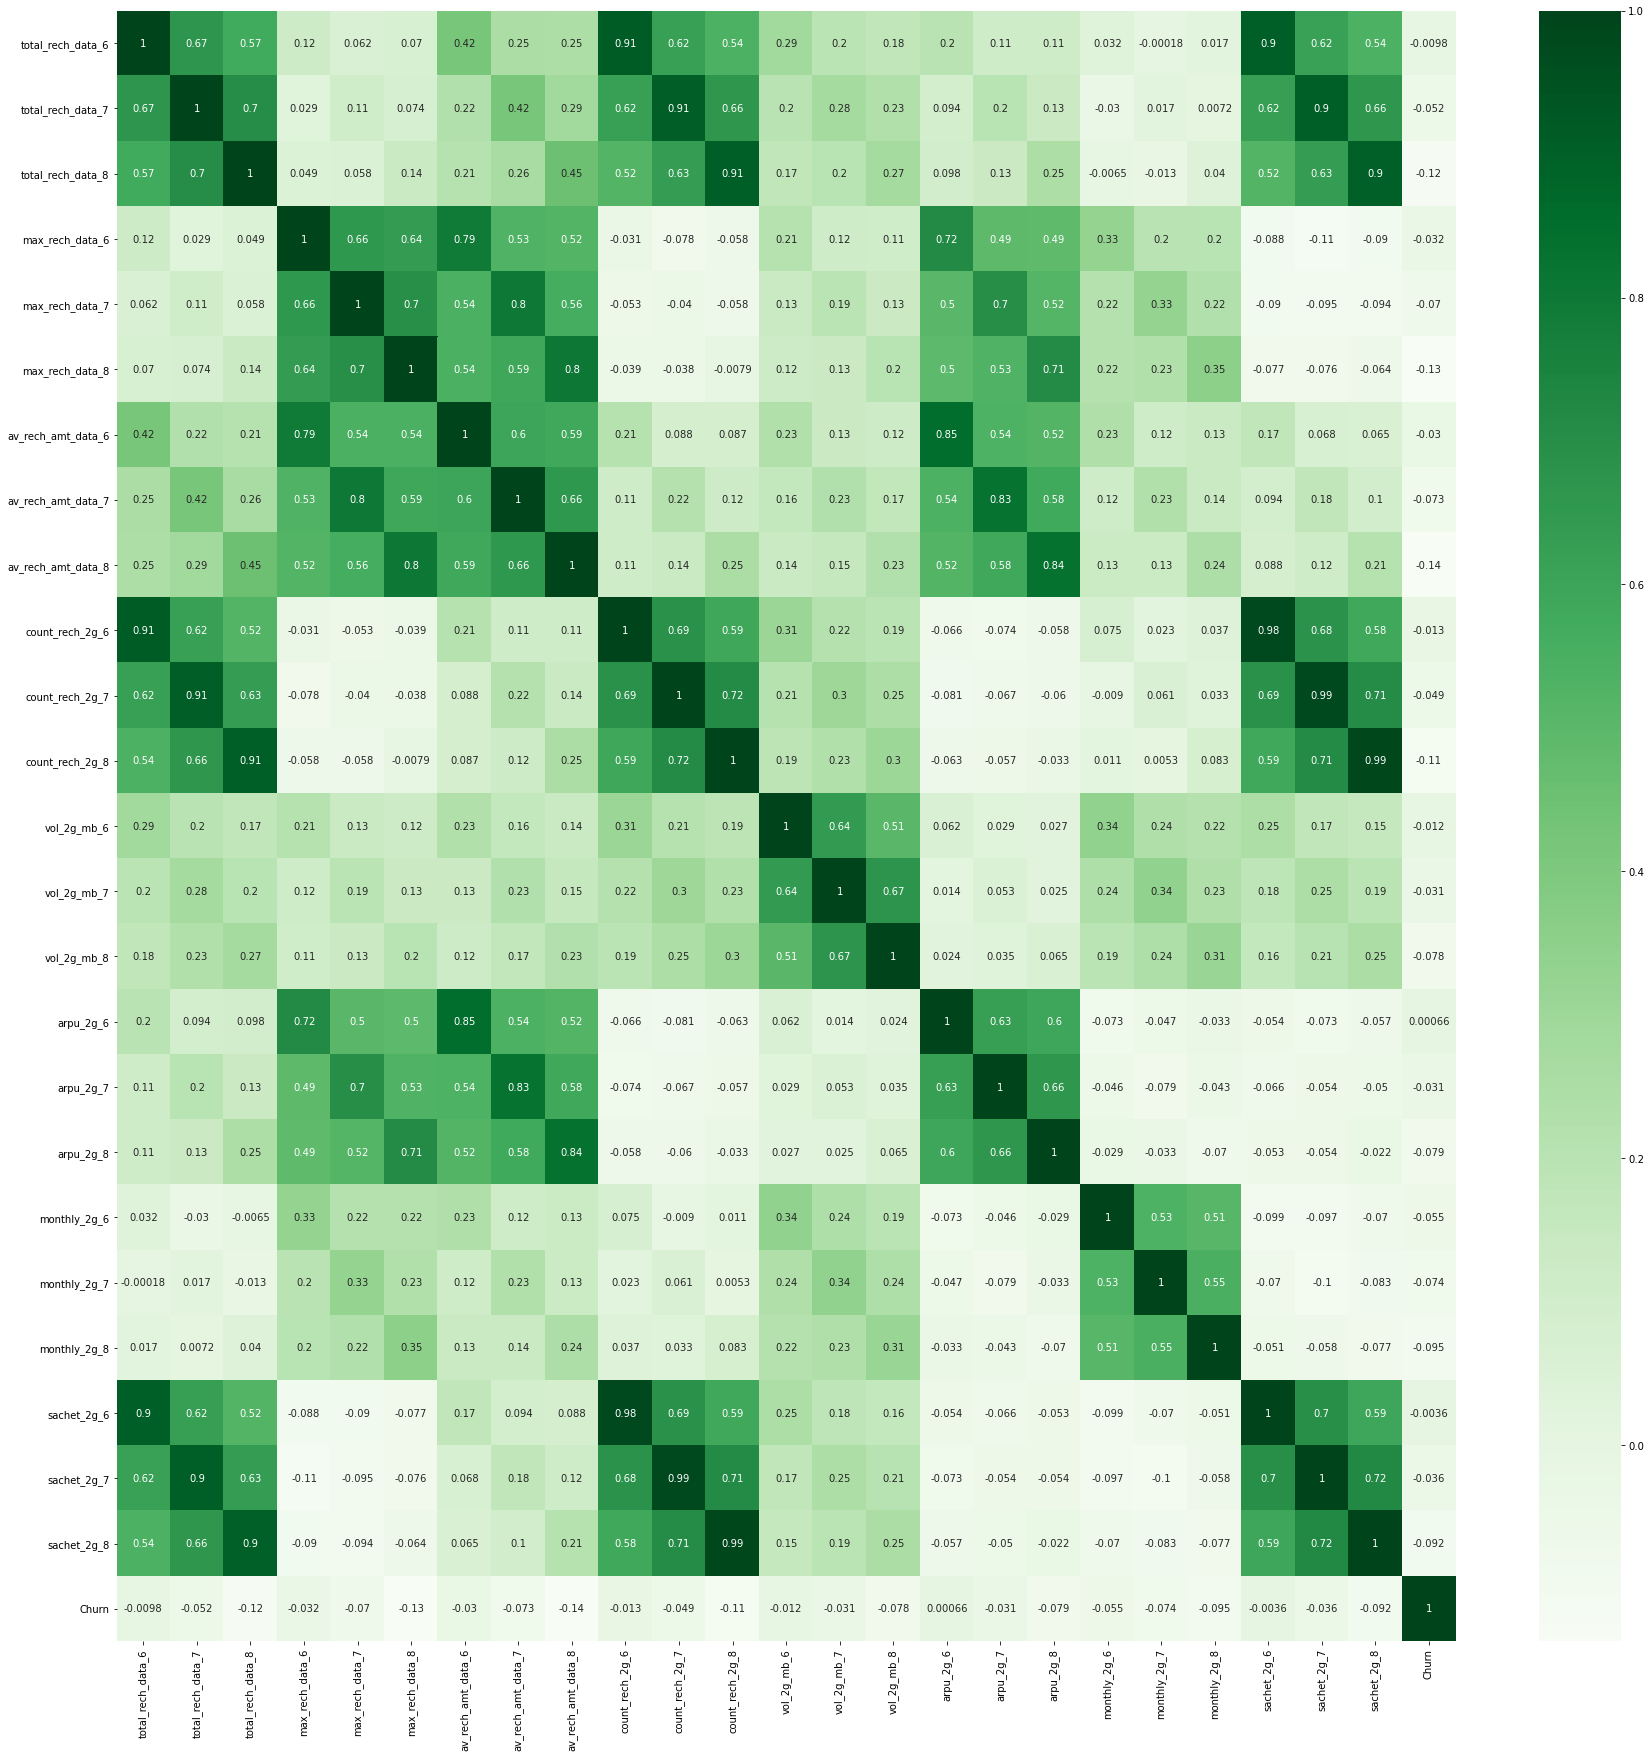

In [134]:
data_heatmap_cols = data_cols_orig + g2_cols

data_heatmap_cols.append('Churn')
plt.figure(figsize=(30, 30))
sns.heatmap(churn_df[data_heatmap_cols].corr(), cmap='Greens', annot=True)
plt.savefig('data_heatmap_2g.png')
plt.show()

##### Observations for 2g and 3g are similar in essence

#### Scatter Plots

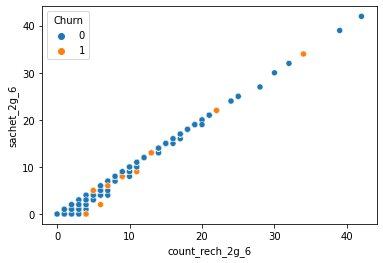

In [135]:
sns.scatterplot(x='count_rech_2g_6', y='sachet_2g_6', data=churn_df, hue='Churn')
plt.show()

Linear relation is visible in count recharge 2g and sachet 2g

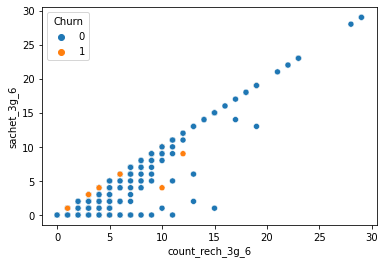

In [136]:
sns.scatterplot(x='count_rech_3g_6', y='sachet_3g_6', data=churn_df, hue='Churn')
plt.show()

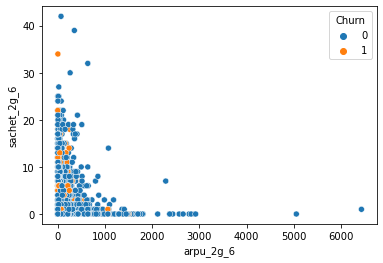

In [137]:
sns.scatterplot(x='arpu_2g_6', y='sachet_2g_6', data=churn_df, hue='Churn')
plt.show()

### Pair Plot

In [138]:
data_m6_cols = [col for col in data_heatmap_cols if '6' in col]
data_m6_cols

['total_rech_data_6',
 'max_rech_data_6',
 'av_rech_amt_data_6',
 'count_rech_2g_6',
 'vol_2g_mb_6',
 'arpu_2g_6',
 'monthly_2g_6',
 'sachet_2g_6']

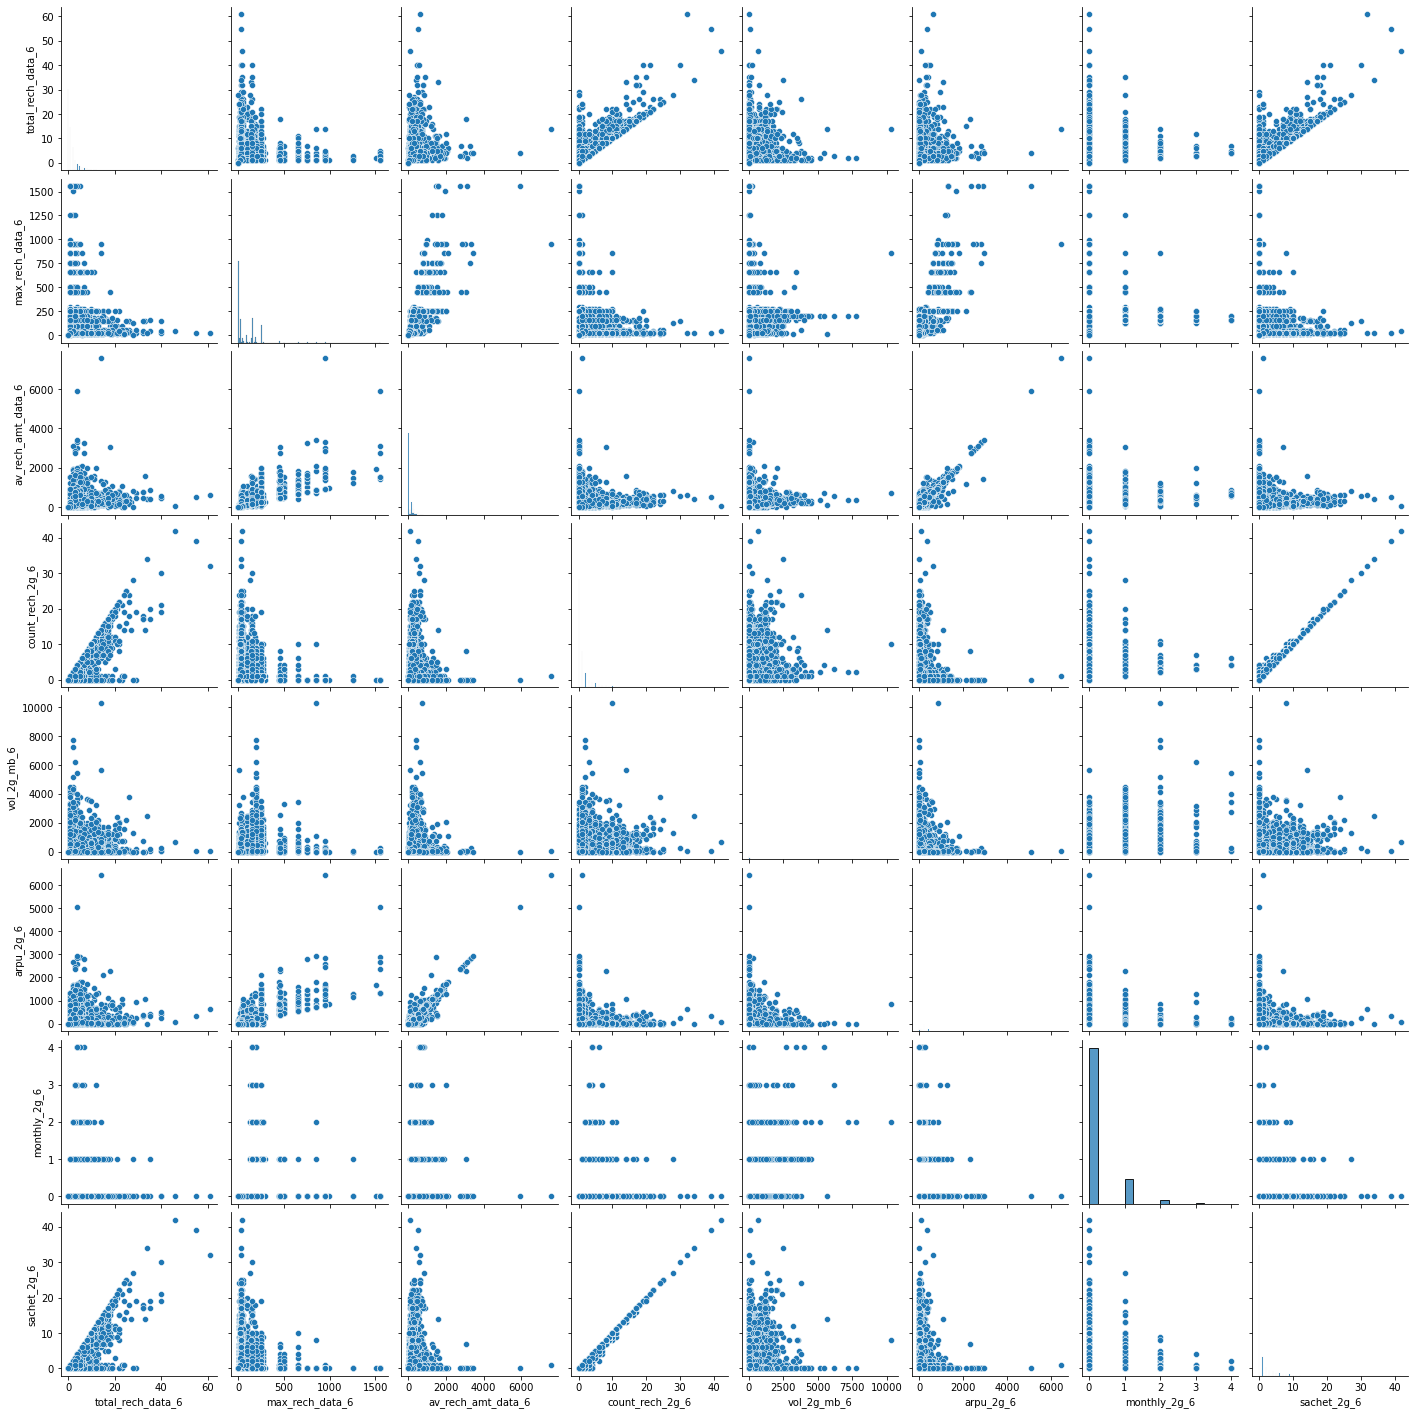

In [139]:
sns.pairplot(churn_df[data_m6_cols])

#### Observation
- Count Recharge 2g and Sachet 2g are highly correlated (forming a straight line)
- average recharge amount and arpu 2g have a positive linear-ish relationship

##### Scatter Plots among month six and seven

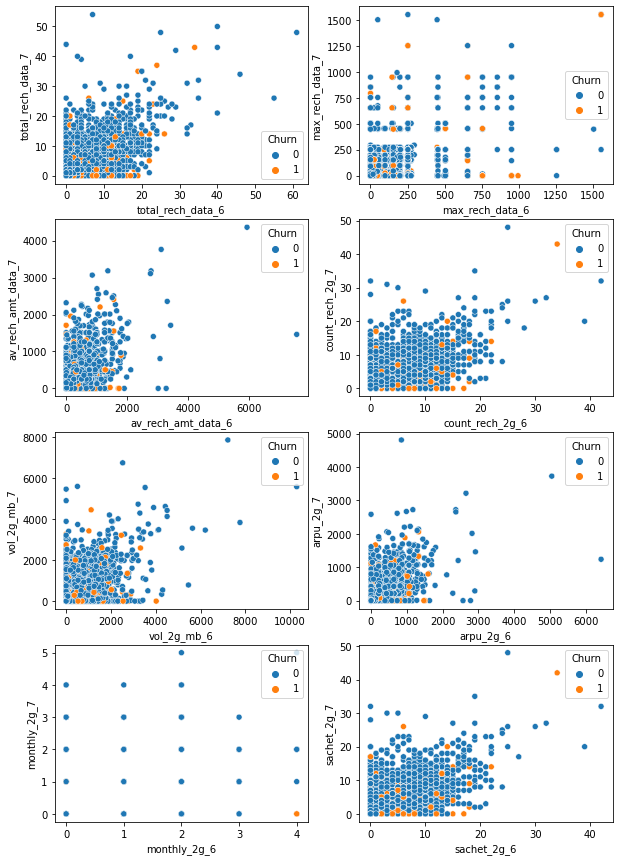

In [140]:
fig, ax = plt.subplots(4, 2, figsize=(10, 15))
r = 0
c = 0
for index, col in enumerate(data_m6_cols):
    if index%2==0 and index!=0:
        r+=1
        c=0
    m6_col = col
    m7_col = col.replace('6', '7')
    sns.scatterplot(x=m6_col, y=m7_col, data=churn_df, ax=ax[r][c], hue='Churn')
    c+=1
plt.show()

##### Scatter Plots among average of month six and seven and month eight

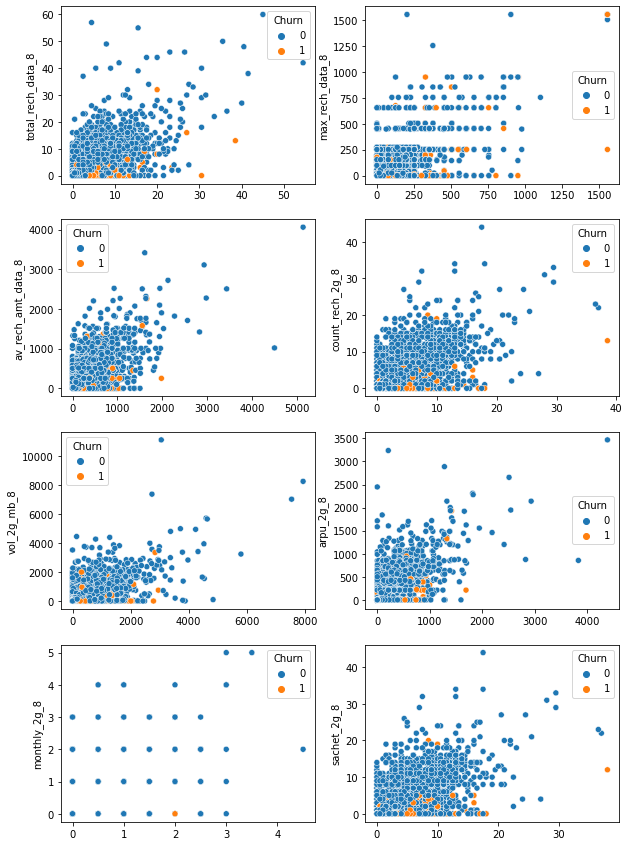

In [141]:
fig, ax = plt.subplots(4, 2, figsize=(10, 15))
r = 0
c = 0
for index, col in enumerate(data_m6_cols):
    if index%2==0 and index!=0:
        r+=1
        c=0
    m6_col = col
    m7_col = col.replace('6', '7')
    m8_col = col.replace('6', '8')
    av = (churn_df[m6_col]+churn_df[m7_col])/2
    sns.scatterplot(x=av, y=m8_col, data=churn_df, hue='Churn', ax=ax[r][c])
    c+=1
plt.show()

##### Observation
- Month 6 and 7 data looks somewhat overlapping

---

### Combining Good Phase columns

In [142]:
month_six_cols = get_cols(churn_df, '_6')
print(month_six_cols)

['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'last_day_rch_amt_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6', 'fb_user_6', 'vbc_3g_6', 'total_rech_data_amt_6', 'total_rech_call_plus_data_6', 'num_of_days_last_rech_6']


In [143]:
### Taking average of sixth and seventh month
for month_six_col in month_six_cols:
    month_sev_col = month_six_col.replace('6', '7')
    av_col = month_six_col.replace('6', 'av_good_phase')
    print(month_six_col, month_sev_col)
    average = (churn_df[month_six_col] + churn_df[month_sev_col])/2
#     print(churn_df[month_six_col].head())
#     print(churn_df[month_sev_col].head())
#     print(average.head())
    churn_df[av_col] = average

arpu_6 arpu_7
onnet_mou_6 onnet_mou_7
offnet_mou_6 offnet_mou_7
roam_ic_mou_6 roam_ic_mou_7
roam_og_mou_6 roam_og_mou_7
loc_og_t2t_mou_6 loc_og_t2t_mou_7
loc_og_t2m_mou_6 loc_og_t2m_mou_7
loc_og_t2f_mou_6 loc_og_t2f_mou_7
loc_og_t2c_mou_6 loc_og_t2c_mou_7
loc_og_mou_6 loc_og_mou_7
std_og_t2t_mou_6 std_og_t2t_mou_7
std_og_t2m_mou_6 std_og_t2m_mou_7
std_og_t2f_mou_6 std_og_t2f_mou_7
std_og_mou_6 std_og_mou_7
isd_og_mou_6 isd_og_mou_7
spl_og_mou_6 spl_og_mou_7
og_others_6 og_others_7
total_og_mou_6 total_og_mou_7
loc_ic_t2t_mou_6 loc_ic_t2t_mou_7
loc_ic_t2m_mou_6 loc_ic_t2m_mou_7
loc_ic_t2f_mou_6 loc_ic_t2f_mou_7
loc_ic_mou_6 loc_ic_mou_7
std_ic_t2t_mou_6 std_ic_t2t_mou_7
std_ic_t2m_mou_6 std_ic_t2m_mou_7
std_ic_t2f_mou_6 std_ic_t2f_mou_7
std_ic_mou_6 std_ic_mou_7
total_ic_mou_6 total_ic_mou_7
spl_ic_mou_6 spl_ic_mou_7
isd_ic_mou_6 isd_ic_mou_7
ic_others_6 ic_others_7
total_rech_num_6 total_rech_num_7
total_rech_amt_6 total_rech_amt_7
max_rech_amt_6 max_rech_amt_7
last_day_rch_amt_6 last_

<ipython-input-143-1f9c8f216a67>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_df[av_col] = average


In [144]:
churn_df.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0    197.385   214.816   213.803         0.00         0.00         0.00   
7   1069.180  1349.850  3171.480        57.84        54.68        52.29   
8    378.721   492.223   137.362       413.69       351.03        35.08   
21   514.453   597.753   637.760       102.41       132.11        85.14   
23    74.350   193.897   366.966        48.96        50.66        33.58   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0           0.00          0.00          0.00           0.00           0.00   
7         453.43        567.16        325.91          16.23          33.49   
8          94.66         80.63        136.48           0.00           0.00   
21        757.93        896.68        983.39           0.00           0.00   
23         85.41         89.36        205.89           0.00           0.00   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.00           0.00           0.00           0.00   
7           31.64          23.74          12.59          38.06   
8            0.00           0.00           0.00           0.00   
21           0.00           0.00           0.00           0.00   
23           0.00           0.00           0.00           0.00   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0               0.00              0.00              0.00              0.00   
7              51.39             31.38             40.28            308.63   
8             297.13            217.59             12.49             80.96   
21              4.48              6.16             23.34             91.81   
23             48.96             50.66             33.58             82.94   

    loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0               0.00              0.00              0.00              0.00   
7             447.38            162.28             62.13             55.14   
8              70.58             50.54              0.00              0.00   
21             87.93            104.81              0.75              0.00   
23             83.01            148.56              0.00              0.00   

    loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0               0.00               0.0               0.0              0.00   
7              53.23               0.0               0.0              0.00   
8               0.00               0.0               0.0              7.15   
21              1.58               0.0               0.0              0.00   
23              0.00               0.0               0.0             17.71   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0           0.00          0.00          0.00              0.00   
7         422.16        533.91        255.79              4.30   
8         378.09        288.18         63.04            116.56   
21         97.04         94.09        129.74             97.93   
23        131.91        133.68        182.14              0.00   

    std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0               0.00              0.00              0.00              0.00   
7              23.29             12.01             49.89             31.76   
8             133.43             22.58             13.69             10.04   
21            125.94             61.79            665.36            808.74   
23              0.00              0.00              2.36              6.35   

    std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.00              0.00              0.00              0.00   
7              49.14              6.66             20.08             16.68   
8              75.69              0.00              0.00              0.00   
21            876.99              0.00              0.00              0.00   
23             39.61      

In [145]:
churn_df.shape

(29880, 215)

In [146]:
churn_df.drop(month_six_cols, axis=1, inplace=True)

C:\Users\ayush\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [147]:
month_sev_cols = get_cols(churn_df, '_7')

In [148]:
print(month_sev_cols)

['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7', 'spl_og_mou_7', 'og_others_7', 'total_og_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_7', 'isd_ic_mou_7', 'ic_others_7', 'total_rech_num_7', 'total_rech_amt_7', 'max_rech_amt_7', 'last_day_rch_amt_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'vol_2g_mb_7', 'vol_3g_mb_7', 'arpu_3g_7', 'arpu_2g_7', 'night_pck_user_7', 'monthly_2g_7', 'sachet_2g_7', 'monthly_3g_7', 'sachet_3g_7', 'fb_user_7', 'vbc_3g_7', 'total_rech_data_amt_7', 'total_rech_call_plus_data_7', 'num_of_days_last_rech_7']


In [149]:
churn_df.drop(month_sev_cols, axis=1, inplace=True)

In [150]:
churn_df.shape

(29880, 109)

In [151]:
churn_df.head()

arpu_8  onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
0    213.803         0.00          0.00           0.00           0.00   
7   3171.480        52.29        325.91          31.64          38.06   
8    137.362        35.08        136.48           0.00           0.00   
21   637.760        85.14        983.39           0.00           0.00   
23   366.966        33.58        205.89           0.00           0.00   

    loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
0               0.00              0.00              0.00              0.00   
7              40.28            162.28             53.23              0.00   
8              12.49             50.54              0.00              7.15   
21             23.34            104.81              1.58              0.00   
23             33.58            148.56              0.00             17.71   

    loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  std_og_t2f_mou_8  \
0           0.00              0.00              0.00              0.00   
7         255.79             12.01             49.14             16.68   
8          63.04             22.58             75.69              0.00   
21        129.74             61.79            876.99              0.00   
23        182.14              0.00             39.61              0.00   

    std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  total_og_mou_8  \
0           0.00          0.00          0.00          0.0            0.00   
7          77.84         10.01          6.50          0.0          350.16   
8          98.28          0.00         10.23          0.0          171.56   
21        938.79          0.00          0.00          0.0         1068.54   
23         39.61          0.00         17.71          0.0          239.48   

    loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  \
0               0.16              4.13              1.15          5.44   
7              27.31            121.19             39.53        188.04   
8               0.31             15.48              0.00         15.79   
21             19.54            129.16             10.39        159.11   
23             76.64            146.84              0.71        224.21   

    std_ic_t2t_mou_8  std_ic_t2m_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  \
0               0.00              0.00              0.00          0.00   
7              30.39            141.33             22.21        193.94   
8               0.10              0.65              0.00          0.75   
21              0.18            101.74              0.00        101.93   
23             13.38             43.91              0.00         57.29   

    total_ic_mou_8  spl_ic_mou_8  isd_ic_mou_8  ic_others_8  total_rech_num_8  \
0             5.44           0.0          0.00         0.00                 2   
7           428.74           0.0         31.59        15.14                 7   
8            16.54           0.0          0.00         0.00                14   
21          261.04           0.0          0.00         0.00                27   
23          298.33           0.0          3.74        13.06                 4   

    total_rech_amt_8  max_rech_amt_8  last_day_rch_amt_8  total_rech_data_8  \
0                252             252                 252                1.0   
7               3638            1580                 779                0.0   
8                120              30                  10                3.0   
21               718              50                  50                0.0   
23               439             179                   0                2.0   

    max_rech_data_8  count_rech_2g_8  count_rech_3g_8  av_rech_amt_data_8  \
0             252.0              0.0              1.0               252.0   
7               0.0              0.0              0.0                 0.0   
8              23.0              3.0              0.0                69.0   
21              0.0           

#### Renaming Month 8 columns to contain keyword action instead of 8

In [152]:
month_8_cols = get_cols(churn_df, '8')

In [153]:
month_8_action_map = {}
for col in month_8_cols:
    val = col.replace('_8', '_action_phase')
    month_8_action_map[col] = val
month_8_action_map

{'arpu_8': 'arpu_action_phase',
 'onnet_mou_8': 'onnet_mou_action_phase',
 'offnet_mou_8': 'offnet_mou_action_phase',
 'roam_ic_mou_8': 'roam_ic_mou_action_phase',
 'roam_og_mou_8': 'roam_og_mou_action_phase',
 'loc_og_t2t_mou_8': 'loc_og_t2t_mou_action_phase',
 'loc_og_t2m_mou_8': 'loc_og_t2m_mou_action_phase',
 'loc_og_t2f_mou_8': 'loc_og_t2f_mou_action_phase',
 'loc_og_t2c_mou_8': 'loc_og_t2c_mou_action_phase',
 'loc_og_mou_8': 'loc_og_mou_action_phase',
 'std_og_t2t_mou_8': 'std_og_t2t_mou_action_phase',
 'std_og_t2m_mou_8': 'std_og_t2m_mou_action_phase',
 'std_og_t2f_mou_8': 'std_og_t2f_mou_action_phase',
 'std_og_mou_8': 'std_og_mou_action_phase',
 'isd_og_mou_8': 'isd_og_mou_action_phase',
 'spl_og_mou_8': 'spl_og_mou_action_phase',
 'og_others_8': 'og_others_action_phase',
 'total_og_mou_8': 'total_og_mou_action_phase',
 'loc_ic_t2t_mou_8': 'loc_ic_t2t_mou_action_phase',
 'loc_ic_t2m_mou_8': 'loc_ic_t2m_mou_action_phase',
 'loc_ic_t2f_mou_8': 'loc_ic_t2f_mou_action_phase',
 'lo

In [154]:
churn_df.rename(columns=month_8_action_map, inplace=True)

C:\Users\ayush\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [155]:
churn_df.head()

arpu_action_phase  onnet_mou_action_phase  offnet_mou_action_phase  \
0             213.803                    0.00                     0.00   
7            3171.480                   52.29                   325.91   
8             137.362                   35.08                   136.48   
21            637.760                   85.14                   983.39   
23            366.966                   33.58                   205.89   

    roam_ic_mou_action_phase  roam_og_mou_action_phase  \
0                       0.00                      0.00   
7                      31.64                     38.06   
8                       0.00                      0.00   
21                      0.00                      0.00   
23                      0.00                      0.00   

    loc_og_t2t_mou_action_phase  loc_og_t2m_mou_action_phase  \
0                          0.00                         0.00   
7                         40.28                       162.28   
8                         12.49                        50.54   
21                        23.34                       104.81   
23                        33.58                       148.56   

    loc_og_t2f_mou_action_phase  loc_og_t2c_mou_action_phase  \
0                          0.00                         0.00   
7                         53.23                         0.00   
8                          0.00                         7.15   
21                         1.58                         0.00   
23                         0.00                        17.71   

    loc_og_mou_action_phase  std_og_t2t_mou_action_phase  \
0                      0.00                         0.00   
7                    255.79                        12.01   
8                     63.04                        22.58   
21                   129.74                        61.79   
23                   182.14                         0.00   

    std_og_t2m_mou_action_phase  std_og_t2f_mou_action_phase  \
0                          0.00                         0.00   
7                         49.14                        16.68   
8                         75.69                         0.00   
21                       876.99                         0.00   
23                        39.61                         0.00   

    std_og_mou_action_phase  isd_og_mou_action_phase  spl_og_mou_action_phase  \
0                      0.00                     0.00                     0.00   
7                     77.84                    10.01                     6.50   
8                     98.28                     0.00                    10.23   
21                   938.79                     0.00                     0.00   
23                    39.61                     0.00                    17.71   

    og_others_action_phase  total_og_mou_action_phase  \
0                      0.0                       0.00   
7                      0.0                     350.16   
8                      0.0                     171.56   
21                     0.0                    1068.54   
23                     0.0                     239.48   

    loc_ic_t2t_mou_action_phase  loc_ic_t2m_mou_action_phase  \
0                          0.16                         4.13   
7                         27.31                       121.19   
8                          0.31                        15.48   
21                        19.54                       129.16   
23                        76.64                       146.84   

    loc_ic_t2f_mou_action_phase  loc_ic_mou_action_phase  \
0                          1.15                     5.44   
7                         39.53                   188.04   
8                          0.00                    15.79   
21                        10.39                   159.11   
23                         0.71                   224.21   

    std_ic_t2t_mou_action_phase  std_ic_t2m_mou_action_phase  \
0                          0.00                       

##### reordering columns such that we see good phase then action phase of particular value

In [156]:
good_phase_cols = get_cols(churn_df, 'av_good')

In [157]:
action_phase_cols = get_cols(churn_df, 'action')

In [158]:
len(good_phase_cols)

53

In [159]:
len(action_phase_cols)

53

In [160]:
reordered_cols = []
for index, col in enumerate(good_phase_cols):
    reordered_cols.extend([good_phase_cols[index], action_phase_cols[index]])

print(reordered_cols)

['arpu_av_good_phase', 'arpu_action_phase', 'onnet_mou_av_good_phase', 'onnet_mou_action_phase', 'offnet_mou_av_good_phase', 'offnet_mou_action_phase', 'roam_ic_mou_av_good_phase', 'roam_ic_mou_action_phase', 'roam_og_mou_av_good_phase', 'roam_og_mou_action_phase', 'loc_og_t2t_mou_av_good_phase', 'loc_og_t2t_mou_action_phase', 'loc_og_t2m_mou_av_good_phase', 'loc_og_t2m_mou_action_phase', 'loc_og_t2f_mou_av_good_phase', 'loc_og_t2f_mou_action_phase', 'loc_og_t2c_mou_av_good_phase', 'loc_og_t2c_mou_action_phase', 'loc_og_mou_av_good_phase', 'loc_og_mou_action_phase', 'std_og_t2t_mou_av_good_phase', 'std_og_t2t_mou_action_phase', 'std_og_t2m_mou_av_good_phase', 'std_og_t2m_mou_action_phase', 'std_og_t2f_mou_av_good_phase', 'std_og_t2f_mou_action_phase', 'std_og_mou_av_good_phase', 'std_og_mou_action_phase', 'isd_og_mou_av_good_phase', 'isd_og_mou_action_phase', 'spl_og_mou_av_good_phase', 'spl_og_mou_action_phase', 'og_others_av_good_phase', 'og_others_action_phase', 'total_og_mou_av_goo

In [161]:
reordered_cols.append('Churn')
reordered_cols.insert(0, 'aon')

In [162]:
churn_df = churn_df[reordered_cols]

In [163]:
churn_df.head()

aon  arpu_av_good_phase  arpu_action_phase  onnet_mou_av_good_phase  \
0   968            206.1005            213.803                     0.00   
7   802           1209.5150           3171.480                    56.26   
8   315            435.4720            137.362                   382.36   
21  720            556.1030            637.760                   117.26   
23  604            134.1235            366.966                    49.81   

    onnet_mou_action_phase  offnet_mou_av_good_phase  offnet_mou_action_phase  \
0                     0.00                     0.000                     0.00   
7                    52.29                   510.295                   325.91   
8                    35.08                    87.645                   136.48   
21                   85.14                   827.305                   983.39   
23                   33.58                    87.385                   205.89   

    roam_ic_mou_av_good_phase  roam_ic_mou_action_phase  \
0                        0.00                      0.00   
7                       24.86                     31.64   
8                        0.00                      0.00   
21                       0.00                      0.00   
23                       0.00                      0.00   

    roam_og_mou_av_good_phase  roam_og_mou_action_phase  \
0                       0.000                      0.00   
7                      18.165                     38.06   
8                       0.000                      0.00   
21                      0.000                      0.00   
23                      0.000                      0.00   

    loc_og_t2t_mou_av_good_phase  loc_og_t2t_mou_action_phase  \
0                          0.000                         0.00   
7                         41.385                        40.28   
8                        257.360                        12.49   
21                         5.320                        23.34   
23                        49.810                        33.58   

    loc_og_t2m_mou_av_good_phase  loc_og_t2m_mou_action_phase  \
0                          0.000                         0.00   
7                        378.005                       162.28   
8                         75.770                        50.54   
21                        89.870                       104.81   
23                        82.975                       148.56   

    loc_og_t2f_mou_av_good_phase  loc_og_t2f_mou_action_phase  \
0                          0.000                         0.00   
7                         58.635                        53.23   
8                          0.000                         0.00   
21                         0.375                         1.58   
23                         0.000                         0.00   

    loc_og_t2c_mou_av_good_phase  loc_og_t2c_mou_action_phase  \
0                            0.0                         0.00   
7                            0.0                         0.00   
8                            0.0                         7.15   
21                           0.0                         0.00   
23                           0.0                        17.71   

    loc_og_mou_av_good_phase  loc_og_mou_action_phase  \
0                      0.000                     0.00   
7                    478.035                   255.79   
8                    333.135                    63.04   
21                    95.565                   129.74   
23                   132.795                   182.14   

    std_og_t2t_mou_av_good_phase  std_og_t2t_mou_action_phase  \
0                          0.000                         0.00   
7                         13.795                        12.01   
8                        124.995                        22.58   
21                       111.935                        61.79   
23                         0.000                         0.00   

    std_og_t2m_mou_av_good_phase  std_og_t2m_mou_action_ph

##### Initial Data Preparation is complete

---

## Model Building

#### Initial Model Building General steps:
- Separate target variable and features
- train test split
- Scaling
- PCA
- Model training
- Model Evaluation

In [164]:
churn_df_copy = churn_df.copy()

### Split X and y

In [165]:
y = churn_df.pop('Churn')

X = churn_df

X.shape, y.shape

((29880, 107), (29880,))

### Train Test Split

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23904, 107), (5976, 107), (23904,), (5976,))

### Scaling the dataset

In [167]:
scaler = StandardScaler()

In [168]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Building the initial Logisitic Regression model

In [169]:
pca = PCA(0.95, random_state=42)

In [170]:
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

In [171]:
log_reg = LogisticRegression(random_state=42)

log_reg.fit(X_train_scaled_pca, y_train)

LogisticRegression(random_state=42)

In [172]:
y_train_pred = log_reg.predict(X_train_scaled_pca)

print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.932270749665328
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     22005
           1       0.68      0.28      0.40      1899

    accuracy                           0.93     23904
   macro avg       0.81      0.63      0.68     23904
weighted avg       0.92      0.93      0.92     23904



In [173]:
X_test_scaled_pca = pca.transform(X_test_scaled)

In [174]:
y_test_pred = log_reg.predict(X_test_scaled_pca)

print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

0.927376171352075
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5459
           1       0.68      0.30      0.42       517

    accuracy                           0.93      5976
   macro avg       0.81      0.64      0.69      5976
weighted avg       0.92      0.93      0.91      5976



In [175]:
confusion_matrix(y_test, y_test_pred)

array([[5388,   71],
       [ 363,  154]], dtype=int64)

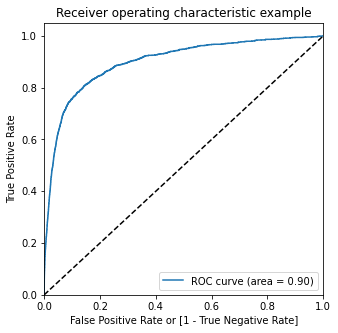

In [178]:
draw_roc(y_train, log_reg.predict_proba(X_train_scaled_pca)[:, 1])

In [225]:
clf_df = classification_metrics(y_train, y_train_pred, 'logistic_with_pca_train')
clf_df.head()

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.28         0.99      0.93       0.68    0.28  0.28  0.72       0.4

In [226]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train, log_reg.predict_proba(X_train_scaled_pca), thresholds)

In [227]:
threshold_df.head(2)

Actual Churn  Probability  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0             0     0.001649    1    0    0    0    0    0    0    0    0    0
1             0     0.145446    1    1    0    0    0    0    0    0    0    0

In [228]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df

prob  accuracy     sensi     speci
0.0   0.0  0.079443  1.000000  0.000000
0.1   0.1  0.846218  0.813586  0.849034
0.2   0.2  0.913696  0.698262  0.932288
0.3   0.3  0.929803  0.560821  0.961645
0.4   0.4  0.933066  0.402317  0.978868
0.5   0.5  0.932271  0.279621  0.988594
0.6   0.6  0.931058  0.205898  0.993638
0.7   0.7  0.929259  0.141127  0.997273
0.8   0.8  0.926539  0.085308  0.999137
0.9   0.9  0.923151  0.033702  0.999909

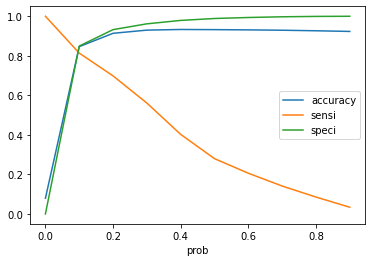

In [229]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [230]:
metrics_on_different_thresholds(y_train, thresholds, threshold_df)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  \
0.0         1.00         0.00      0.08       0.08    1.00  1.00  0.00   
0.1         0.81         0.85      0.85       0.32    0.81  0.81  0.19   
0.2         0.70         0.93      0.91       0.47    0.70  0.70  0.30   
0.3         0.56         0.96      0.93       0.56    0.56  0.56  0.44   
0.4         0.40         0.98      0.93       0.62    0.40  0.40  0.60   
0.5         0.28         0.99      0.93       0.68    0.28  0.28  0.72   
0.6         0.21         0.99      0.93       0.74    0.21  0.21  0.79   
0.7         0.14         1.00      0.93       0.82    0.14  0.14  0.86   
0.8         0.09         1.00      0.93       0.90    0.09  0.09  0.91   
0.9         0.03         1.00      0.92       0.97    0.03  0.03  0.97   

     F1_score  
0.0      0.15  
0.1      0.46  
0.2      0.56  
0.3      0.56  
0.4      0.49  
0.5      0.40  
0.6      0.32  
0.7      0.24  
0.8      0.16  
0.9      0.07

**On observing the performance of the model on all different thresholds, we choose `0.1` as the cutoff as according the business problem sensitivity/recall is the most important metric for us**

In [243]:
clf_df = classification_metrics(y_train, threshold_df[0.1], 'logistic_with_pca_train')
clf_df.head()

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.81         0.85      0.85       0.32    0.81  0.81  0.19      0.46

In [244]:
threshold_df_test = generate_prob_threshold_df(y_test, log_reg.predict_proba(X_test_scaled_pca), thresholds)
classification_metrics(y_test, threshold_df_test[0.1], 'logistic_with_pca_test')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.81         0.84      0.84       0.33    0.81  0.81  0.19      0.47

In [245]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df.head()

sensitivity  specificity  accuracy  precision  \
logistic_with_pca_train         0.81         0.85      0.85       0.32   
logistic_with_pca_test          0.81         0.84      0.84       0.33   

                         recall   TPR   FNR  F1_score  
logistic_with_pca_train    0.81  0.81  0.19      0.46  
logistic_with_pca_test     0.81  0.81  0.19      0.47

#### Even though we get a good accuracy but our recall for the churn class is somewhat low on the test data, therefore, we need to optimize our data.

---

#### **Since there is high class imabalance in our dataset, we apply SMOTE to handle class imbalance**

### Applying SMOTE

In [264]:
smote = SMOTE(random_state=42)

X_train_scaled_pca_smote, y_train_smote =  smote.fit_resample(X_train_scaled_pca, y_train)

In [265]:
X_train_scaled_pca_smote.shape, X_train_scaled.shape

((44010, 53), (23904, 107))

In [266]:
log_reg_smote = LogisticRegression(random_state=42)
log_reg_smote.fit(X_train_scaled_pca_smote, y_train_smote)

LogisticRegression(random_state=42)

In [267]:
y_train_smote.shape

(44010,)

In [268]:
y_train_smote_pred = log_reg_smote.predict(X_train_scaled_pca_smote)

print(accuracy_score(y_train_smote, y_train_smote_pred))
print(classification_report(y_train_smote, y_train_smote_pred))
confusion_matrix(y_train_smote, y_train_smote_pred)

0.8446034992047262
              precision    recall  f1-score   support

           0       0.86      0.83      0.84     22005
           1       0.83      0.86      0.85     22005

    accuracy                           0.84     44010
   macro avg       0.84      0.84      0.84     44010
weighted avg       0.84      0.84      0.84     44010



array([[18226,  3779],
       [ 3060, 18945]], dtype=int64)

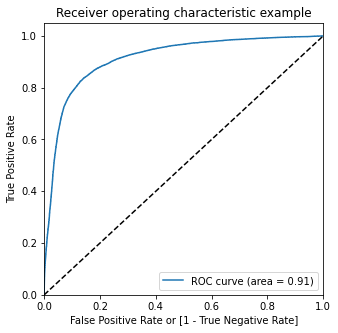

In [269]:
draw_roc(y_train_smote, log_reg_smote.predict_proba(X_train_scaled_pca_smote)[:, 1])

In [270]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train_smote, log_reg_smote.predict_proba(X_train_scaled_pca_smote), thresholds)

In [271]:
threshold_df.head()

Actual Churn  Probability  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0             0     0.046092    1    0    0    0    0    0    0    0    0    0
1             0     0.532679    1    1    1    1    1    1    0    0    0    0
2             0     0.000162    1    0    0    0    0    0    0    0    0    0
3             0     0.000375    1    0    0    0    0    0    0    0    0    0
4             0     0.004492    1    0    0    0    0    0    0    0    0    0

In [272]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df.head()

prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.703408  0.976005  0.430811
0.2   0.2  0.768462  0.954828  0.582095
0.3   0.3  0.806930  0.929471  0.684390
0.4   0.4  0.830652  0.899523  0.761781

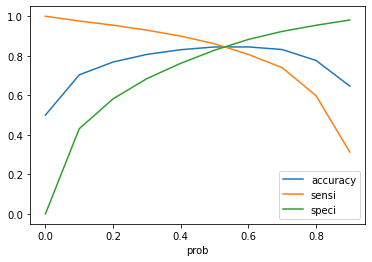

In [273]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Observation: From the above plot we get that the most optimal cutoff for accuracy, sensitivity and specificty is around `0.4`**

In [274]:
metrics_on_different_thresholds(y_train_smote, thresholds, threshold_df)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  \
0.0         1.00         0.00      0.50       0.50    1.00  1.00  0.00   
0.1         0.98         0.43      0.70       0.63    0.98  0.98  0.02   
0.2         0.95         0.58      0.77       0.70    0.95  0.95  0.05   
0.3         0.93         0.68      0.81       0.75    0.93  0.93  0.07   
0.4         0.90         0.76      0.83       0.79    0.90  0.90  0.10   
0.5         0.86         0.83      0.84       0.83    0.86  0.86  0.14   
0.6         0.81         0.88      0.84       0.87    0.81  0.81  0.19   
0.7         0.74         0.92      0.83       0.91    0.74  0.74  0.26   
0.8         0.60         0.95      0.78       0.93    0.60  0.60  0.40   
0.9         0.31         0.98      0.65       0.94    0.31  0.31  0.69   

     F1_score  
0.0      0.67  
0.1      0.77  
0.2      0.80  
0.3      0.83  
0.4      0.84  
0.5      0.85  
0.6      0.84  
0.7      0.81  
0.8      0.73  
0.9      0.47

In [275]:
classification_metrics(y_train_smote, threshold_df[0.4], 'logistic_pca_smote_train')

sensitivity  specificity  accuracy  precision  recall  TPR  FNR  F1_score
0          0.9         0.76      0.83       0.79     0.9  0.9  0.1      0.84

In [276]:
threshold_df_test = generate_prob_threshold_df(y_test, log_reg_smote.predict_proba(X_test_scaled_pca), thresholds)
classification_metrics(y_test, threshold_df_test[0.4], 'logistic_with_pca_smote_test')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.86         0.76      0.76       0.25    0.86  0.86  0.14      0.39

In [277]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df.head()

sensitivity  specificity  accuracy  precision  \
logistic_with_pca_train              0.81         0.85      0.85       0.32   
logistic_with_pca_test               0.81         0.84      0.84       0.33   
logistic_pca_smote_train             0.90         0.76      0.83       0.79   
logistic_with_pca_smote_test         0.86         0.76      0.76       0.25   

                              recall   TPR   FNR  F1_score  
logistic_with_pca_train         0.81  0.81  0.19      0.46  
logistic_with_pca_test          0.81  0.81  0.19      0.47  
logistic_pca_smote_train        0.90  0.90  0.10      0.84  
logistic_with_pca_smote_test    0.86  0.86  0.14      0.39

### From the logistic regression algorithm after PCA and SMOTE, gives us an accuracy of ~76% and also recall of ~86%.

---

### Now, we will look to improve the performance of our predictive model further by trying different techniques like Outlier treatment and later on different models.

### Outlier Treatment

In [279]:
churn_df.head()

aon  arpu_av_good_phase  arpu_action_phase  onnet_mou_av_good_phase  \
0   968            206.1005            213.803                     0.00   
7   802           1209.5150           3171.480                    56.26   
8   315            435.4720            137.362                   382.36   
21  720            556.1030            637.760                   117.26   
23  604            134.1235            366.966                    49.81   

    onnet_mou_action_phase  offnet_mou_av_good_phase  offnet_mou_action_phase  \
0                     0.00                     0.000                     0.00   
7                    52.29                   510.295                   325.91   
8                    35.08                    87.645                   136.48   
21                   85.14                   827.305                   983.39   
23                   33.58                    87.385                   205.89   

    roam_ic_mou_av_good_phase  roam_ic_mou_action_phase  \
0                        0.00                      0.00   
7                       24.86                     31.64   
8                        0.00                      0.00   
21                       0.00                      0.00   
23                       0.00                      0.00   

    roam_og_mou_av_good_phase  roam_og_mou_action_phase  \
0                       0.000                      0.00   
7                      18.165                     38.06   
8                       0.000                      0.00   
21                      0.000                      0.00   
23                      0.000                      0.00   

    loc_og_t2t_mou_av_good_phase  loc_og_t2t_mou_action_phase  \
0                          0.000                         0.00   
7                         41.385                        40.28   
8                        257.360                        12.49   
21                         5.320                        23.34   
23                        49.810                        33.58   

    loc_og_t2m_mou_av_good_phase  loc_og_t2m_mou_action_phase  \
0                          0.000                         0.00   
7                        378.005                       162.28   
8                         75.770                        50.54   
21                        89.870                       104.81   
23                        82.975                       148.56   

    loc_og_t2f_mou_av_good_phase  loc_og_t2f_mou_action_phase  \
0                          0.000                         0.00   
7                         58.635                        53.23   
8                          0.000                         0.00   
21                         0.375                         1.58   
23                         0.000                         0.00   

    loc_og_t2c_mou_av_good_phase  loc_og_t2c_mou_action_phase  \
0                            0.0                         0.00   
7                            0.0                         0.00   
8                            0.0                         7.15   
21                           0.0                         0.00   
23                           0.0                        17.71   

    loc_og_mou_av_good_phase  loc_og_mou_action_phase  \
0                      0.000                     0.00   
7                    478.035                   255.79   
8                    333.135                    63.04   
21                    95.565                   129.74   
23                   132.795                   182.14   

    std_og_t2t_mou_av_good_phase  std_og_t2t_mou_action_phase  \
0                          0.000                         0.00   
7                         13.795                        12.01   
8                        124.995                        22.58   
21                       111.935                        61.79   
23                         0.000                         0.00   

    std_og_t2m_mou_av_good_phase  std_og_t2m_mou_action_ph

C:\Users\ayush\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_rech_call_plus_data_av_good_phase'>

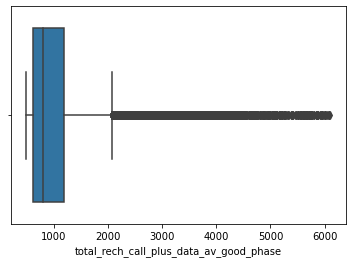

In [280]:
total_rech_ninety_nine_quantile = churn_df['total_rech_call_plus_data_av_good_phase'].quantile(0.99)
sns.boxplot(churn_df.loc[churn_df['total_rech_call_plus_data_av_good_phase'] <= total_rech_ninety_nine_quantile, 'total_rech_call_plus_data_av_good_phase'])

<AxesSubplot:>

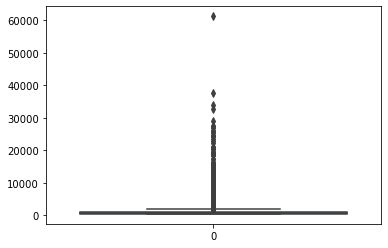

In [281]:
sns.boxplot(data=churn_df['total_rech_call_plus_data_av_good_phase'])

C:\Users\ayush\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='arpu_av_good_phase'>

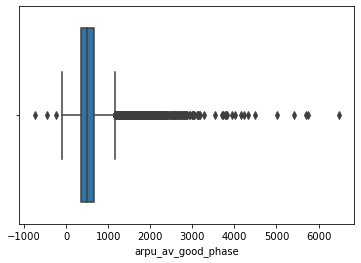

In [282]:
sns.boxplot(churn_df.loc[churn_df['total_rech_call_plus_data_av_good_phase'] <= total_rech_ninety_nine_quantile, 'arpu_av_good_phase'])

<AxesSubplot:>

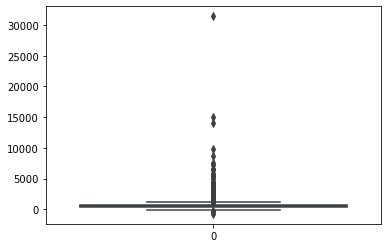

In [283]:
sns.boxplot(data=churn_df['arpu_av_good_phase'])

<AxesSubplot:xlabel='total_rech_call_plus_data_av_good_phase', ylabel='Density'>

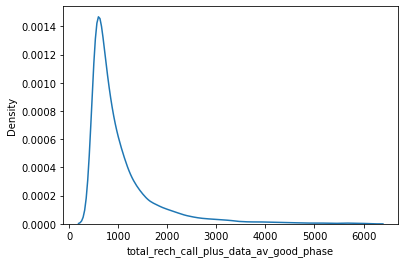

In [284]:
sns.kdeplot(churn_df.loc[churn_df['total_rech_call_plus_data_av_good_phase'] <= total_rech_ninety_nine_quantile, 'total_rech_call_plus_data_av_good_phase'])

**Observation: We see from the above plots that dropping one the top one perentile records make our data siginifcantly less skewed**

In [285]:
total_rech_ninety_nine_quantile

6106.944999999996

**Dropping the top 1% data based on total recharge amount including call and data for good phase**

In [306]:
# getting back the original churn_df dataframe
churn_df_without_outlier = churn_df_copy.copy()

In [307]:
# dropping the data
churn_df_without_outlier = churn_df_without_outlier[churn_df_without_outlier['total_rech_call_plus_data_av_good_phase'] <= total_rech_ninety_nine_quantile]
churn_df_without_outlier.shape

(29581, 108)

## Model Building steps:
- Separate target variable and features
- train test split
- Scaling
- PCA
- SMOTE
- Model training
- Model Evaluation

### Logistic Regression with PCA and SMOTE after Outlier Treatment

In [308]:
y = churn_df_without_outlier.pop('Churn')
X = churn_df_without_outlier

In [309]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [310]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [311]:
pca = PCA(0.95, random_state=42)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [312]:
smote = SMOTE(random_state=42)
X_train_scaled_pca_smote, y_train_smote = smote.fit_resample(X_train_scaled_pca, y_train)

In [313]:
log_reg_smote = LogisticRegression(random_state=42)
log_reg_smote.fit(X_train_scaled_pca_smote, y_train_smote)

LogisticRegression(random_state=42)

In [314]:
y_train_smote_pred = log_reg_smote.predict(X_train_scaled_pca_smote)

print(accuracy_score(y_train_smote, y_train_smote_pred))
print(classification_report(y_train_smote, y_train_smote_pred))
confusion_matrix(y_train_smote, y_train_smote_pred)

0.8447418121516421
              precision    recall  f1-score   support

           0       0.86      0.83      0.84     21709
           1       0.83      0.86      0.85     21709

    accuracy                           0.84     43418
   macro avg       0.85      0.84      0.84     43418
weighted avg       0.85      0.84      0.84     43418



array([[18016,  3693],
       [ 3048, 18661]], dtype=int64)

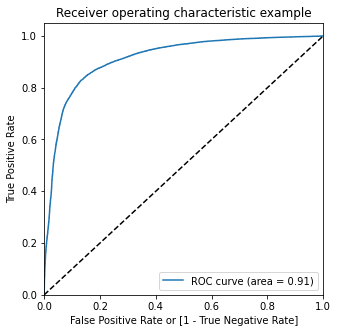

In [315]:
draw_roc(y_train_smote, log_reg_smote.predict_proba(X_train_scaled_pca_smote)[:, 1])

In [316]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train_smote, log_reg_smote.predict_proba(X_train_scaled_pca_smote), thresholds)

In [317]:
threshold_df.head()

Actual Churn  Probability  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0             1     0.991708    1    1    1    1    1    1    1    1    1    1
1             0     0.232619    1    1    1    0    0    0    0    0    0    0
2             0     0.475390    1    1    1    1    1    0    0    0    0    0
3             0     0.026982    1    0    0    0    0    0    0    0    0    0
4             0     0.568408    1    1    1    1    1    1    0    0    0    0

In [318]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df.head()

prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.703925  0.977705  0.430144
0.2   0.2  0.768253  0.954857  0.581648
0.3   0.3  0.805495  0.925883  0.685108
0.4   0.4  0.829863  0.894191  0.765535

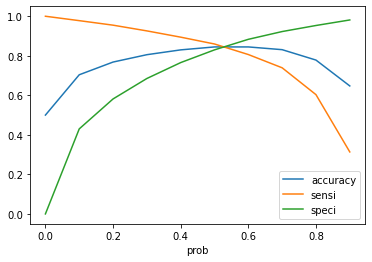

In [319]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Observation: From the above plot we get that the most optimal cutoff for accuracy, sensitivity and specificty is around 0.3**

In [320]:
metrics_on_different_thresholds(y_train_smote, thresholds, threshold_df)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  \
0.0         1.00         0.00      0.50       0.50    1.00  1.00  0.00   
0.1         0.98         0.43      0.70       0.63    0.98  0.98  0.02   
0.2         0.95         0.58      0.77       0.70    0.95  0.95  0.05   
0.3         0.93         0.69      0.81       0.75    0.93  0.93  0.07   
0.4         0.89         0.77      0.83       0.79    0.89  0.89  0.11   
0.5         0.86         0.83      0.84       0.83    0.86  0.86  0.14   
0.6         0.81         0.88      0.84       0.87    0.81  0.81  0.19   
0.7         0.74         0.92      0.83       0.91    0.74  0.74  0.26   
0.8         0.60         0.95      0.78       0.93    0.60  0.60  0.40   
0.9         0.31         0.98      0.65       0.94    0.31  0.31  0.69   

     F1_score  
0.0      0.67  
0.1      0.77  
0.2      0.80  
0.3      0.83  
0.4      0.84  
0.5      0.85  
0.6      0.84  
0.7      0.81  
0.8      0.73  
0.9      0.47

In [332]:
classification_metrics(y_train_smote, threshold_df[0.3], 'logistic_outlier_pca_smote_train')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.93         0.69      0.81       0.75    0.93  0.93  0.07      0.83

In [333]:
threshold_df_test = generate_prob_threshold_df(y_test, log_reg_smote.predict_proba(X_test_scaled_pca), thresholds)
classification_metrics(y_test, threshold_df_test[0.3], 'logistic_outlier_pca_smote_test')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.93         0.69       0.7       0.19    0.93  0.93  0.07      0.32

In [336]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df

sensitivity  specificity  accuracy  \
logistic_with_pca_train                  0.81         0.85      0.85   
logistic_with_pca_test                   0.81         0.84      0.84   
logistic_pca_smote_train                 0.89         0.77      0.83   
logistic_with_pca_smote_test             0.91         0.76      0.78   
logistic_outlier_pca_smote_train         0.93         0.69      0.81   
logistic_outlier_pca_smote_test          0.93         0.69      0.70   

                                  precision  recall   TPR   FNR  F1_score  
logistic_with_pca_train                0.32    0.81  0.81  0.19      0.46  
logistic_with_pca_test                 0.33    0.81  0.81  0.19      0.47  
logistic_pca_smote_train               0.79    0.89  0.89  0.11      0.84  
logistic_with_pca_smote_test           0.24    0.91  0.91  0.09      0.38  
logistic_outlier_pca_smote_train       0.75    0.93  0.93  0.07      0.83  
logistic_outlier_pca_smote_test        0.19    0.93  0.93  0.07      0.32

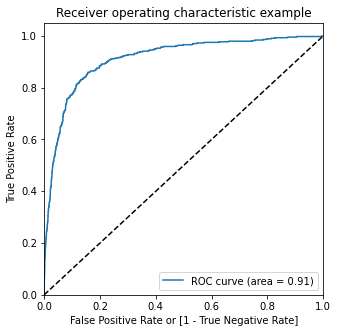

In [337]:
draw_roc(y_test, log_reg_smote.predict_proba(X_test_scaled_pca)[:, 1])

### From the logistic regression algorithm after PCA and SMOTE, gives us an accuracy of ~70% and also recall of ~93%.

---

### Model building train test split uing stratify

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [339]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [340]:
pca = PCA(0.95, random_state=42)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [341]:
smote = SMOTE(random_state=42)
X_train_scaled_pca_smote, y_train_smote = smote.fit_resample(X_train_scaled_pca, y_train)

In [343]:
log_reg_smote = LogisticRegression(random_state=42)
log_reg_smote.fit(X_train_scaled_pca_smote, y_train_smote)

LogisticRegression(random_state=42)

In [348]:
y_train_smote_pred = log_reg_smote.predict(X_train_scaled_pca_smote)

print(accuracy_score(y_train_smote, y_train_smote_pred))
print(classification_report(y_train_smote, y_train_smote_pred))
confusion_matrix(y_train_smote, y_train_smote_pred)

0.8528005150372482
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     21746
           1       0.84      0.87      0.86     21746

    accuracy                           0.85     43492
   macro avg       0.85      0.85      0.85     43492
weighted avg       0.85      0.85      0.85     43492



array([[18194,  3552],
       [ 2850, 18896]], dtype=int64)

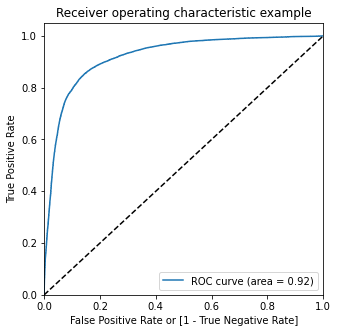

In [349]:
draw_roc(y_train_smote, log_reg_smote.predict_proba(X_train_scaled_pca_smote)[:, 1])

In [350]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train_smote, log_reg_smote.predict_proba(X_train_scaled_pca_smote), thresholds)

In [351]:
threshold_df.head()

Actual Churn  Probability  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0             0     0.002522    1    0    0    0    0    0    0    0    0    0
1             0     0.354796    1    1    1    1    0    0    0    0    0    0
2             0     0.130958    1    1    0    0    0    0    0    0    0    0
3             0     0.975560    1    1    1    1    1    1    1    1    1    1
4             0     0.043541    1    0    0    0    0    0    0    0    0    0

In [352]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df.head()

prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.723558  0.979996  0.467120
0.2   0.2  0.785846  0.957417  0.614274
0.3   0.3  0.819645  0.930654  0.708636
0.4   0.4  0.839925  0.901407  0.778442

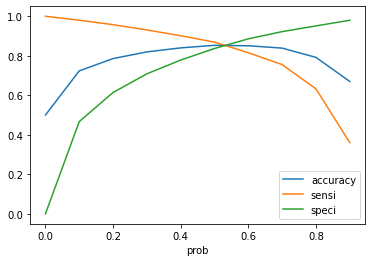

In [353]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Observation: From the above plot we get that the most optimal cutoff for accuracy, sensitivity and specificty is around `0.3`**

In [354]:
metrics_on_different_thresholds(y_train_smote, thresholds, threshold_df)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  \
0.0         1.00         0.00      0.50       0.50    1.00  1.00  0.00   
0.1         0.98         0.47      0.72       0.65    0.98  0.98  0.02   
0.2         0.96         0.61      0.79       0.71    0.96  0.96  0.04   
0.3         0.93         0.71      0.82       0.76    0.93  0.93  0.07   
0.4         0.90         0.78      0.84       0.80    0.90  0.90  0.10   
0.5         0.87         0.84      0.85       0.84    0.87  0.87  0.13   
0.6         0.82         0.89      0.85       0.88    0.82  0.82  0.18   
0.7         0.76         0.92      0.84       0.91    0.76  0.76  0.24   
0.8         0.63         0.95      0.79       0.93    0.63  0.63  0.37   
0.9         0.36         0.98      0.67       0.95    0.36  0.36  0.64   

     F1_score  
0.0      0.67  
0.1      0.78  
0.2      0.82  
0.3      0.84  
0.4      0.85  
0.5      0.86  
0.6      0.85  
0.7      0.82  
0.8      0.75  
0.9      0.52

In [355]:
classification_metrics(y_train_smote, threshold_df[0.3], 'logistic_outlier_stratified_pca_smote_train')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.93         0.71      0.82       0.76    0.93  0.93  0.07      0.84

In [356]:
threshold_df_test = generate_prob_threshold_df(y_test, log_reg_smote.predict_proba(X_test_scaled_pca), thresholds)
classification_metrics(y_test, threshold_df_test[0.3], 'logistic_outlier_stratified_pca_smote_test')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.89          0.7      0.72       0.21    0.89  0.89  0.11      0.34

In [357]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df

sensitivity  specificity  \
logistic_with_pca_train                             0.81         0.85   
logistic_with_pca_test                              0.81         0.84   
logistic_pca_smote_train                            0.89         0.77   
logistic_with_pca_smote_test                        0.91         0.76   
logistic_outlier_pca_smote_train                    0.93         0.69   
logistic_outlier_pca_smote_test                     0.93         0.69   
logistic_outlier_stratified_pca_smote_train         0.93         0.71   
logistic_outlier_stratified_pca_smote_test          0.89         0.70   

                                             accuracy  precision  recall  \
logistic_with_pca_train                          0.85       0.32    0.81   
logistic_with_pca_test                           0.84       0.33    0.81   
logistic_pca_smote_train                         0.83       0.79    0.89   
logistic_with_pca_smote_test                     0.78       0.24    0.91   
logistic_outlier_pca_smote_train                 0.81       0.75    0.93   
logistic_outlier_pca_smote_test                  0.70       0.19    0.93   
logistic_outlier_stratified_pca_smote_train      0.82       0.76    0.93   
logistic_outlier_stratified_pca_smote_test       0.72       0.21    0.89   

                                              TPR   FNR  F1_score  
logistic_with_pca_train                      0.81  0.19      0.46  
logistic_with_pca_test                       0.81  0.19      0.47  
logistic_pca_smote_train                     0.89  0.11      0.84  
logistic_with_pca_smote_test                 0.91  0.09      0.38  
logistic_outlier_pca_smote_train             0.93  0.07      0.83  
logistic_outlier_pca_smote_test              0.93  0.07      0.32  
logistic_outlier_stratified_pca_smote_train  0.93  0.07      0.84  
logistic_outlier_stratified_pca_smote_test   0.89  0.11      0.34

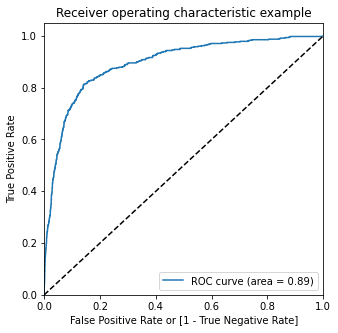

In [358]:
draw_roc(y_test, log_reg_smote.predict_proba(X_test_scaled_pca)[:, 1])

### From the logistic regression algorithm after PCA, SMOTE and Stratified Samplings, gives us an accuracy of ~72% and also recall of ~89%.

---

### Model: Decision Tree

In [362]:
dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=500)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=500, random_state=42)

In [363]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [364]:
classification_metrics(y_train, y_train_pred)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.52         0.98      0.95       0.73    0.52  0.52  0.48       0.6

In [365]:
y_train_pred = dt.predict(X_train)

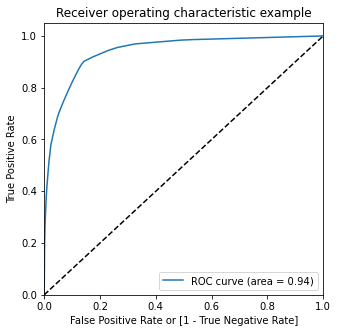

In [366]:
draw_roc(y_train, dt.predict_proba(X_train)[:, 1])

In [367]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train, dt.predict_proba(X_train), thresholds)

In [368]:
threshold_df.head()

Actual Churn  Probability  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0             0     0.002654    1    0    0    0    0    0    0    0    0    0
1             0     0.002654    1    0    0    0    0    0    0    0    0    0
2             0     0.002654    1    0    0    0    0    0    0    0    0    0
3             0     0.601307    1    1    1    1    1    1    1    0    0    0
4             0     0.002654    1    0    0    0    0    0    0    0    0    0

In [369]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df.head()

prob  accuracy     sensi     speci
0.0   0.0  0.081051  1.000000  0.000000
0.1   0.1  0.861435  0.901460  0.857905
0.2   0.2  0.927485  0.702815  0.947301
0.3   0.3  0.937627  0.638686  0.963993
0.4   0.4  0.943839  0.579771  0.975950

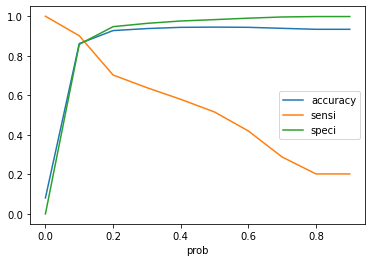

In [370]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Observation: From the above plot we get that the most optimal cutoff for accuracy, sensitivity and specificty is around 0.1**

In [372]:
metrics_on_different_thresholds(y_train, thresholds, threshold_df)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  \
0.0         1.00         0.00      0.08       0.08    1.00  1.00  0.00   
0.1         0.90         0.86      0.86       0.36    0.90  0.90  0.10   
0.2         0.70         0.95      0.93       0.54    0.70  0.70  0.30   
0.3         0.64         0.96      0.94       0.61    0.64  0.64  0.36   
0.4         0.58         0.98      0.94       0.68    0.58  0.58  0.42   
0.5         0.52         0.98      0.95       0.73    0.52  0.52  0.48   
0.6         0.42         0.99      0.94       0.79    0.42  0.42  0.58   
0.7         0.29         1.00      0.94       0.87    0.29  0.29  0.71   
0.8         0.20         1.00      0.93       0.92    0.20  0.20  0.80   
0.9         0.20         1.00      0.93       0.92    0.20  0.20  0.80   

     F1_score  
0.0      0.15  
0.1      0.51  
0.2      0.61  
0.3      0.62  
0.4      0.63  
0.5      0.60  
0.6      0.55  
0.7      0.43  
0.8      0.33  
0.9      0.33

In [373]:
classification_metrics(y_train, threshold_df[0.1], 'DT_train')

sensitivity  specificity  accuracy  precision  recall  TPR  FNR  F1_score
0          0.9         0.86      0.86       0.36     0.9  0.9  0.1      0.51

In [374]:
threshold_df_test = generate_prob_threshold_df(y_test, dt.predict_proba(X_test), thresholds)
classification_metrics(y_test, threshold_df_test[0.1], 'DT_test')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.83         0.85      0.85       0.33    0.83  0.83  0.17      0.47

In [375]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df

sensitivity  specificity  \
logistic_with_pca_train                             0.81         0.85   
logistic_with_pca_test                              0.81         0.84   
logistic_pca_smote_train                            0.89         0.77   
logistic_with_pca_smote_test                        0.91         0.76   
logistic_outlier_pca_smote_train                    0.93         0.69   
logistic_outlier_pca_smote_test                     0.93         0.69   
logistic_outlier_stratified_pca_smote_train         0.93         0.71   
logistic_outlier_stratified_pca_smote_test          0.89         0.70   
DT_train                                            0.90         0.86   
DT_test                                             0.83         0.85   

                                             accuracy  precision  recall  \
logistic_with_pca_train                          0.85       0.32    0.81   
logistic_with_pca_test                           0.84       0.33    0.81   
logistic_pca_smote_train                         0.83       0.79    0.89   
logistic_with_pca_smote_test                     0.78       0.24    0.91   
logistic_outlier_pca_smote_train                 0.81       0.75    0.93   
logistic_outlier_pca_smote_test                  0.70       0.19    0.93   
logistic_outlier_stratified_pca_smote_train      0.82       0.76    0.93   
logistic_outlier_stratified_pca_smote_test       0.72       0.21    0.89   
DT_train                                         0.86       0.36    0.90   
DT_test                                          0.85       0.33    0.83   

                                              TPR   FNR  F1_score  
logistic_with_pca_train                      0.81  0.19      0.46  
logistic_with_pca_test                       0.81  0.19      0.47  
logistic_pca_smote_train                     0.89  0.11      0.84  
logistic_with_pca_smote_test                 0.91  0.09      0.38  
logistic_outlier_pca_smote_train             0.93  0.07      0.83  
logistic_outlier_pca_smote_test              0.93  0.07      0.32  
logistic_outlier_stratified_pca_smote_train  0.93  0.07      0.84  
logistic_outlier_stratified_pca_smote_test   0.89  0.11      0.34  
DT_train                                     0.90  0.10      0.51  
DT_test                                      0.83  0.17      0.47

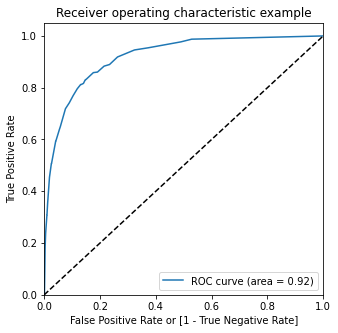

In [377]:
draw_roc(y_test, dt.predict_proba(X_test)[:, 1])

### From the Decision Tree algorithm, we get an accuracy of ~85% and also recall of ~83%.

---

### Model: Random Forest

In [393]:
rf = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=500, oob_score=True)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=500, oob_score=True,
                       random_state=42)

In [394]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [395]:
classification_metrics(y_train, y_train_pred)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.45         0.99      0.94       0.77    0.45  0.45  0.55      0.57

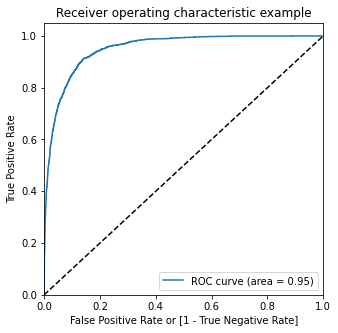

In [396]:
draw_roc(y_train, rf.predict_proba(X_train)[:, 1])

In [397]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train, rf.predict_proba(X_train), thresholds)

In [398]:
threshold_df.head()

Actual Churn  Probability  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0             0     0.004069    1    0    0    0    0    0    0    0    0    0
1             0     0.015139    1    0    0    0    0    0    0    0    0    0
2             0     0.131416    1    1    0    0    0    0    0    0    0    0
3             0     0.640669    1    1    1    1    1    1    1    0    0    0
4             0     0.021294    1    0    0    0    0    0    0    0    0    0

In [399]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df.head()

prob  accuracy     sensi     speci
0.0   0.0  0.081051  1.000000  0.000000
0.1   0.1  0.883114  0.876434  0.883703
0.2   0.2  0.937965  0.680918  0.960636
0.3   0.3  0.944473  0.531804  0.980870
0.4   0.4  0.945064  0.507821  0.983629

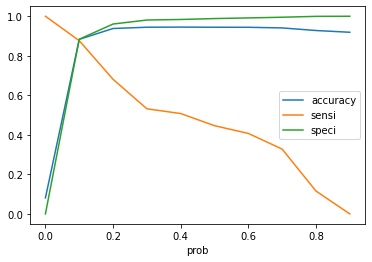

In [400]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Observation: From the above plot we get that the most optimal cutoff for accuracy, sensitivity and specificty is around 0.1**

In [401]:
metrics_on_different_thresholds(y_train, thresholds, threshold_df)

C:\Users\ayush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


sensitivity  specificity  accuracy  precision  recall   TPR   FNR  \
0.0         1.00         0.00      0.08       0.08    1.00  1.00  0.00   
0.1         0.88         0.88      0.88       0.40    0.88  0.88  0.12   
0.2         0.68         0.96      0.94       0.60    0.68  0.68  0.32   
0.3         0.53         0.98      0.94       0.71    0.53  0.53  0.47   
0.4         0.51         0.98      0.95       0.73    0.51  0.51  0.49   
0.5         0.45         0.99      0.94       0.77    0.45  0.45  0.55   
0.6         0.41         0.99      0.94       0.81    0.41  0.41  0.59   
0.7         0.33         0.99      0.94       0.85    0.33  0.33  0.67   
0.8         0.12         1.00      0.93       0.95    0.12  0.12  0.88   
0.9         0.00         1.00      0.92       0.00    0.00  0.00  1.00   

     F1_score  
0.0      0.15  
0.1      0.55  
0.2      0.64  
0.3      0.61  
0.4      0.60  
0.5      0.57  
0.6      0.54  
0.7      0.47  
0.8      0.21  
0.9      0.00

In [402]:
classification_metrics(y_train, threshold_df[0.1], 'RF_Train')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.88         0.88      0.88        0.4    0.88  0.88  0.12      0.55

In [403]:
threshold_df_test = generate_prob_threshold_df(y_test, rf.predict_proba(X_test), thresholds)
classification_metrics(y_test, threshold_df_test[0.1], 'RF_test')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.81         0.88      0.88       0.38    0.81  0.81  0.19      0.52

In [405]:
rf.oob_score_

0.9438810006761326

In [406]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df

sensitivity  specificity  \
logistic_with_pca_train                             0.81         0.85   
logistic_with_pca_test                              0.81         0.84   
logistic_pca_smote_train                            0.89         0.77   
logistic_with_pca_smote_test                        0.91         0.76   
logistic_outlier_pca_smote_train                    0.93         0.69   
logistic_outlier_pca_smote_test                     0.93         0.69   
logistic_outlier_stratified_pca_smote_train         0.93         0.71   
logistic_outlier_stratified_pca_smote_test          0.89         0.70   
DT_train                                            0.90         0.86   
DT_test                                             0.83         0.85   
RF_Train                                            0.88         0.88   
RF_test                                             0.81         0.88   

                                             accuracy  precision  recall  \
logistic_with_pca_train                          0.85       0.32    0.81   
logistic_with_pca_test                           0.84       0.33    0.81   
logistic_pca_smote_train                         0.83       0.79    0.89   
logistic_with_pca_smote_test                     0.78       0.24    0.91   
logistic_outlier_pca_smote_train                 0.81       0.75    0.93   
logistic_outlier_pca_smote_test                  0.70       0.19    0.93   
logistic_outlier_stratified_pca_smote_train      0.82       0.76    0.93   
logistic_outlier_stratified_pca_smote_test       0.72       0.21    0.89   
DT_train                                         0.86       0.36    0.90   
DT_test                                          0.85       0.33    0.83   
RF_Train                                         0.88       0.40    0.88   
RF_test                                          0.88       0.38    0.81   

                                              TPR   FNR  F1_score  
logistic_with_pca_train                      0.81  0.19      0.46  
logistic_with_pca_test                       0.81  0.19      0.47  
logistic_pca_smote_train                     0.89  0.11      0.84  
logistic_with_pca_smote_test                 0.91  0.09      0.38  
logistic_outlier_pca_smote_train             0.93  0.07      0.83  
logistic_outlier_pca_smote_test              0.93  0.07      0.32  
logistic_outlier_stratified_pca_smote_train  0.93  0.07      0.84  
logistic_outlier_stratified_pca_smote_test   0.89  0.11      0.34  
DT_train                                     0.90  0.10      0.51  
DT_test                                      0.83  0.17      0.47  
RF_Train                                     0.88  0.12      0.55  
RF_test                                      0.81  0.19      0.52

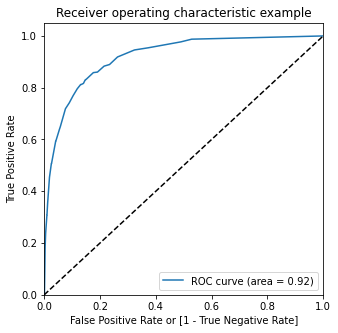

In [407]:
draw_roc(y_test, dt.predict_proba(X_test)[:, 1])

### From the Random Forest algorithm, we get an accuracy of ~88% and also recall of ~81%.

---

### Decision tree with hyperparameter tuning

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [408]:
dt = DecisionTreeClassifier(random_state=42)

params = {
    'criterion': ['gini'],
    'max_depth': [5, 8],
    'min_samples_split': [500, 1000],
    'max_features': [20, 50, 100]
}

grid_search = GridSearchCV(estimator=dt,
            param_grid=params,
            n_jobs=-1,
            scoring='recall',
            cv=5,
            return_train_score=True,
            verbose=True)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [5, 8],
                         'max_features': [20, 50, 100],
                         'min_samples_split': [500, 1000]},
             return_train_score=True, scoring='recall', verbose=True)

In [409]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features=100, min_samples_split=1000,
                       random_state=42)

In [410]:
cv_results = pd.DataFrame(grid_search.cv_results_)

In [411]:
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.192642      0.007043         0.011976        0.001707   
1       0.196074      0.007839         0.014792        0.006216   
2       0.414646      0.057062         0.010577        0.001415   
3       0.385116      0.034673         0.012059        0.001238   
4       0.724127      0.079461         0.010840        0.000931   

  param_criterion param_max_depth param_max_features param_min_samples_split  \
0            gini               5                 20                     500   
1            gini               5                 20                    1000   
2            gini               5                 50                     500   
3            gini               5                 50                    1000   
4            gini               5                100                     500   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.438642   
1  {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.454308   
2  {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.506527   
3  {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.506527   
4  {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.550914   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.377604           0.406250           0.395833           0.389034   
1           0.401042           0.419271           0.432292           0.399478   
2           0.463542           0.494792           0.489583           0.498695   
3           0.463542           0.476562           0.515625           0.496084   
4           0.458333           0.473958           0.507812           0.498695   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.401473        0.020788               12            0.393485   
1         0.421278        0.020499                9            0.414332   
2         0.490628        0.014628                8            0.455375   
3         0.491668        0.019149                7            0.456026   
4         0.497943        0.031774                4            0.497068   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.411995            0.426336            0.383312   
1            0.427640            0.421773            0.418514   
2            0.513038            0.514993            0.487614   
3            0.513690            0.488266            0.513038   
4            0.504563            0.483703            0.509126   

   split4_train_score  mean_train_score  std_train_score  
0            0.417590          0.406544         0.015835  
1            0.428013          0.422054         0.005272  
2            0.522476          0.498699         0.024643  
3            0.517915          0.497787         0.023346  
4            0.515961          0.502084         0.011057

In [412]:
grid_search.best_score_

0.5067966710182767

In [413]:
dt_best = grid_search.best_estimator_

In [414]:
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

In [415]:
classification_metrics(y_train, y_train_pred)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.51         0.98      0.94       0.72    0.51  0.51  0.49       0.6

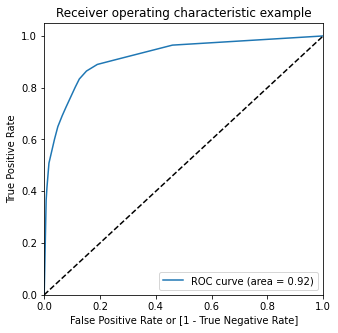

In [416]:
draw_roc(y_train, dt_best.predict_proba(X_train)[:, 1])

In [417]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train, dt_best.predict_proba(X_train), thresholds)

In [418]:
threshold_df.head()

Actual Churn  Probability  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0             0     0.005754    1    0    0    0    0    0    0    0    0    0
1             0     0.005754    1    0    0    0    0    0    0    0    0    0
2             0     0.005754    1    0    0    0    0    0    0    0    0    0
3             0     0.601307    1    1    1    1    1    1    1    0    0    0
4             0     0.005754    1    0    0    0    0    0    0    0    0    0

In [419]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df.head()

prob  accuracy     sensi     speci
0.0   0.0  0.081051  1.000000  0.000000
0.1   0.1  0.870859  0.833681  0.874138
0.2   0.2  0.926682  0.649635  0.951117
0.3   0.3  0.944515  0.508863  0.982939
0.4   0.4  0.944515  0.508863  0.982939

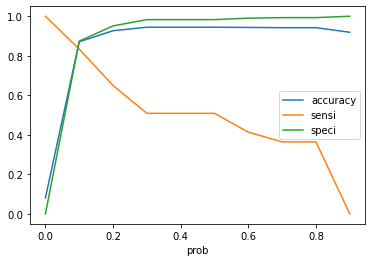

In [420]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Observation: From the above plot we get that the most optimal cutoff for accuracy, sensitivity and specificty is around 0.1**

In [421]:
metrics_on_different_thresholds(y_train, thresholds, threshold_df)

C:\Users\ayush\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


sensitivity  specificity  accuracy  precision  recall   TPR   FNR  \
0.0         1.00         0.00      0.08       0.08    1.00  1.00  0.00   
0.1         0.83         0.87      0.87       0.37    0.83  0.83  0.17   
0.2         0.65         0.95      0.93       0.54    0.65  0.65  0.35   
0.3         0.51         0.98      0.94       0.72    0.51  0.51  0.49   
0.4         0.51         0.98      0.94       0.72    0.51  0.51  0.49   
0.5         0.51         0.98      0.94       0.72    0.51  0.51  0.49   
0.6         0.41         0.99      0.94       0.79    0.41  0.41  0.59   
0.7         0.36         0.99      0.94       0.82    0.36  0.36  0.64   
0.8         0.36         0.99      0.94       0.82    0.36  0.36  0.64   
0.9         0.00         1.00      0.92       0.00    0.00  0.00  1.00   

     F1_score  
0.0      0.15  
0.1      0.51  
0.2      0.59  
0.3      0.60  
0.4      0.60  
0.5      0.60  
0.6      0.54  
0.7      0.51  
0.8      0.51  
0.9      0.00

In [422]:
classification_metrics(y_train, threshold_df[0.1], 'DT_hyper_tuning_Train')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.83         0.87      0.87       0.37    0.83  0.83  0.17      0.51

In [423]:
threshold_df_test = generate_prob_threshold_df(y_test, dt_best.predict_proba(X_test), thresholds)
classification_metrics(y_test, threshold_df_test[0.1], 'DT_hyper_tuning_Test')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.79         0.87      0.86       0.34    0.79  0.79  0.21      0.48

In [424]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df

sensitivity  specificity  \
logistic_with_pca_train                             0.81         0.85   
logistic_with_pca_test                              0.81         0.84   
logistic_pca_smote_train                            0.89         0.77   
logistic_with_pca_smote_test                        0.91         0.76   
logistic_outlier_pca_smote_train                    0.93         0.69   
logistic_outlier_pca_smote_test                     0.93         0.69   
logistic_outlier_stratified_pca_smote_train         0.93         0.71   
logistic_outlier_stratified_pca_smote_test          0.89         0.70   
DT_train                                            0.90         0.86   
DT_test                                             0.83         0.85   
RF_Train                                            0.88         0.88   
RF_test                                             0.81         0.88   
DT_hyper_tuning_Train                               0.83         0.87   
DT_hyper_tuning_Test                                0.79         0.87   

                                             accuracy  precision  recall  \
logistic_with_pca_train                          0.85       0.32    0.81   
logistic_with_pca_test                           0.84       0.33    0.81   
logistic_pca_smote_train                         0.83       0.79    0.89   
logistic_with_pca_smote_test                     0.78       0.24    0.91   
logistic_outlier_pca_smote_train                 0.81       0.75    0.93   
logistic_outlier_pca_smote_test                  0.70       0.19    0.93   
logistic_outlier_stratified_pca_smote_train      0.82       0.76    0.93   
logistic_outlier_stratified_pca_smote_test       0.72       0.21    0.89   
DT_train                                         0.86       0.36    0.90   
DT_test                                          0.85       0.33    0.83   
RF_Train                                         0.88       0.40    0.88   
RF_test                                          0.88       0.38    0.81   
DT_hyper_tuning_Train                            0.87       0.37    0.83   
DT_hyper_tuning_Test                             0.86       0.34    0.79   

                                              TPR   FNR  F1_score  
logistic_with_pca_train                      0.81  0.19      0.46  
logistic_with_pca_test                       0.81  0.19      0.47  
logistic_pca_smote_train                     0.89  0.11      0.84  
logistic_with_pca_smote_test                 0.91  0.09      0.38  
logistic_outlier_pca_smote_train             0.93  0.07      0.83  
logistic_outlier_pca_smote_test              0.93  0.07      0.32  
logistic_outlier_stratified_pca_smote_train  0.93  0.07      0.84  
logistic_outlier_stratified_pca_smote_test   0.89  0.11      0.34  
DT_train                                     0.90  0.10      0.51  
DT_test                                      0.83  0.17      0.47  
RF_Train                                     0.88  0.12      0.55  
RF_test                                      0.81  0.19      0.52  
DT_hyper_tuning_Train                        0.83  0.17      0.51  
DT_hyper_tuning_Test                         0.79  0.21      0.48

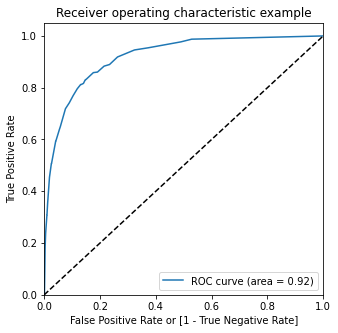

In [407]:
draw_roc(y_test, dt_best.predict_proba(X_test)[:, 1])

### From the Decision Tree with Hyper Parameter Tuning, we get an accuracy of ~87% and also recall of ~79%.

---

#### Decision Tree with PCA, SMOTE and hyperparamter tuning

In [432]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.shape, X_test.shape

((23664, 107), (5917, 107))

In [433]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [434]:
pca = PCA(0.95, random_state=42)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

X_train_scaled_pca.shape, X_test_scaled_pca.shape

((23664, 54), (5917, 54))

<BarContainer object of 54 artists>

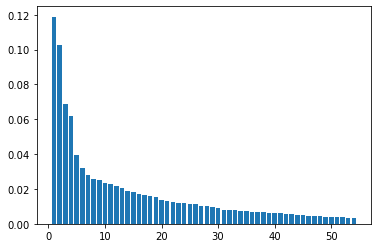

In [435]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

In [436]:
smote = SMOTE(random_state=42)
X_train_scaled_pca_smote, y_train_smote = smote.fit_resample(X_train_scaled_pca, y_train)

In [437]:
X_train_scaled_pca_smote.shape

(43418, 54)

In [438]:
dt = DecisionTreeClassifier(random_state=42)

params = {
    'criterion': ['gini'],
    'max_depth': [5, 8, 10],
    'min_samples_split': [500, 1000],
    'max_features': [30, 40, 50]
}

grid_search = GridSearchCV(estimator=dt,
            param_grid=params,
            n_jobs=-1,
            scoring='recall',
            cv=5,
            return_train_score=True,
            verbose=1)

grid_search.fit(X_train_scaled_pca_smote, y_train_smote)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [5, 8, 10],
                         'max_features': [30, 40, 50],
                         'min_samples_split': [500, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [439]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, max_features=50, min_samples_split=500,
                       random_state=42)

In [440]:
cv_results = pd.DataFrame(grid_search.cv_results_)

In [441]:
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.867969      0.016830         0.007430        0.001180   
1       1.120896      0.199990         0.009343        0.003921   
2       1.296898      0.189737         0.006921        0.000918   
3       1.278437      0.193905         0.006906        0.000466   
4       1.546299      0.130245         0.008809        0.003860   

  param_criterion param_max_depth param_max_features param_min_samples_split  \
0            gini               5                 30                     500   
1            gini               5                 30                    1000   
2            gini               5                 40                     500   
3            gini               5                 40                    1000   
4            gini               5                 50                     500   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.793413   
1  {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.750345   
2  {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.781437   
3  {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.771304   
4  {'criterion': 'gini', 'max_depth': 5, 'max_fea...           0.784892   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.777522           0.795486           0.774528           0.805114   
1           0.848918           0.829802           0.774528           0.763419   
2           0.767388           0.774067           0.769231           0.795900   
3           0.761631           0.776370           0.767849           0.748675   
4           0.788577           0.808153           0.780286           0.788989   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.789213        0.011508               14            0.822595   
1         0.793402        0.038771               10            0.769851   
2         0.777605        0.010358               17            0.814130   
3         0.765166        0.009538               18            0.795820   
4         0.790179        0.009517               12            0.816088   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.776415            0.786837            0.769045   
1            0.844993            0.833189            0.767836   
2            0.773421            0.757874            0.761387   
3            0.760177            0.764093            0.764553   
4            0.792998            0.794265            0.771406   

   split4_train_score  mean_train_score  std_train_score  
0            0.812932          0.793565         0.020777  
1            0.770325          0.797239         0.034386  
2            0.798825          0.781127         0.021873  
3            0.759615          0.768852         0.013630  
4            0.800150          0.794981         0.014370

In [442]:
grid_search.best_score_

0.8343999365046422

In [443]:
dt_best = grid_search.best_estimator_

In [445]:
y_train_pred = dt_best.predict(X_train_scaled_pca_smote)
y_test_pred = dt_best.predict(X_test_scaled_pca)

In [447]:
classification_metrics(y_train_smote, y_train_pred)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.85         0.84      0.85       0.85    0.85  0.85  0.15      0.85

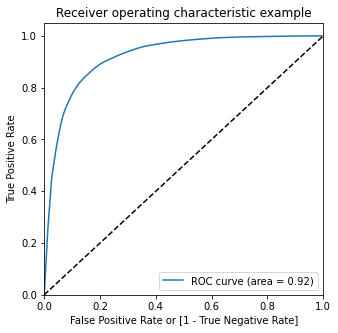

In [449]:
draw_roc(y_train_smote, dt_best.predict_proba(X_train_scaled_pca_smote)[:, 1])

In [451]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train_smote, dt_best.predict_proba(X_train_scaled_pca_smote), thresholds)

In [452]:
threshold_df.head()

Actual Churn  Probability  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0             1     0.901709    1    1    1    1    1    1    1    1    1    1
1             0     0.107955    1    1    0    0    0    0    0    0    0    0
2             0     0.152778    1    1    0    0    0    0    0    0    0    0
3             0     0.085847    1    0    0    0    0    0    0    0    0    0
4             0     0.506608    1    1    1    1    1    1    0    0    0    0

In [453]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df.head()

prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.739463  0.982542  0.496384
0.2   0.2  0.799945  0.959648  0.640241
0.3   0.3  0.828758  0.926666  0.730849
0.4   0.4  0.844811  0.892855  0.796766

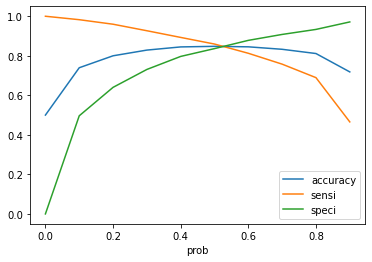

In [454]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Observation: From the above plot we get that the most optimal cutoff for accuracy, sensitivity and specificty is around `0.3`**

In [456]:
metrics_on_different_thresholds(y_train_smote, thresholds, threshold_df)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  \
0.0         1.00         0.00      0.50       0.50    1.00  1.00  0.00   
0.1         0.98         0.50      0.74       0.66    0.98  0.98  0.02   
0.2         0.96         0.64      0.80       0.73    0.96  0.96  0.04   
0.3         0.93         0.73      0.83       0.77    0.93  0.93  0.07   
0.4         0.89         0.80      0.84       0.81    0.89  0.89  0.11   
0.5         0.86         0.84      0.85       0.84    0.86  0.86  0.14   
0.6         0.81         0.88      0.85       0.87    0.81  0.81  0.19   
0.7         0.76         0.91      0.83       0.89    0.76  0.76  0.24   
0.8         0.69         0.93      0.81       0.91    0.69  0.69  0.31   
0.9         0.47         0.97      0.72       0.94    0.47  0.47  0.53   

     F1_score  
0.0      0.67  
0.1      0.79  
0.2      0.83  
0.3      0.84  
0.4      0.85  
0.5      0.85  
0.6      0.84  
0.7      0.82  
0.8      0.79  
0.9      0.62

In [458]:
classification_metrics(y_train_smote, threshold_df[0.3], 'DT_PCA_SMOTE_hyper_tuning_train')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.93         0.73      0.83       0.77    0.93  0.93  0.07      0.84

In [459]:
threshold_df_test = generate_prob_threshold_df(y_test, dt_best.predict_proba(X_test_scaled_pca), thresholds)
classification_metrics(y_test, threshold_df_test[0.1], 'DT_PCA_SMOTE_hyper_tuning_test')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.93         0.48      0.52       0.13    0.93  0.93  0.07      0.22

In [460]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df

sensitivity  specificity  \
logistic_with_pca_train                             0.81         0.85   
logistic_with_pca_test                              0.81         0.84   
logistic_pca_smote_train                            0.89         0.77   
logistic_with_pca_smote_test                        0.91         0.76   
logistic_outlier_pca_smote_train                    0.93         0.69   
logistic_outlier_pca_smote_test                     0.93         0.69   
logistic_outlier_stratified_pca_smote_train         0.93         0.71   
logistic_outlier_stratified_pca_smote_test          0.89         0.70   
DT_train                                            0.90         0.86   
DT_test                                             0.83         0.85   
RF_Train                                            0.88         0.88   
RF_test                                             0.81         0.88   
DT_hyper_tuning_Train                               0.83         0.87   
DT_hyper_tuning_Test                                0.79         0.87   
DT_PCA_SMOTE_hyper_tuning_train                     0.93         0.73   
DT_PCA_SMOTE_hyper_tuning_test                      0.93         0.48   

                                             accuracy  precision  recall  \
logistic_with_pca_train                          0.85       0.32    0.81   
logistic_with_pca_test                           0.84       0.33    0.81   
logistic_pca_smote_train                         0.83       0.79    0.89   
logistic_with_pca_smote_test                     0.78       0.24    0.91   
logistic_outlier_pca_smote_train                 0.81       0.75    0.93   
logistic_outlier_pca_smote_test                  0.70       0.19    0.93   
logistic_outlier_stratified_pca_smote_train      0.82       0.76    0.93   
logistic_outlier_stratified_pca_smote_test       0.72       0.21    0.89   
DT_train                                         0.86       0.36    0.90   
DT_test                                          0.85       0.33    0.83   
RF_Train                                         0.88       0.40    0.88   
RF_test                                          0.88       0.38    0.81   
DT_hyper_tuning_Train                            0.87       0.37    0.83   
DT_hyper_tuning_Test                             0.86       0.34    0.79   
DT_PCA_SMOTE_hyper_tuning_train                  0.83       0.77    0.93   
DT_PCA_SMOTE_hyper_tuning_test                   0.52       0.13    0.93   

                                              TPR   FNR  F1_score  
logistic_with_pca_train                      0.81  0.19      0.46  
logistic_with_pca_test                       0.81  0.19      0.47  
logistic_pca_smote_train                     0.89  0.11      0.84  
logistic_with_pca_smote_test                 0.91  0.09      0.38  
logistic_outlier_pca_smote_train             0.93  0.07      0.83  
logistic_outlier_pca_smote_test              0.93  0.07      0.32  
logistic_outlier_stratified_pca_smote_train  0.93  0.07      0.84  
logistic_outlier_stratified_pca_smote_test   0.89  0.11      0.34  
DT_train                                     0.90  0.10      0.51  
DT_test                                      0.83  0.17      0.47  
RF_Train                                     0.88  0.12      0.55  
RF_test                                      0.81  0.19      0.52  
DT_hyper_tuning_Train                        0.83  0.17      0.51  
DT_hyper_tuning_Test                         0.79  0.21      0.48  
DT_PCA_SMOTE_hyper_tuning_train              0.93  0.07      0.84  
DT_PCA_SMOTE_hyper_tuning_test               0.93  0.07      0.22

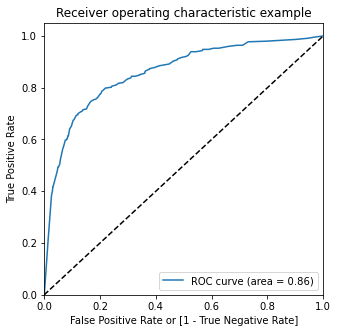

In [462]:
draw_roc(y_test, dt_best.predict_proba(X_test_scaled_pca)[:, 1])

### From the Decision Tree with Hyper Parameter Tuning, Scaling, PCA, and SMOTE, we get an accuracy of ~52% and also recall of ~93%.

---

#### XGBoost with PCA, SMOTE

In [463]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.shape, X_test.shape

((23664, 107), (5917, 107))

In [464]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [465]:
pca = PCA(0.95, random_state=42)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

X_train_scaled_pca.shape, X_test_scaled_pca.shape

((23664, 54), (5917, 54))

<BarContainer object of 54 artists>

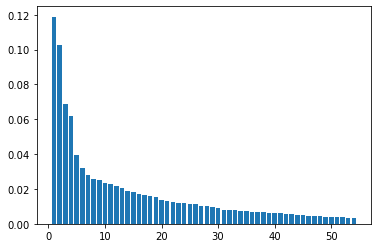

In [466]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

In [467]:
smote = SMOTE(random_state=42)
X_train_scaled_pca_smote, y_train_smote = smote.fit_resample(X_train_scaled_pca, y_train)

In [468]:
X_train_scaled_pca_smote.shape

(43418, 54)

In [469]:
xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1)
xgb.fit(X_train_scaled_pca_smote, y_train_smote)

C:\Users\ayush\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [471]:
y_train_pred = xgb.predict(X_train_scaled_pca_smote)
y_test_pred = xgb.predict(X_test_scaled_pca)

In [472]:
classification_metrics(y_train_smote, y_train_pred)

sensitivity  specificity  accuracy  precision  recall  TPR  FNR  F1_score
0          1.0         0.98      0.99       0.98     1.0  1.0  0.0      0.99

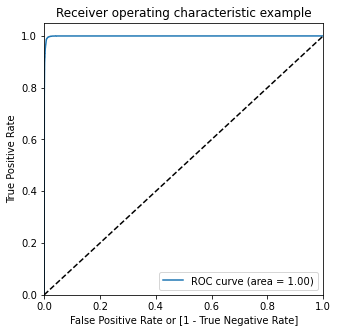

In [473]:
draw_roc(y_train_smote, xgb.predict_proba(X_train_scaled_pca_smote)[:, 1])

In [474]:
thresholds = np.round(np.arange(0, 1, 0.1), 2)
threshold_df = generate_prob_threshold_df(y_train_smote, xgb.predict_proba(X_train_scaled_pca_smote), thresholds)

In [475]:
threshold_df.head()

Actual Churn  Probability  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0             1     0.966848    1    1    1    1    1    1    1    1    1    1
1             0     0.001562    1    0    0    0    0    0    0    0    0    0
2             0     0.034503    1    0    0    0    0    0    0    0    0    0
3             0     0.007174    1    0    0    0    0    0    0    0    0    0
4             0     0.017160    1    0    0    0    0    0    0    0    0    0

In [476]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df.head()

prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.930374  1.000000  0.860749
0.2   0.2  0.962182  0.999954  0.924409
0.3   0.3  0.976070  0.999862  0.952278
0.4   0.4  0.984430  0.999585  0.969275

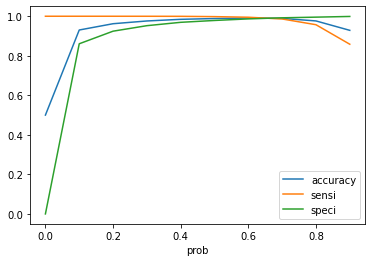

In [477]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

**Observation: From the above plot we get that the most optimal cutoff for accuracy, sensitivity and specificty is around 0.1**

In [479]:
metrics_on_different_thresholds(y_train_smote, thresholds, threshold_df)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  \
0.0         1.00         0.00      0.50       0.50    1.00  1.00  0.00   
0.1         1.00         0.86      0.93       0.88    1.00  1.00  0.00   
0.2         1.00         0.92      0.96       0.93    1.00  1.00  0.00   
0.3         1.00         0.95      0.98       0.95    1.00  1.00  0.00   
0.4         1.00         0.97      0.98       0.97    1.00  1.00  0.00   
0.5         1.00         0.98      0.99       0.98    1.00  1.00  0.00   
0.6         0.99         0.99      0.99       0.99    0.99  0.99  0.01   
0.7         0.99         0.99      0.99       0.99    0.99  0.99  0.01   
0.8         0.96         1.00      0.98       1.00    0.96  0.96  0.04   
0.9         0.86         1.00      0.93       1.00    0.86  0.86  0.14   

     F1_score  
0.0      0.67  
0.1      0.93  
0.2      0.96  
0.3      0.98  
0.4      0.98  
0.5      0.99  
0.6      0.99  
0.7      0.99  
0.8      0.98  
0.9      0.92

In [481]:
classification_metrics(y_train_smote, threshold_df[0.5], 'XGB_PCA_SMOTE_Train')

sensitivity  specificity  accuracy  precision  recall  TPR  FNR  F1_score
0          1.0         0.98      0.99       0.98     1.0  1.0  0.0      0.99

In [484]:
threshold_df_test = generate_prob_threshold_df(y_test, xgb.predict_proba(X_test_scaled_pca), thresholds)
classification_metrics(y_test, threshold_df_test[0.5], 'XGB_PCA_SMOTE_Test')

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.67         0.93      0.91       0.43    0.67  0.67  0.33      0.53

In [485]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df

sensitivity  specificity  \
logistic_with_pca_train                             0.81         0.85   
logistic_with_pca_test                              0.81         0.84   
logistic_pca_smote_train                            0.89         0.77   
logistic_with_pca_smote_test                        0.91         0.76   
logistic_outlier_pca_smote_train                    0.93         0.69   
logistic_outlier_pca_smote_test                     0.93         0.69   
logistic_outlier_stratified_pca_smote_train         0.93         0.71   
logistic_outlier_stratified_pca_smote_test          0.89         0.70   
DT_train                                            0.90         0.86   
DT_test                                             0.83         0.85   
RF_Train                                            0.88         0.88   
RF_test                                             0.81         0.88   
DT_hyper_tuning_Train                               0.83         0.87   
DT_hyper_tuning_Test                                0.79         0.87   
DT_PCA_SMOTE_hyper_tuning_train                     0.93         0.73   
DT_PCA_SMOTE_hyper_tuning_test                      0.93         0.48   
XGB_PCA_SMOTE_Train                                 1.00         0.98   
XGB_PCA_SMOTE_Test                                  0.67         0.93   

                                             accuracy  precision  recall  \
logistic_with_pca_train                          0.85       0.32    0.81   
logistic_with_pca_test                           0.84       0.33    0.81   
logistic_pca_smote_train                         0.83       0.79    0.89   
logistic_with_pca_smote_test                     0.78       0.24    0.91   
logistic_outlier_pca_smote_train                 0.81       0.75    0.93   
logistic_outlier_pca_smote_test                  0.70       0.19    0.93   
logistic_outlier_stratified_pca_smote_train      0.82       0.76    0.93   
logistic_outlier_stratified_pca_smote_test       0.72       0.21    0.89   
DT_train                                         0.86       0.36    0.90   
DT_test                                          0.85       0.33    0.83   
RF_Train                                         0.88       0.40    0.88   
RF_test                                          0.88       0.38    0.81   
DT_hyper_tuning_Train                            0.87       0.37    0.83   
DT_hyper_tuning_Test                             0.86       0.34    0.79   
DT_PCA_SMOTE_hyper_tuning_train                  0.83       0.77    0.93   
DT_PCA_SMOTE_hyper_tuning_test                   0.52       0.13    0.93   
XGB_PCA_SMOTE_Train                              0.99       0.98    1.00   
XGB_PCA_SMOTE_Test                               0.91       0.43    0.67   

                                              TPR   FNR  F1_score  
logistic_with_pca_train                      0.81  0.19      0.46  
logistic_with_pca_test                       0.81  0.19      0.47  
logistic_pca_smote_train                     0.89  0.11      0.84  
logistic_with_pca_smote_test                 0.91  0.09      0.38  
logistic_outlier_pca_smote_train             0.93  0.07      0.83  
logistic_outlier_pca_smote_test              0.93  0.07      0.32  
logistic_outlier_stratified_pca_smote_train  0.93  0.07      0.84  
logistic_outlier_stratified_pca_smote_test   0.89  0.11      0.34  
DT_train                                     0.90  0.10      0.51  
DT_test                                      0.83  0.17      0.47  
RF_Train                                     0.88  0.12      0.55  
RF_test                                      0.81  0.19      0.52  
DT_hyper_tuning_Train                        0.83  0.17      0.51  
DT_hyper_tuning_Test                         0.79  0.21      0.48  
DT_PCA_SMOTE_hyper_tuning_train              0.93  0.07      0.84  
DT_PCA_SMOTE_hyper_tuning_test               0.93  0.07      0.22  
XGB_PCA_SMOTE_Train                          1.00  0.00 

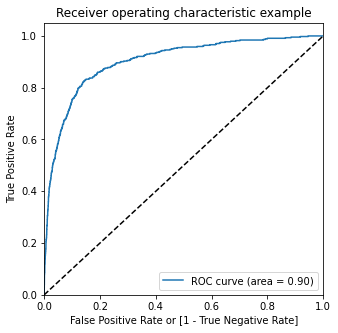

In [487]:
draw_roc(y_test, xgb.predict_proba(X_test_scaled_pca)[:, 1])

## Best Model

In [489]:
model_scores_df = pd.DataFrame(model_scores_dict.values(), index=model_scores_dict.keys(), columns=clf_df.columns)
model_scores_df

sensitivity  specificity  \
logistic_with_pca_train                             0.81         0.85   
logistic_with_pca_test                              0.81         0.84   
logistic_pca_smote_train                            0.89         0.77   
logistic_with_pca_smote_test                        0.91         0.76   
logistic_outlier_pca_smote_train                    0.93         0.69   
logistic_outlier_pca_smote_test                     0.93         0.69   
logistic_outlier_stratified_pca_smote_train         0.93         0.71   
logistic_outlier_stratified_pca_smote_test          0.89         0.70   
DT_train                                            0.90         0.86   
DT_test                                             0.83         0.85   
RF_Train                                            0.88         0.88   
RF_test                                             0.81         0.88   
DT_hyper_tuning_Train                               0.83         0.87   
DT_hyper_tuning_Test                                0.79         0.87   
DT_PCA_SMOTE_hyper_tuning_train                     0.93         0.73   
DT_PCA_SMOTE_hyper_tuning_test                      0.93         0.48   
XGB_PCA_SMOTE_Train                                 1.00         0.98   
XGB_PCA_SMOTE_Test                                  0.67         0.93   

                                             accuracy  precision  recall  \
logistic_with_pca_train                          0.85       0.32    0.81   
logistic_with_pca_test                           0.84       0.33    0.81   
logistic_pca_smote_train                         0.83       0.79    0.89   
logistic_with_pca_smote_test                     0.78       0.24    0.91   
logistic_outlier_pca_smote_train                 0.81       0.75    0.93   
logistic_outlier_pca_smote_test                  0.70       0.19    0.93   
logistic_outlier_stratified_pca_smote_train      0.82       0.76    0.93   
logistic_outlier_stratified_pca_smote_test       0.72       0.21    0.89   
DT_train                                         0.86       0.36    0.90   
DT_test                                          0.85       0.33    0.83   
RF_Train                                         0.88       0.40    0.88   
RF_test                                          0.88       0.38    0.81   
DT_hyper_tuning_Train                            0.87       0.37    0.83   
DT_hyper_tuning_Test                             0.86       0.34    0.79   
DT_PCA_SMOTE_hyper_tuning_train                  0.83       0.77    0.93   
DT_PCA_SMOTE_hyper_tuning_test                   0.52       0.13    0.93   
XGB_PCA_SMOTE_Train                              0.99       0.98    1.00   
XGB_PCA_SMOTE_Test                               0.91       0.43    0.67   

                                              TPR   FNR  F1_score  
logistic_with_pca_train                      0.81  0.19      0.46  
logistic_with_pca_test                       0.81  0.19      0.47  
logistic_pca_smote_train                     0.89  0.11      0.84  
logistic_with_pca_smote_test                 0.91  0.09      0.38  
logistic_outlier_pca_smote_train             0.93  0.07      0.83  
logistic_outlier_pca_smote_test              0.93  0.07      0.32  
logistic_outlier_stratified_pca_smote_train  0.93  0.07      0.84  
logistic_outlier_stratified_pca_smote_test   0.89  0.11      0.34  
DT_train                                     0.90  0.10      0.51  
DT_test                                      0.83  0.17      0.47  
RF_Train                                     0.88  0.12      0.55  
RF_test                                      0.81  0.19      0.52  
DT_hyper_tuning_Train                        0.83  0.17      0.51  
DT_hyper_tuning_Test                         0.79  0.21      0.48  
DT_PCA_SMOTE_hyper_tuning_train              0.93  0.07      0.84  
DT_PCA_SMOTE_hyper_tuning_test               0.93  0.07      0.22  
XGB_PCA_SMOTE_Train                          1.00  0.00 

In [492]:
model_scores_df[model_scores_df['sensitivity'] == 0.93]

sensitivity  specificity  \
logistic_outlier_pca_smote_train                    0.93         0.69   
logistic_outlier_pca_smote_test                     0.93         0.69   
logistic_outlier_stratified_pca_smote_train         0.93         0.71   
DT_PCA_SMOTE_hyper_tuning_train                     0.93         0.73   
DT_PCA_SMOTE_hyper_tuning_test                      0.93         0.48   

                                             accuracy  precision  recall  \
logistic_outlier_pca_smote_train                 0.81       0.75    0.93   
logistic_outlier_pca_smote_test                  0.70       0.19    0.93   
logistic_outlier_stratified_pca_smote_train      0.82       0.76    0.93   
DT_PCA_SMOTE_hyper_tuning_train                  0.83       0.77    0.93   
DT_PCA_SMOTE_hyper_tuning_test                   0.52       0.13    0.93   

                                              TPR   FNR  F1_score  
logistic_outlier_pca_smote_train             0.93  0.07      0.83  
logistic_outlier_pca_smote_test              0.93  0.07      0.32  
logistic_outlier_stratified_pca_smote_train  0.93  0.07      0.84  
DT_PCA_SMOTE_hyper_tuning_train              0.93  0.07      0.84  
DT_PCA_SMOTE_hyper_tuning_test               0.93  0.07      0.22

### As per the business, sensitivity is the most important evaluation metric to consider while selecting the model.
### We should also see if the accuracy and specificity is in an acceptable range.

## Accordingly, the best model is `logistic_outlier_pca_smote_test` i.e Logistic Regression with Outlier Treatment, Scaling, PCA and SMOTE.

---

### Modelling for Inference (Identifying major driving variables)

In [493]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.shape, X_test.shape

((23664, 107), (5917, 107))

In [494]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [495]:
X_train_smote.shape

(43418, 107)

In [496]:
dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=500)

dt.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=10, min_samples_split=500, random_state=42)

In [497]:
y_train_pred = dt.predict(X_train_smote)
y_test_pred = dt.predict(X_test)

In [498]:
classification_metrics(y_train_smote, y_train_pred)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.93         0.89      0.91       0.89    0.93  0.93  0.07      0.91

In [499]:
classification_metrics(y_test, y_test_pred)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  F1_score
0         0.81         0.88      0.88       0.36    0.81  0.81  0.19       0.5

In [500]:
y_test_pred_prob = dt.predict_proba(X_test)

In [501]:
y_test_pred_prob.shape

(5917, 2)

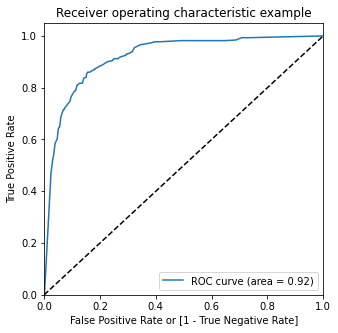

In [502]:
draw_roc(y_test, y_test_pred_prob[:,1])

In [503]:
thresholds = np.round(np.arange(0, 1, 0.05), 2)
threshold_df = generate_prob_threshold_df(y_train_smote, dt.predict_proba(X_train_smote), thresholds)

In [504]:
threshold_df.head()

Actual Churn  Probability  0.0  0.05  0.1  0.15  0.2  0.25  0.3  0.35  0.4  \
0             1     0.962602    1     1    1     1    1     1    1     1    1   
1             0     0.005814    1     0    0     0    0     0    0     0    0   
2             0     0.190476    1     1    1     1    0     0    0     0    0   
3             0     0.009756    1     0    0     0    0     0    0     0    0   
4             0     0.002215    1     0    0     0    0     0    0     0    0   

   0.45  0.5  0.55  0.6  0.65  0.7  0.75  0.8  0.85  0.9  0.95  
0     1    1     1    1     1    1     1    1     1    1     1  
1     0    0     0    0     0    0     0    0     0    0     0  
2     0    0     0    0     0    0     0    0     0    0     0  
3     0    0     0    0     0    0     0    0     0    0     0  
4     0    0     0    0     0    0     0    0     0    0     0

In [505]:
cutoff_df = generate_optimal_cutoff_df(threshold_df, thresholds)
cutoff_df.head()

prob  accuracy     sensi     speci
0.00  0.00  0.500000  1.000000  0.000000
0.05  0.05  0.828712  0.993459  0.663964
0.10  0.10  0.852204  0.989590  0.714819
0.15  0.15  0.862822  0.985766  0.739877
0.20  0.20  0.880050  0.977152  0.782947

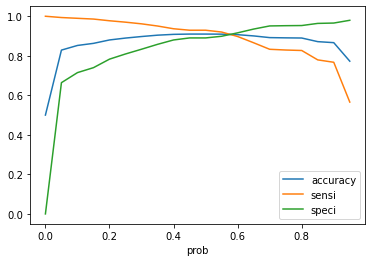

In [506]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [512]:
joined_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'accuracy', 'precision', 'recall', 'TPR', 'FNR', 'F1_score'])
for i in thresholds:
    joined_df = pd.concat([joined_df, classification_metrics(y_test, threshold_df[i])])
joined_df.set_index(thresholds)

sensitivity  specificity  accuracy  precision  recall   TPR   FNR  \
0.00         1.00         0.00      0.07       0.07    1.00  1.00  0.00   
0.05         0.97         0.65      0.68       0.18    0.97  0.97  0.03   
0.10         0.93         0.70      0.72       0.20    0.93  0.93  0.07   
0.15         0.92         0.73      0.74       0.21    0.92  0.92  0.08   
0.20         0.90         0.77      0.78       0.24    0.90  0.90  0.10   
0.25         0.88         0.80      0.80       0.26    0.88  0.88  0.12   
0.30         0.87         0.82      0.83       0.28    0.87  0.87  0.13   
0.35         0.85         0.85      0.85       0.31    0.85  0.85  0.15   
0.40         0.82         0.87      0.87       0.34    0.82  0.82  0.18   
0.45         0.81         0.88      0.88       0.36    0.81  0.81  0.19   
0.50         0.81         0.88      0.88       0.36    0.81  0.81  0.19   
0.55         0.79         0.89      0.88       0.36    0.79  0.79  0.21   
0.60         0.75         0.91      0.90       0.40    0.75  0.75  0.25   
0.65         0.72         0.93      0.91       0.45    0.72  0.72  0.28   
0.70         0.65         0.94      0.92       0.49    0.65  0.65  0.35   
0.75         0.65         0.95      0.92       0.49    0.65  0.65  0.35   
0.80         0.65         0.95      0.92       0.49    0.65  0.65  0.35   
0.85         0.59         0.96      0.93       0.53    0.59  0.59  0.41   
0.90         0.58         0.96      0.93       0.55    0.58  0.58  0.42   
0.95         0.47         0.98      0.94       0.61    0.47  0.47  0.53   

      F1_score  
0.00      0.14  
0.05      0.31  
0.10      0.33  
0.15      0.35  
0.20      0.38  
0.25      0.40  
0.30      0.43  
0.35      0.46  
0.40      0.48  
0.45      0.50  
0.50      0.50  
0.55      0.50  
0.60      0.52  
0.65      0.55  
0.70      0.56  
0.75      0.56  
0.80      0.56  
0.85      0.56  
0.90      0.57  
0.95      0.53

### Visualizing Decision Tree

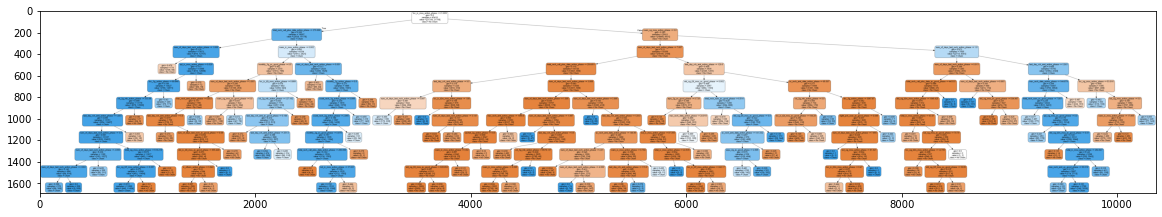

In [513]:
plt.figure(figsize=(20,20))
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True,
                feature_names=X.columns, 
                class_names=['No Churn', "Churn"])

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# Image(graph.create_png(),width=800,height=2000)

filename = "tree.png"
pydotplus.graph_from_dot_data(dot_data.getvalue()).write_png(filename)

# plt.figure(figsize=(12,12))
img = mpimg.imread(filename)
imgplot = plt.imshow(img)

plt.show()

### Most Important Predictors
- loc_ic_mou_action_phase
- total_recharge_call_plus_data_action_phase
- roam_og_mou_action_phase
- num_of_days_last_recharge_action_phase
- roam_ic_mou_action_phase

### Insights

- If incoming minutes of usage is less than 21.81, then there is a probability that the person might churn more.
- If the total recharge in action phase is less than rs280 then there is a high chance of churn
- If number of days since last recharge is greater than 1 and last day recharge amount is less than rs 129.5 then the churn probability is higher.

Therefore, the business should look into the above factors to identify and mitigate churn by provide offers or better service to these individuals

---